<a href="https://colab.research.google.com/github/alezakuskin/Stark_ML/blob/Temperature-tuning/Main_body.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# StarkML: Machine Learning-based Tool for Predicting Stark Parameters of Atomic Emission Lines

# Imports

In [1]:
#!pip install pytorch-tabnet
#!git clone -b Ions https://github.com/alezakuskin/Stark_ML

In [ ]:
# import smtplib
# def send_email(message):
#     smtpObj = smtplib.SMTP('smtp.gmail.com', 587)
#     smtpObj.starttls()
#     smtpObj.login('alezakuskin2407@gmail.com','yaic qsvs nmwd iysf')
#     smtpObj.sendmail("alezakuskin2407@gmail.com", 'ale-zakuskin@yandex.ru', message)
#     smtpObj.quit()

In [1]:
RunInColab = 'google.colab' in str(get_ipython())
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

#Installing missing packages
!pip install optuna
!pip install xgboost
!pip install lightgbm
!pip install roman

#Imports
import os
import stat
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import time
import importlib
import json
import torch
import lightgbm
#torch.autograd.set_detect_anomaly(False)
#torch.set_default_tensor_type(torch.DoubleTensor)
#torch.set_default_dtype(torch.float64)

#Importing sklearn models and metrics
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn import svm
from sklearn.preprocessing import StandardScaler

#Importing TabNet Regressor model    
#from pytorch_tabnet.tab_model import  TabNetRegressor

np.random.seed(777)

import pytorch_tabnet
'''os.environ['tabnet'] = pytorch_tabnet.__path__.__dict__['_path'][0]
os.environ['patchfile'] = os.path.abspath(os.path.join('Stark_ML', 'float64.patch'))
if os.name == 'nt':
    !cd /d %tabnet% & patch < "%patchfile%"
else:
    !cd $tabnet && patch -f < $patchfile
importlib.reload(pytorch_tabnet)'''

if RunInColab:
    from google.colab import output
    def clear_output():
        output.clear()
else:
    from IPython import display
    def clear_output():
        display.clear_output()

clear_output()

In [2]:
#Download and import all utilities and models
'''if os.path.isdir('Stark_ML'):
    import Stark_ML
    def remove_readonly(func, path, _):
            os.chmod(path, stat.S_IWRITE)
            func(path)
    shutil.rmtree(Stark_ML.__path__.__dict__['_path'][0], onerror = remove_readonly)

!git clone -b Ions https://github.com/alezakuskin/Stark_ML'''

import Stark_ML
import Stark_ML.utils.optuning
import Stark_ML.models.base_models
import Stark_ML.utils.metrics
import Stark_ML.utils.terms
import Stark_ML.utils.testset
import Stark_ML.utils.plotting
import Stark_ML.models.tabnet

importlib.reload(Stark_ML.models.base_models)
importlib.reload(Stark_ML.utils.optuning)
importlib.reload(Stark_ML.utils.metrics)
importlib.reload(Stark_ML.utils.plotting)
importlib.reload(Stark_ML.models.tabnet)

from Stark_ML.models.base_models import *
from Stark_ML.utils.optuning import *
from Stark_ML.utils.metrics import *
from Stark_ML.utils.terms import *
from Stark_ML.utils.testset import *
from Stark_ML.utils.plotting import *
from Stark_ML.models.tabnet import *
from Stark_ML.utils import *
from pytorch_tabnet.tab_model import  TabNetRegressor

new_rc_params = {'text.usetex': False,
                "svg.fonttype": 'none'
                }
plt.rcParams.update(new_rc_params)


clear_output()

# Data preprocessing

In [3]:
#Import data for training and testing
data_a = pd.read_excel(Stark_ML.__path__.__dict__['_path'][0] + '/Source_files/Stark_data.xlsx',
                     sheet_name='Experimental',
                     usecols='A:BF'
                   )
#Replace term symbols with quantum numbers
data_a['Term'] = term_to_number(data_a['Term'])
data_a['Term.1'] = term_to_number(data_a['Term.1'])

#Replace accuracy symbols with uncetrainty in %
data_a['w error (%)'] = uncertainty_to_number(data_a[data_a['w error (%)'].notna()]['w error (%)'])
data_a['d error (%)'] = uncertainty_to_number(data_a[data_a['d error (%)'].notna()]['d error (%)'])

In [4]:
#Import ions data for training and testing
data_i = pd.read_excel(Stark_ML.__path__.__dict__['_path'][0] + '/Source_files/Stark_data.xlsx',
                     sheet_name='Ions',
                     usecols='A:BQ'
                   )
#Replace term symbols with quantum numbers
data_i['Term'] = term_to_number(data_i['Term'])
data_i['Term.1'] = term_to_number(data_i['Term.1'])

#Replace accuracy symbols with uncetrainty in %
data_i['w error (%)'] = uncertainty_to_number(data_i[data_i['w error (%)'].notna()]['w error (%)'])
data_i['d error (%)'] = uncertainty_to_number(data_i[data_i['d error (%)'].notna()]['d error (%)'])

#Drop entries with levels' data unavailable
data_i = data_i[data_i['J'].notna()]
data_i = data_i[data_i['J.1'].notna()]

In [5]:
#Making sure that atoms and ions datasets have the same set of columns
for i, name in enumerate(data_i.columns):
    if name != data_a.columns[i]:
        if name in data_a.columns:
            print(f'renaming {name}')
            data_a = data_a.rename(columns = {name: name+'.1'})
        data_a.insert(i, data_i.columns[i], 0)
        print(data_i.columns[i])

Charge
5f
5g
renaming 6d
6d
renaming 7p
7p
5f.1
5g.1
6f
6g
6h
11s


In [6]:
#Merging atoms and ions together
data = pd.concat([data_a, data_i], axis = 0, ignore_index = True)

#Incerting "gap to ionization energy" feature
data.insert(data.columns.get_loc('E upper')+1, 'Gap to ion', 0)
data['Gap to ion'] = gap_to_ion(data, 'E upper')

In [7]:
#Step 1.
#Exclude elements for testing
#Defining elements to exclude from training set
elements_to_exclude = ['S', 'Mg', 'Mn']

In [8]:
#Step 2.
#Creating data, targets and labels for the process of width prediction
data_width = data[data['w (A)'].isna() == False]
data_width_elements = data_width.loc[data_width['Element'].isin(elements_to_exclude)]
data_width = data_width.drop(data_width_elements.index)
data_width = data_width.sort_values(by=['Z number'])

#Separate targets from data
target_width = data_width['w (A)']
target_width_elements = data_width_elements['w (A)']

#Separate labels from data
label_width = data_width.loc[:, ['Element', 'Wavelength']]
label_width_elements = data_width_elements.loc[:, ['Element', 'Wavelength']]

#Remove width and shift values from data
data_width = data_width.drop(columns = ['d (A)', 'w (A)'])
data_width_elements = data_width_elements.drop(columns = ['d (A)', 'w (A)'])

#Remove uncertainty from data
data_width = data_width.drop(columns = ['w error (%)', 'd error (%)'])
data_width_elements = data_width_elements.drop(columns = ['w error (%)', 'd error (%)'])

In [9]:
#Step 3.
#Split into train and test by quartiles
#Q1
data_test_q1, target_test_q1 = test_selection(data_width,
                                              target_width,
                                              p = 0.137,
                                              low_limit = 'min',
                                              up_limit = 25,
                                              random_state = 7)
#Q2
data_test_q2, target_test_q2 = test_selection(data_width,
                                              target_width,
                                              p = 0.137,
                                              low_limit = 25,
                                              up_limit = 50,
                                              random_state = 7)
#Q3
data_test_q3, target_test_q3 = test_selection(data_width,
                                              target_width,
                                              p = 0.137,
                                              low_limit = 50,
                                              up_limit = 75,
                                              random_state = 7)
#Q4
target_test_q4 = pd.Series()
while len(target_test_q4[target_test_q4 > 150]) < 1 or len(target_test_q4[(target_test_q4 > 70) & (target_test_q4 < 150)]) < 1:
    data_test_q4, target_test_q4 = test_selection(data_width,
                                                target_width,
                                                p = 0.137,
                                                low_limit = 75,
                                                random_state = None)
#manually selected and fixed random state that gives the closest train and test distributios  
data_test_q4, target_test_q4 = test_selection(data_width,
                                                target_width,
                                                p = 0.137,
                                                low_limit = 75,
                                                random_state = 3)

#Combining quartiles into full test dataset
data_width_test, target_width_test = pd.concat([data_test_q1, data_test_q2]), pd.concat([target_test_q1, target_test_q2])
data_width_test, target_width_test = pd.concat([data_width_test, data_test_q3]), pd.concat([target_width_test, target_test_q3])
data_width_test, target_width_test = pd.concat([data_width_test, data_test_q4]), pd.concat([target_width_test, target_test_q4])

#Remove test entries from data -> get train set
data_width_train, target_width_train = data_width.drop(data_width_test.index), target_width.drop(target_width_test.index)

## -- *OPTIONAL*-- Atoms + ions data visual description

In [11]:
data_width_stats = target_width.describe()
print(data_width_stats)

count    5647.000000
mean        1.300846
std         5.433344
min         0.001500
25%         0.144182
50%         0.340000
75%         0.929138
max       180.500000
Name: w (A), dtype: float64


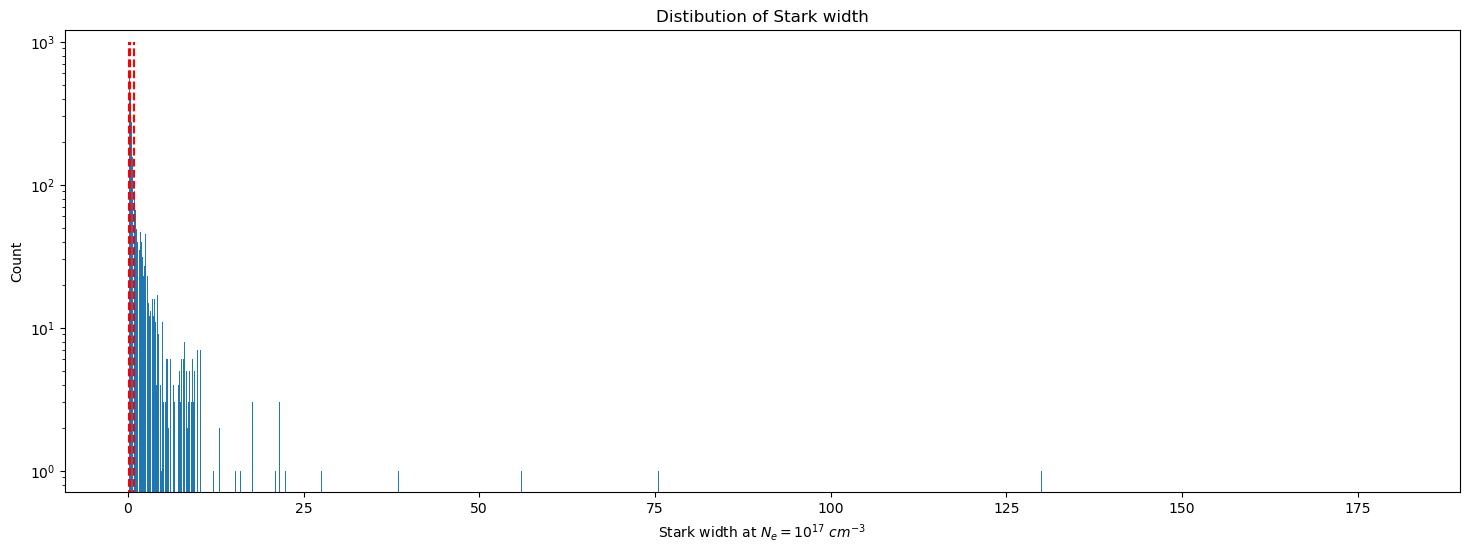

In [12]:
fig, ax = plt.subplots(figsize = (18, 6))
n, bins, patches = plt.hist(target_width, bins='auto', log=True, rwidth = 0.8)
ax.vlines(x = data_width_stats['25%'], ymin = 0, ymax = 1000, ls='--', colors='r')
ax.vlines(x = data_width_stats['50%'], ymin = 0, ymax = 1000, ls='--', colors='r')
ax.vlines(x = data_width_stats['75%'], ymin = 0, ymax = 1000, ls='--', colors='r')

ax.set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
ax.set_ylabel('Count')
ax.set_title('Distibution of Stark width')

plt.show()

#plt.savefig('Width distribution.png', dpi = 300)

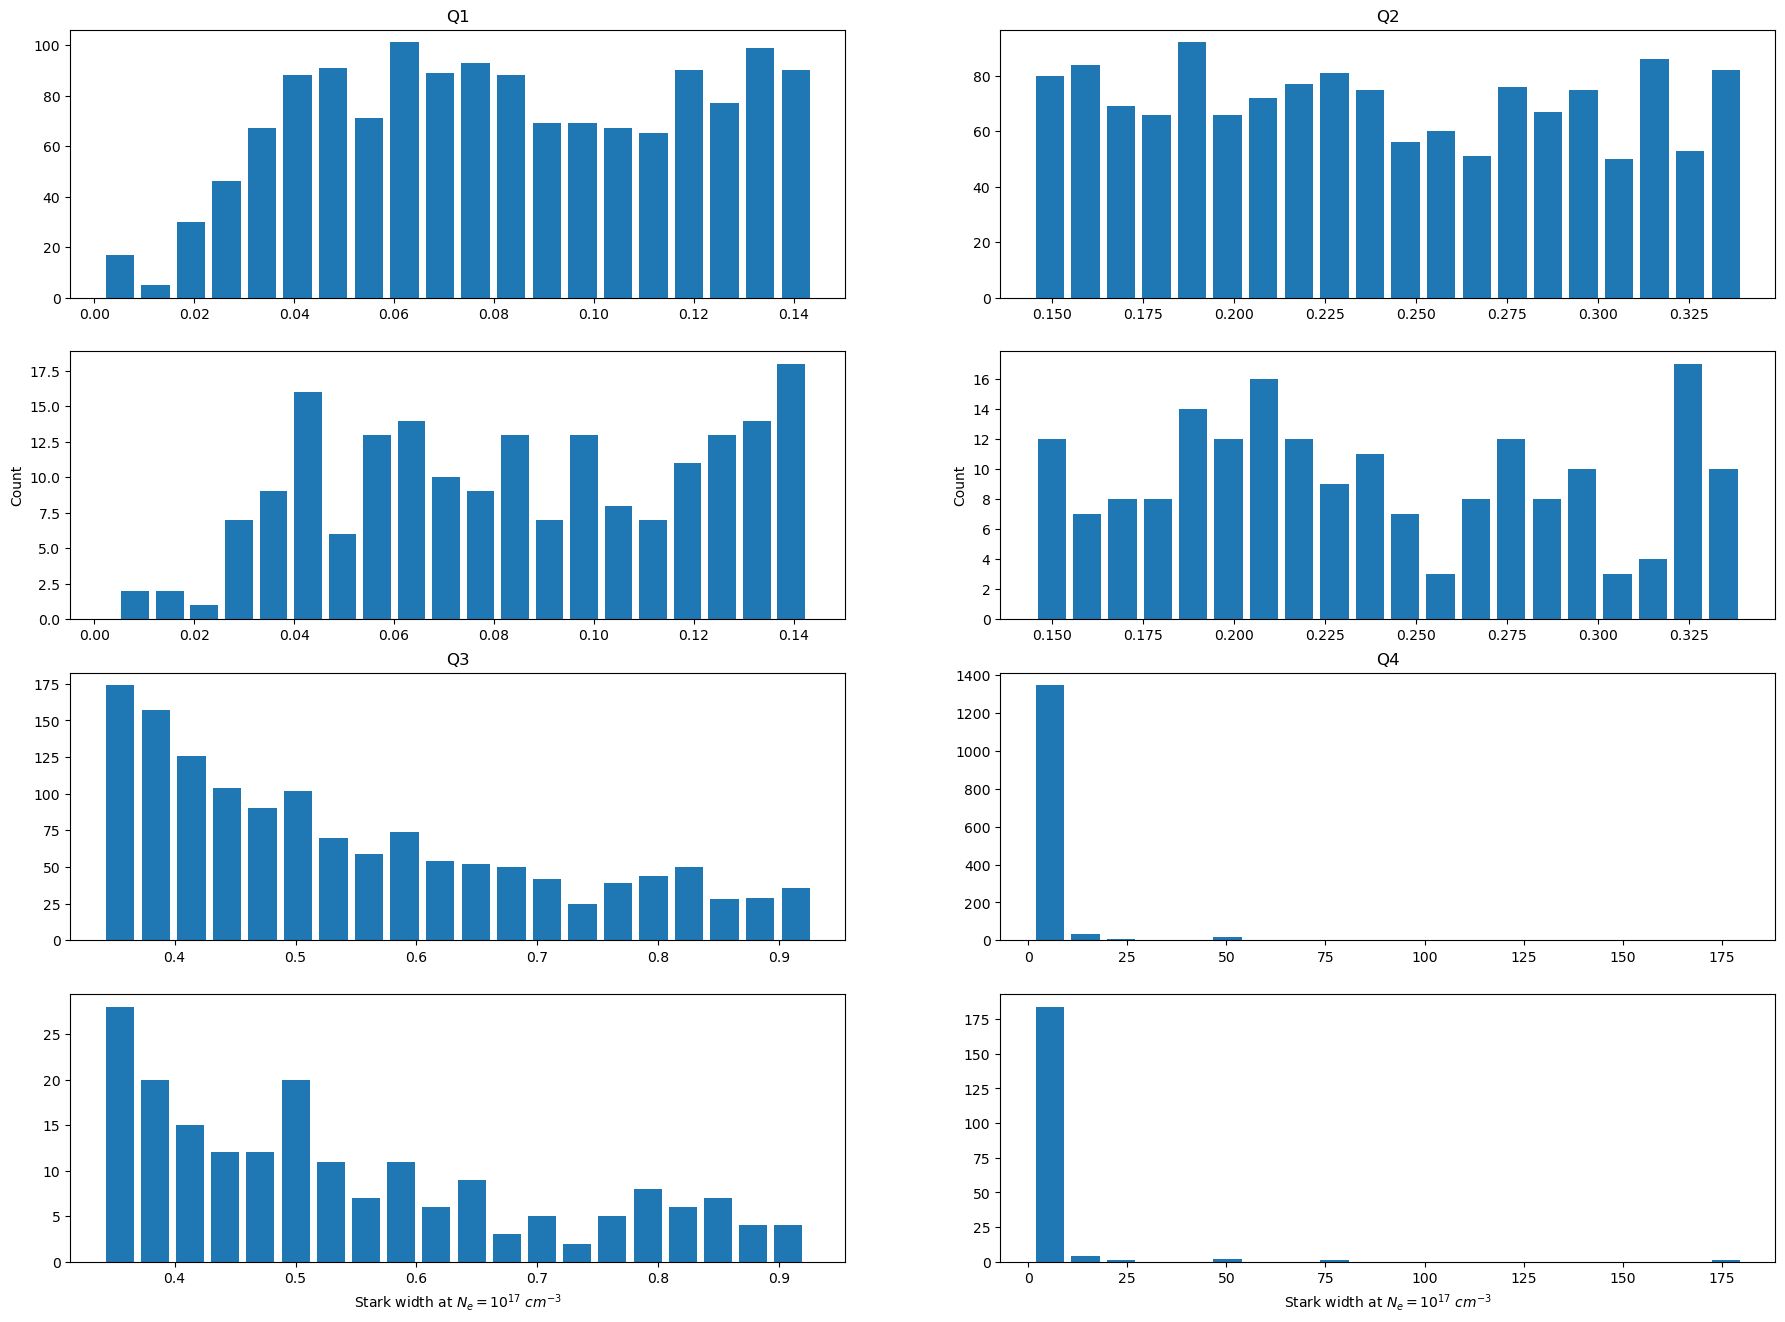

In [13]:
#Plotting train-test distributions
fig, axs = plt.subplots(4, 2, figsize = (22, 16), sharex = False)

axs[0, 0].hist(target_width[target_width <= data_width_stats['25%']], bins=20, log=False, rwidth = 0.8)
axs[1, 0].hist(target_test_q1, bins = 20, rwidth = 0.8)

axs[0, 1].hist(target_width[(target_width > data_width_stats['25%']) & (target_width <= data_width_stats['50%'])],
                            bins=20, log=False, rwidth = 0.8)
axs[1, 1].hist(target_test_q2, bins = 20, rwidth = 0.8)

axs[2, 0].hist(target_width[(target_width > data_width_stats['50%']) & (target_width <= data_width_stats['75%'])],
                            bins=20, log=False, rwidth = 0.8)
axs[3, 0].hist(target_test_q3, bins = 20, rwidth = 0.8)

axs[2, 1].hist(target_width[target_width > data_width_stats['75%']],
                            bins=20, log=False, rwidth = 0.8)
axs[3, 1].hist(target_test_q4, bins = 20, rwidth = 0.8)

axs[1, 0].sharex(axs[0, 0])
axs[3, 0].sharex(axs[2, 0])
axs[1, 1].sharex(axs[0, 1])
axs[3, 1].sharex(axs[2, 1])

axs[0, 0].set_title('Q1')
axs[2, 0].set_title('Q3')
axs[0, 1].set_title('Q2')
axs[2, 1].set_title('Q4')
axs[1, 0].set_ylabel('Count')
axs[1, 1].set_ylabel('Count')
axs[3, 0].set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
axs[3, 1].set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
plt.show()

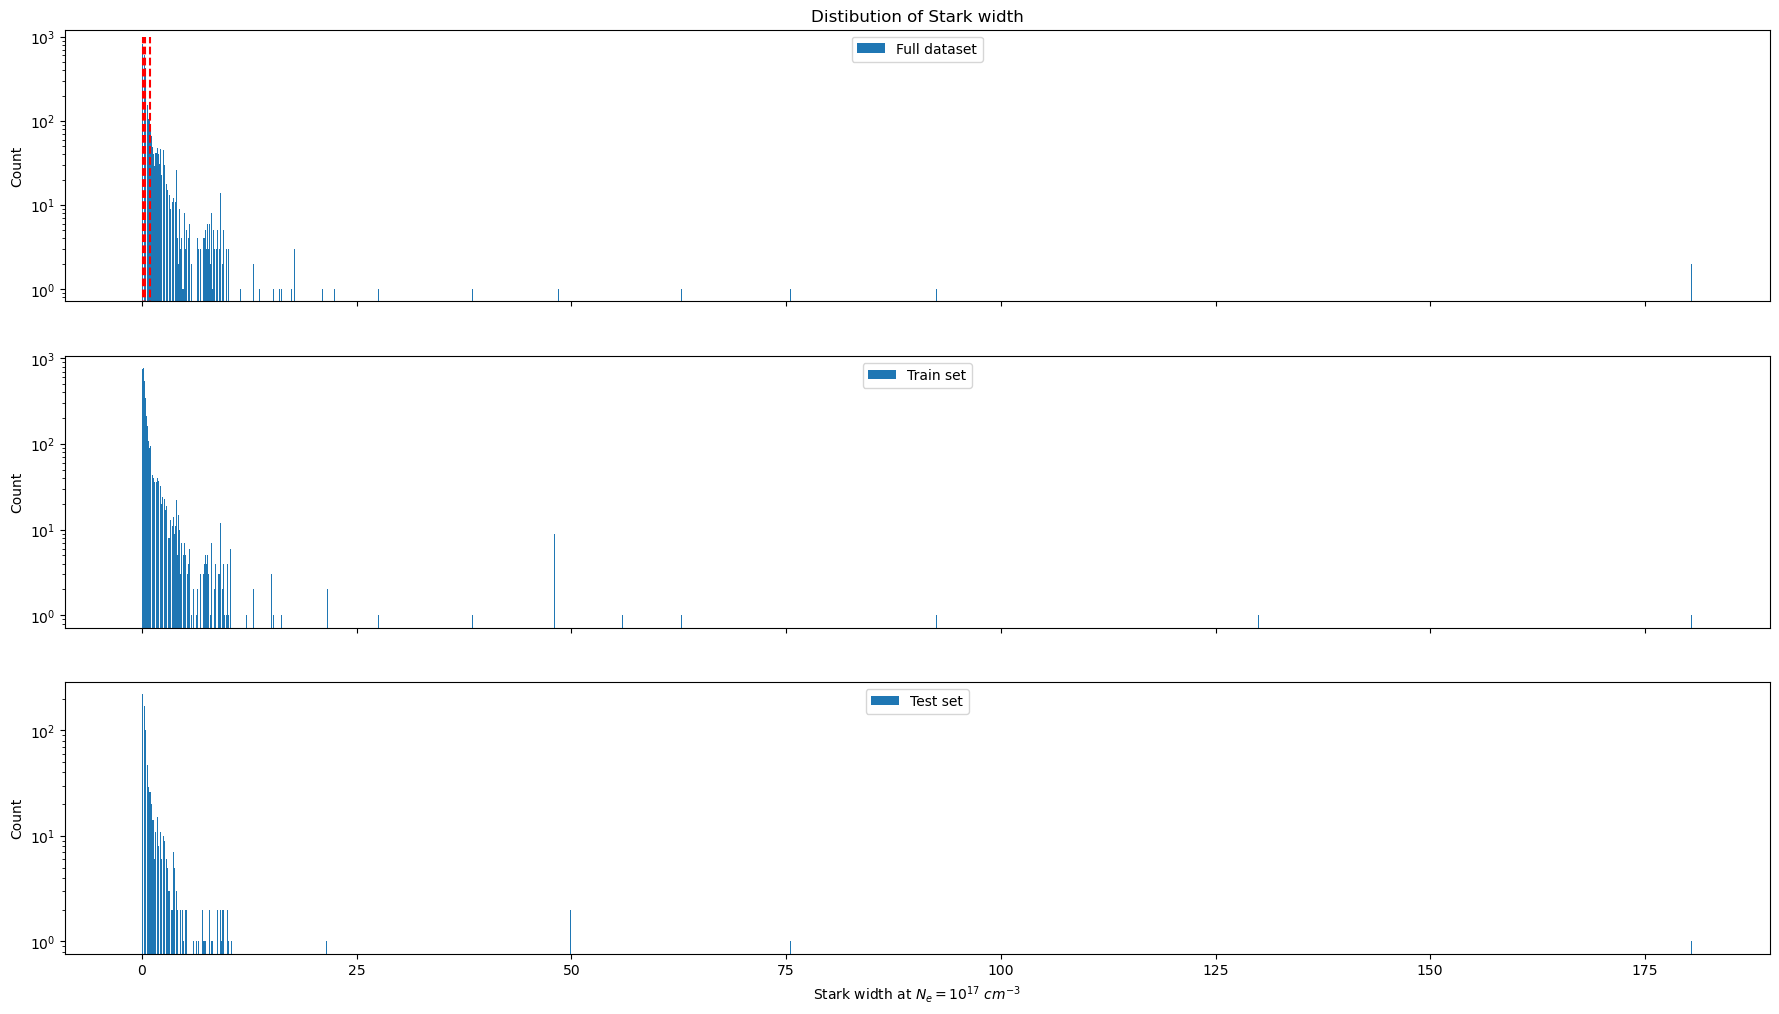

In [14]:
test_width_stats = target_width_test.describe()

fig, axs = plt.subplots(3, 1, figsize = (22, 12), sharex = True)
axs[0].hist(target_width, bins='auto', log=True, rwidth = 0.8, label = 'Full dataset')
axs[1].hist(target_width_train, bins = 'auto', log = True, rwidth = 0.8, label = 'Train set')
axs[2].hist(target_width_test, bins = 'auto', log = True, rwidth = 0.8, label = 'Test set')


axs[0].vlines(x = data_width_stats['25%'], ymin = 0, ymax = 1000, ls='--', colors='r')
axs[0].vlines(x = data_width_stats['50%'], ymin = 0, ymax = 1000, ls='--', colors='r')
axs[0].vlines(x = data_width_stats['75%'], ymin = 0, ymax = 1000, ls='--', colors='r')

axs[0].legend(loc = 'upper center')
axs[1].legend(loc = 'upper center')
axs[2].legend(loc = 'upper center')
axs[2].set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
axs[0].set_ylabel('Count')
axs[1].set_ylabel('Count')
axs[2].set_ylabel('Count')
axs[0].set_title('Distibution of Stark width')

plt.show()

#plt.savefig('Width distribution.png', dpi = 300)

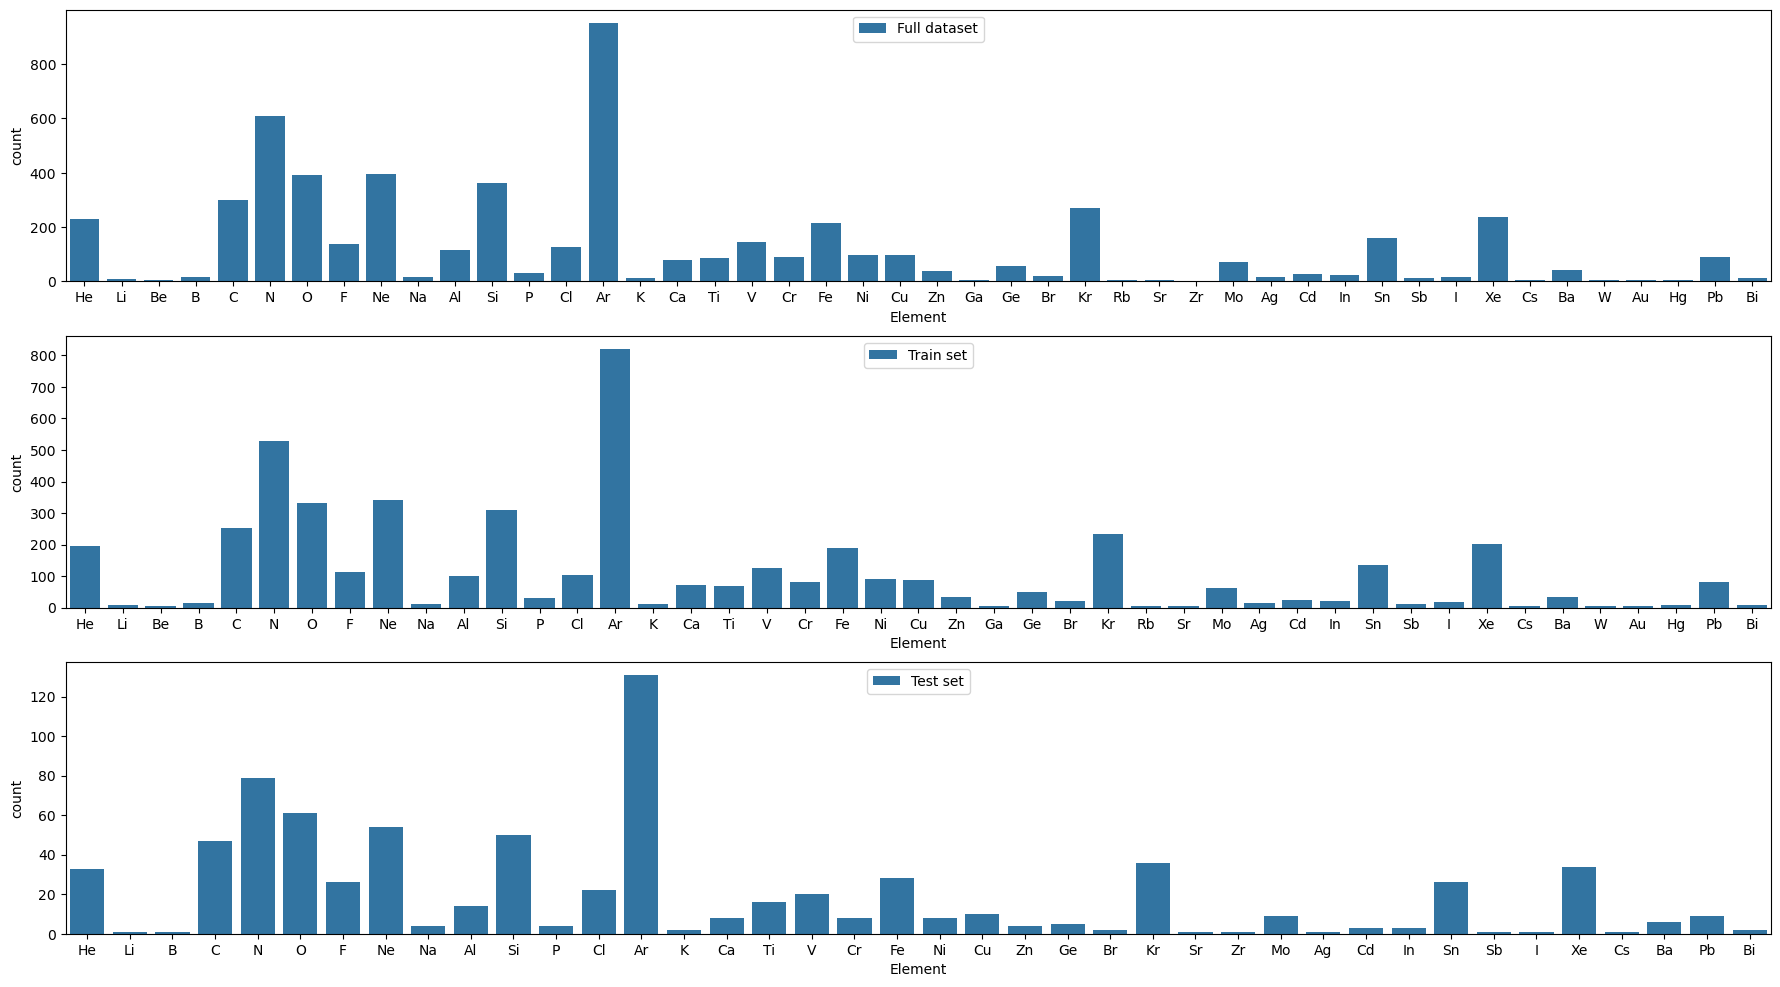

In [15]:
fig, axs = plt.subplots(3, 1, figsize = (22, 12), sharex = False)
sns.countplot(data = data_width, x = 'Element',  ax = axs[0], label = 'Full dataset')
sns.countplot(data = data_width_train.sort_values(by = ['Z number']), x = 'Element',  ax = axs[1], label = 'Train set')
sns.countplot(data = data_width_test.sort_values(by = ['Z number']), x = 'Element', ax = axs[2], label = 'Test set')

axs[0].legend(loc = 'upper center')
axs[1].legend(loc = 'upper center')
axs[2].legend(loc = 'upper center')

plt.show()

# Shift data preprocessing

In [10]:
#Create dataset with shift data
data_shift = data[data['d (A)'].isna() == False]

#Remove unneccessary columns (i.e. those with one value only)
columns_to_drop = []
for col in data_shift.columns:
    if data_shift[col].nunique() == 1:
        columns_to_drop.append(col)
data_shift = data_shift.drop(columns = columns_to_drop)

#Creating data, target and labels for shift prediction
data_shift_elements = data_shift.loc[data_shift['Element'].isin(elements_to_exclude)]
data_shift = data_shift.drop(data_shift_elements.index)
data_shift = data_shift.sort_values(by=['Z number'])

#Separate targets from data
target_shift = data_shift['d (A)']
target_shift_elements = data_shift_elements['d (A)']

#Separate labels from data
label_shift = data_shift.loc[:, ['Element', 'Wavelength']]
label_shift_elements = data_shift_elements.loc[:, ['Element', 'Wavelength']]

#Remove width and shift values from data
data_shift = data_shift.drop(columns = ['w (A)', 'd (A)'])
data_shift_elements = data_shift_elements.drop(columns = ['w (A)', 'd (A)'])

#Remove uncertainty from data
data_shift = data_shift.drop(columns = ['w error (%)', 'd error (%)'])
data_shift_elements = data_shift_elements.drop(columns = ['w error (%)', 'd error (%)'])

In [11]:
#Split into train and test by quartiles
#Q1
data_test_q1, target_test_q1 = test_selection(data_shift,
                                              target_shift,
                                              p = 0.135,
                                              low_limit = 'min',
                                              up_limit = 25,
                                              random_state = 6)

#Q2
data_test_q2, target_test_q2 = test_selection(data_shift,
                                              target_shift,
                                              p = 0.135,
                                              low_limit = 25,
                                              up_limit = 50,
                                              random_state = 6)

#Q3
data_test_q3, target_test_q3 = test_selection(data_shift,
                                              target_shift,
                                              p = 0.135,
                                              low_limit = 50,
                                              up_limit = 75,
                                              random_state = 6)

#Q4
target_test_q4 = pd.Series()
while len(target_test_q4[target_test_q4 > 17.5]) < 1 or len(target_test_q4[(target_test_q4 > 11.5) & (target_test_q4 < 17.5)]) < 1:
    data_test_q4, target_test_q4 = test_selection(data_shift,
                                                target_shift,
                                                p = 0.135,
                                                low_limit = 75,
                                                random_state = None)
  

#Merging full train and test datasets
data_shift_test, target_shift_test = pd.concat([data_test_q1, data_test_q2]), pd.concat([target_test_q1, target_test_q2])
data_shift_test, target_shift_test = pd.concat([data_shift_test, data_test_q3]), pd.concat([target_shift_test, target_test_q3])
data_shift_test, target_shift_test = pd.concat([data_shift_test, data_test_q4]), pd.concat([target_shift_test, target_test_q4])

data_shift_train, target_shift_train = data_shift.drop(data_shift_test.index), target_shift.drop(target_shift_test.index)

## -- *OPTIONAL*-- Shift data visual description 

In [163]:
data_shift_stats = target_shift.describe()
print(data_shift_stats)

count    2220.000000
mean        0.446867
std         1.729014
min        -7.485437
25%        -0.021000
50%         0.021564
75%         0.222000
max        20.000000
Name: d (A), dtype: float64


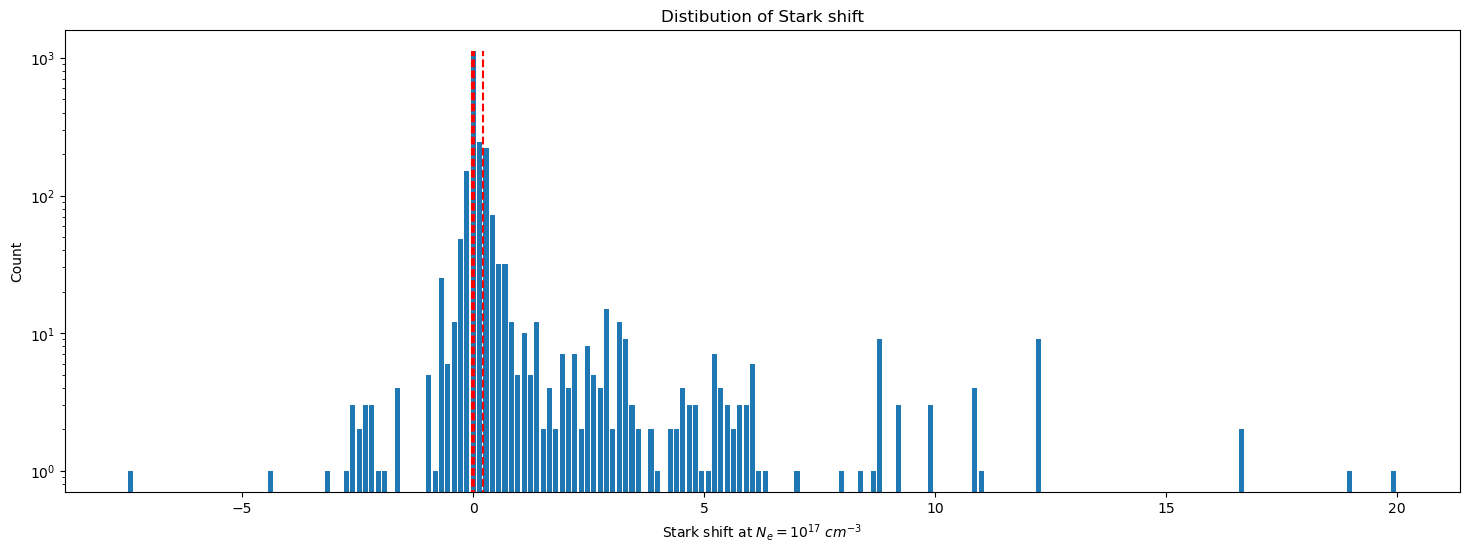

In [19]:
fig, ax = plt.subplots(figsize = (18, 6))
n, bins, patches = plt.hist(target_shift, bins=200, log=True, rwidth = 0.8)
ax.vlines(x = data_shift_stats['25%'], ymin = 0, ymax = np.max(n), ls='--', colors='r')
ax.vlines(x = data_shift_stats['50%'], ymin = 0, ymax = np.max(n), ls='--', colors='r')
ax.vlines(x = data_shift_stats['75%'], ymin = 0, ymax = np.max(n), ls='--', colors='r')

ax.set_xlabel('Stark shift at $N_e = 10^{17}$ $cm^{-3}$')
ax.set_ylabel('Count')
ax.set_title('Distibution of Stark shift')

plt.show()

#plt.savefig('Shift distribution.png', dpi = 300)

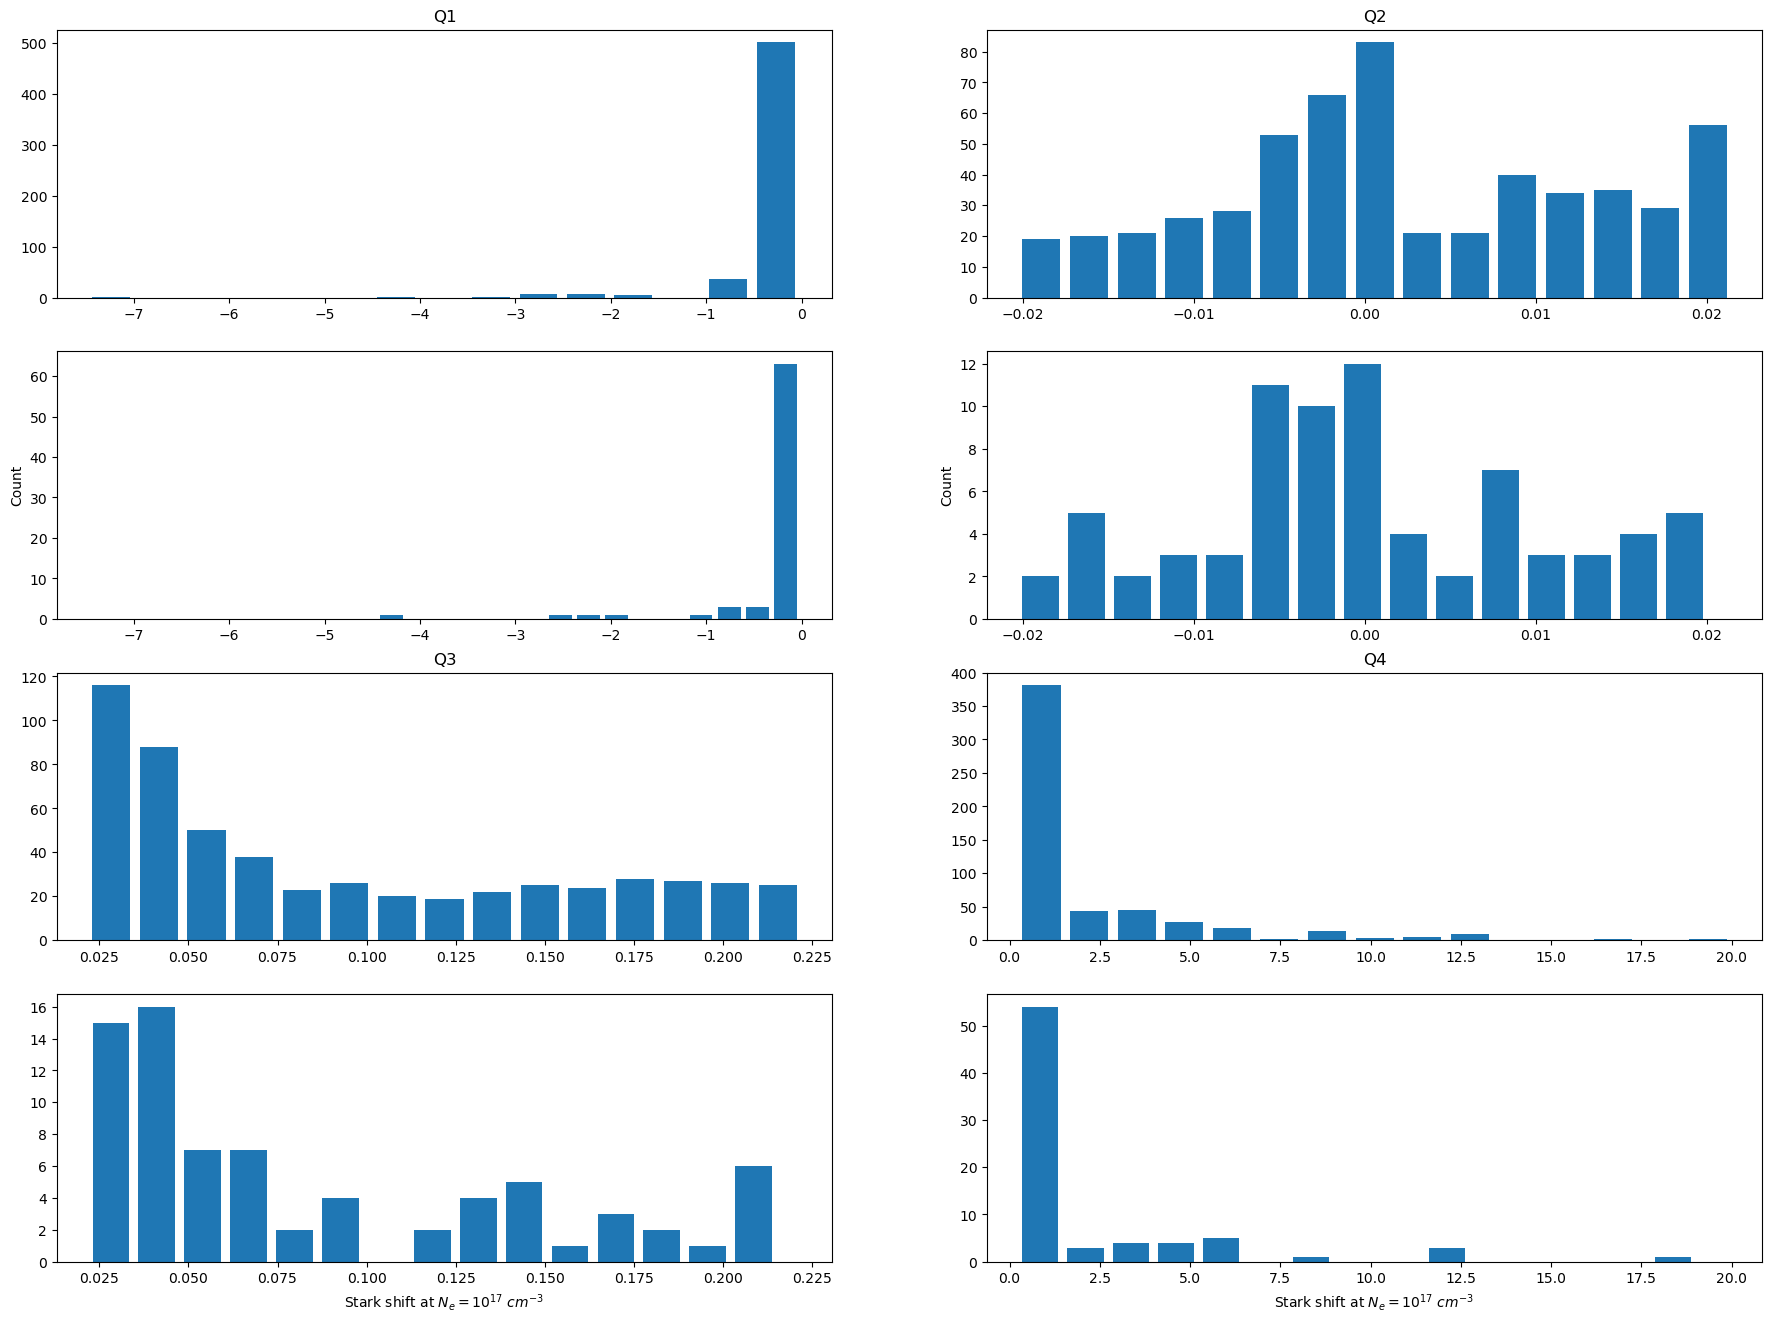

In [67]:
fig, axs = plt.subplots(4, 2, figsize = (22, 16), sharex = False)

axs[0, 0].hist(target_shift[target_shift <= data_shift_stats['25%']], bins=15, log=False, rwidth = 0.8)
axs[1, 0].hist(target_test_q1, bins = 15, rwidth = 0.8)

axs[0, 1].hist(target_shift[(target_shift > data_shift_stats['25%']) & (target_shift <= data_shift_stats['50%'])],
                            bins=15, log=False, rwidth = 0.8)
axs[1, 1].hist(target_test_q2, bins = 15, rwidth = 0.8)

axs[2, 0].hist(target_shift[(target_shift > data_shift_stats['50%']) & (target_shift <= data_shift_stats['75%'])],
                            bins=15, log=False, rwidth = 0.8)
axs[3, 0].hist(target_test_q3, bins = 15, rwidth = 0.8)

axs[2, 1].hist(target_shift[target_shift > data_shift_stats['75%']],
                            bins=15, log=False, rwidth = 0.8)
axs[3, 1].hist(target_test_q4, bins = 15, rwidth = 0.8)

axs[1, 0].sharex(axs[0, 0])
axs[3, 0].sharex(axs[2, 0])
axs[1, 1].sharex(axs[0, 1])
axs[3, 1].sharex(axs[2, 1])

axs[0, 0].set_title('Q1')
axs[2, 0].set_title('Q3')
axs[0, 1].set_title('Q2')
axs[2, 1].set_title('Q4')
axs[1, 0].set_ylabel('Count')
axs[1, 1].set_ylabel('Count')
axs[3, 0].set_xlabel('Stark shift at $N_e = 10^{17}$ $cm^{-3}$')
axs[3, 1].set_xlabel('Stark shift at $N_e = 10^{17}$ $cm^{-3}$')
plt.show()

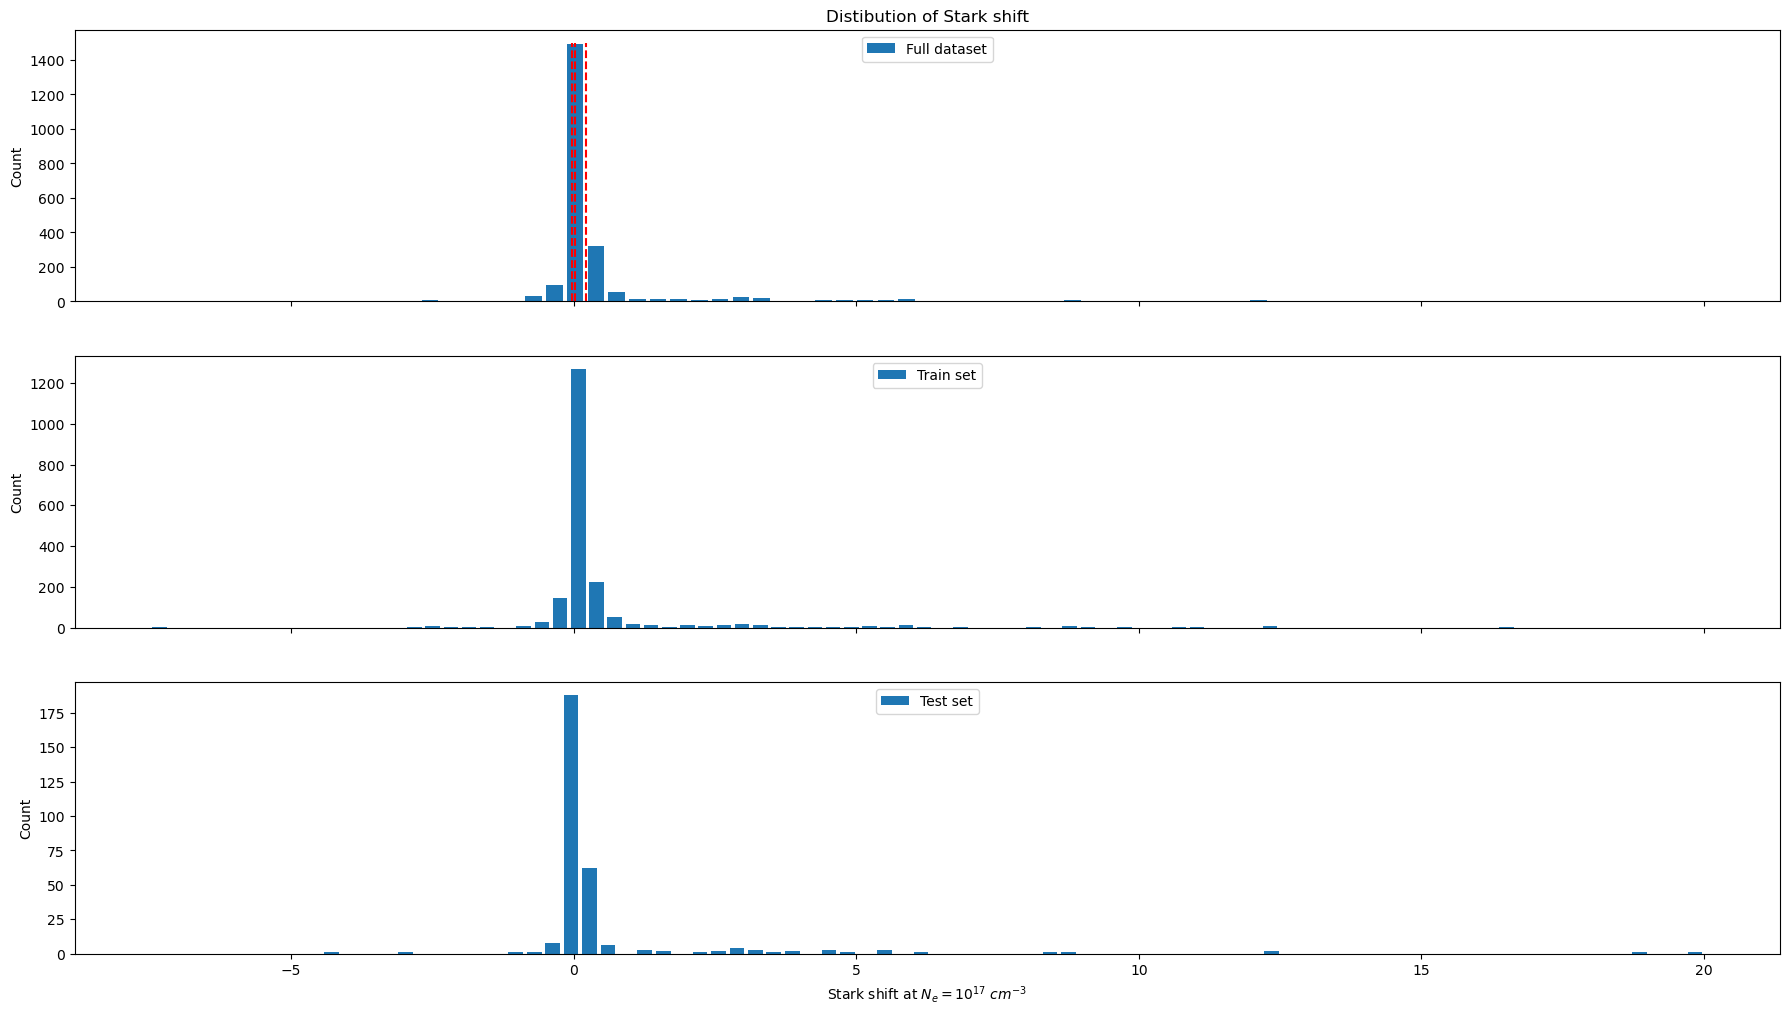

In [21]:
test_shift_stats = target_shift_test.describe()

fig, axs = plt.subplots(3, 1, figsize = (22, 12), sharex = True)
axs[0].hist(target_shift, bins=75, log=False, rwidth = 0.8, label = 'Full dataset')
axs[1].hist(target_shift_train, bins = 75, log = False, rwidth = 0.8, label = 'Train set')
axs[2].hist(target_shift_test, bins = 75, log = False, rwidth = 0.8, label = 'Test set')


axs[0].vlines(x = data_shift_stats['25%'], ymin = 0, ymax = 1500, ls='--', colors='r')
axs[0].vlines(x = data_shift_stats['50%'], ymin = 0, ymax = 1500, ls='--', colors='r')
axs[0].vlines(x = data_shift_stats['75%'], ymin = 0, ymax = 1500, ls='--', colors='r')

axs[0].legend(loc = 'upper center')
axs[1].legend(loc = 'upper center')
axs[2].legend(loc = 'upper center')
axs[2].set_xlabel('Stark shift at $N_e = 10^{17}$ $cm^{-3}$')
axs[0].set_ylabel('Count')
axs[1].set_ylabel('Count')
axs[2].set_ylabel('Count')
axs[0].set_title('Distibution of Stark shift')

plt.show()

#plt.savefig('shift distribution.png', dpi = 300)

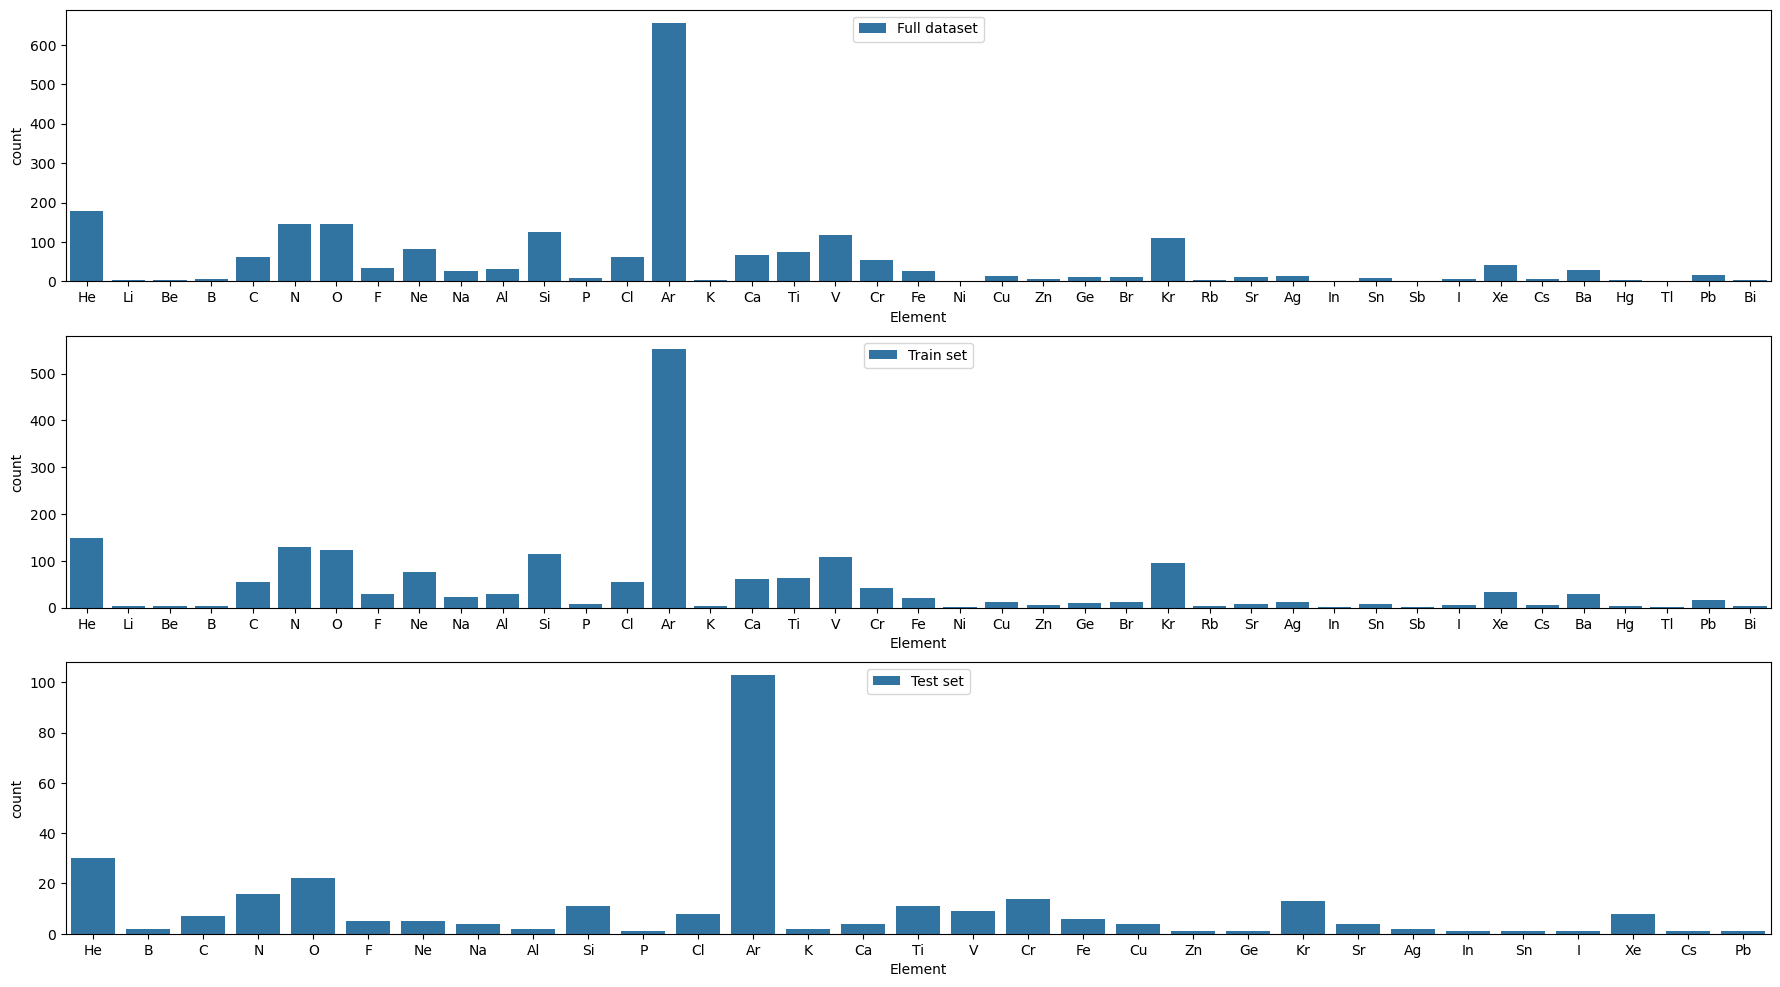

In [22]:
fig, axs = plt.subplots(3, 1, figsize = (22, 12), sharex = False)
sns.countplot(data = data_shift, x = 'Element',  ax = axs[0], label = 'Full dataset')
sns.countplot(data = data_shift_train.sort_values(by = ['Z number']), x = 'Element',  ax = axs[1], label = 'Train set')
sns.countplot(data = data_shift_test.sort_values(by = ['Z number']), x = 'Element', ax = axs[2], label = 'Test set')

axs[0].legend(loc = 'upper center')
axs[1].legend(loc = 'upper center')
axs[2].legend(loc = 'upper center')

plt.show()

# Both data preprocessing

In [12]:
#Create dataset with both data
data_both = data[(data['w (A)'].isna() == False) & (data['d (A)'].isna() == False)]

#Remove unneccessary columns (i.e. those with one value only)
columns_to_drop = []
for col in data_both.columns:
    if data_both[col].nunique() == 1:
        columns_to_drop.append(col)
data_both = data_both.drop(columns = columns_to_drop)

#Creating data, target and labels for shift prediction
data_both_elements = data_both.loc[data_both['Element'].isin(elements_to_exclude)]
data_both = data_both.drop(data_both_elements.index)
data_both = data_both.sort_values(by=['Z number'])

#Separate targets from data
target_both = data_both['d (A)']
target_both_elements = data_both_elements['d (A)']

#Separate labels from data
label_both = data_both.loc[:, ['Element', 'Wavelength']]
label_both_elements = data_both_elements.loc[:, ['Element', 'Wavelength']]

#Remove shift values from data
data_both = data_both.drop(columns = ['d (A)'])
data_both_elements = data_both_elements.drop(columns = ['d (A)'])

#Remove uncertainty from data
data_both = data_both.drop(columns = ['w error (%)', 'd error (%)'])
data_both_elements = data_both_elements.drop(columns = ['w error (%)', 'd error (%)'])

In [13]:
#Split into train and test
data_both_train, data_both_test, target_both_train, target_both_test = train_test_split(data_both,
                                                                                       target_both,
                                                                                       test_size = 0.114,
                                                                                       random_state = 6)

In [14]:
data_both_stats = target_both.describe()
print(data_both_stats)

count    1641.000000
mean        0.401503
std         1.627817
min        -7.485437
25%        -0.022000
50%         0.025000
75%         0.207000
max        12.215909
Name: d (A), dtype: float64


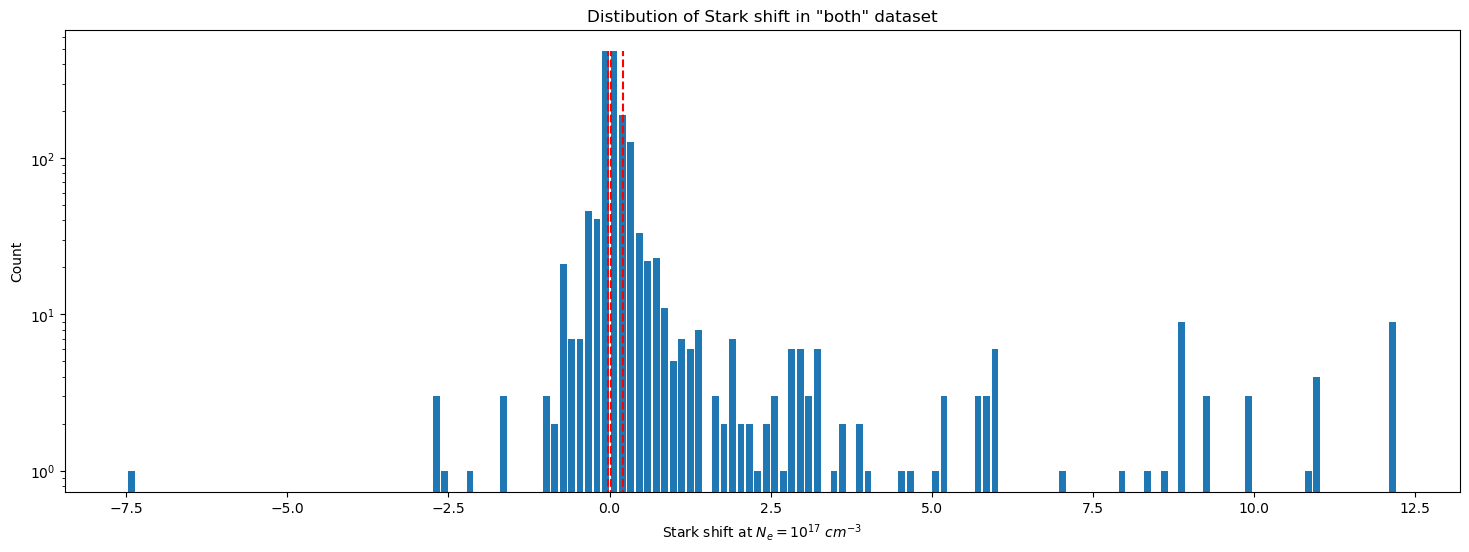

In [26]:
fig, ax = plt.subplots(figsize = (18, 6))
n, bins, patches = plt.hist(target_both, bins=150, log=True, rwidth = 0.8)
ax.vlines(x = data_both_stats['25%'], ymin = 0, ymax = np.max(n), ls='--', colors='r')
ax.vlines(x = data_both_stats['50%'], ymin = 0, ymax = np.max(n), ls='--', colors='r')
ax.vlines(x = data_both_stats['75%'], ymin = 0, ymax = np.max(n), ls='--', colors='r')

ax.set_xlabel('Stark shift at $N_e = 10^{17}$ $cm^{-3}$')
ax.set_ylabel('Count')
ax.set_title('Distibution of Stark shift in "both" dataset')

plt.show()

#plt.savefig('Shift distribution.png', dpi = 300)

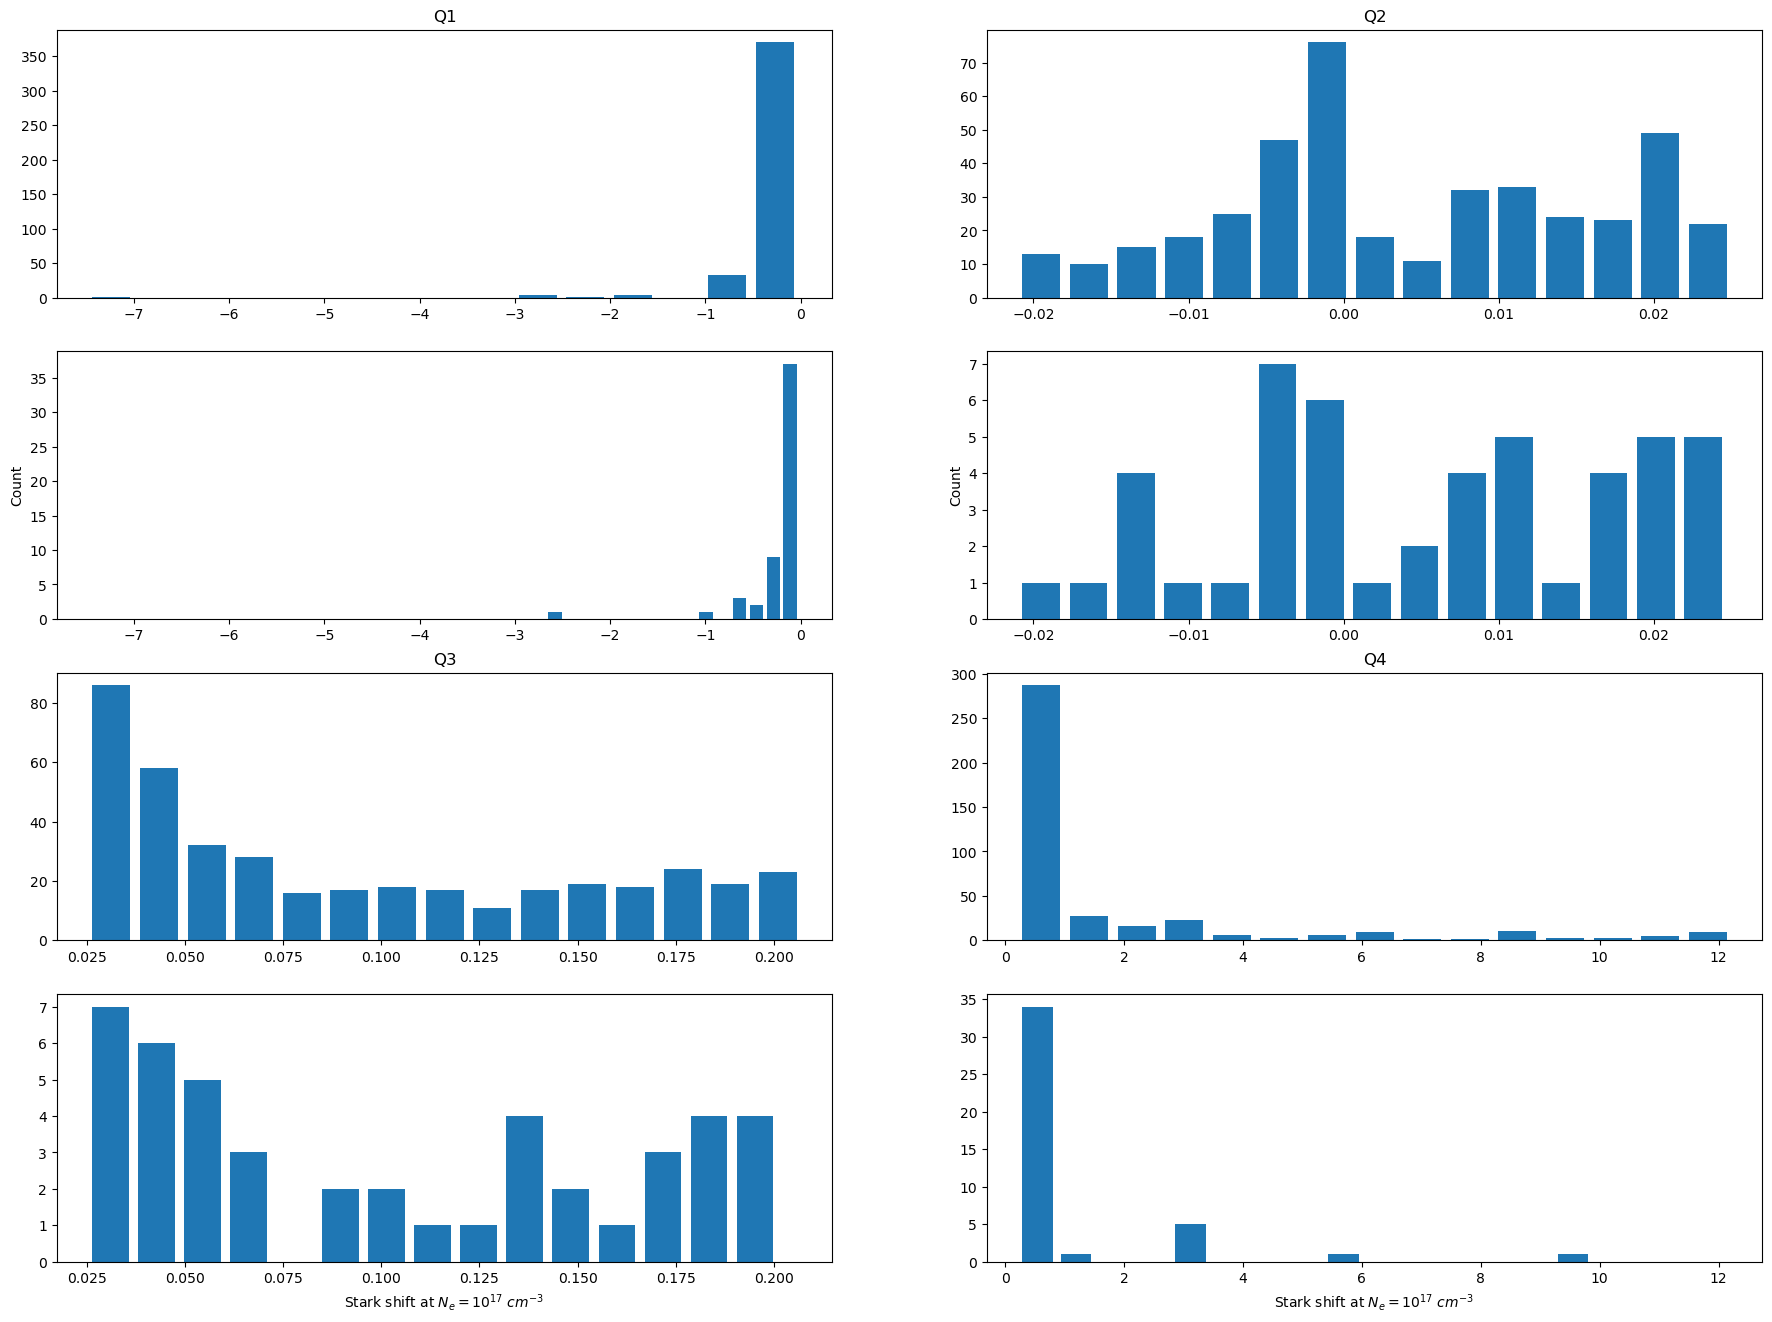

In [27]:
fig, axs = plt.subplots(4, 2, figsize = (22, 16), sharex = False)

axs[0, 0].hist(target_both[target_both <= data_both_stats['25%']], bins=15, log=False, rwidth = 0.8)
axs[1, 0].hist(target_both_test[target_both_test <= data_both_stats['25%']], bins = 15, rwidth = 0.8)

axs[0, 1].hist(target_both[(target_both > data_both_stats['25%']) & (target_both <= data_both_stats['50%'])],
               bins=15, log=False, rwidth = 0.8)
axs[1, 1].hist(target_both_test[(target_both_test > data_both_stats['25%']) & (target_both_test <= data_both_stats['50%'])],
               bins = 15, rwidth = 0.8)

axs[2, 0].hist(target_both[(target_both > data_both_stats['50%']) & (target_both <= data_both_stats['75%'])],
               bins=15, log=False, rwidth = 0.8)
axs[3, 0].hist(target_both_test[(target_both_test > data_both_stats['50%']) & (target_both_test <= data_both_stats['75%'])],
               bins = 15, rwidth = 0.8)

axs[2, 1].hist(target_both[target_both > data_both_stats['75%']],
                            bins=15, log=False, rwidth = 0.8)
axs[3, 1].hist(target_both_test[target_both_test > data_both_stats['75%']], bins = 15, rwidth = 0.8)

axs[1, 0].sharex(axs[0, 0])
axs[3, 0].sharex(axs[2, 0])
axs[1, 1].sharex(axs[0, 1])
axs[3, 1].sharex(axs[2, 1])

axs[0, 0].set_title('Q1')
axs[2, 0].set_title('Q3')
axs[0, 1].set_title('Q2')
axs[2, 1].set_title('Q4')
axs[1, 0].set_ylabel('Count')
axs[1, 1].set_ylabel('Count')
axs[3, 0].set_xlabel('Stark shift at $N_e = 10^{17}$ $cm^{-3}$')
axs[3, 1].set_xlabel('Stark shift at $N_e = 10^{17}$ $cm^{-3}$')
plt.show()

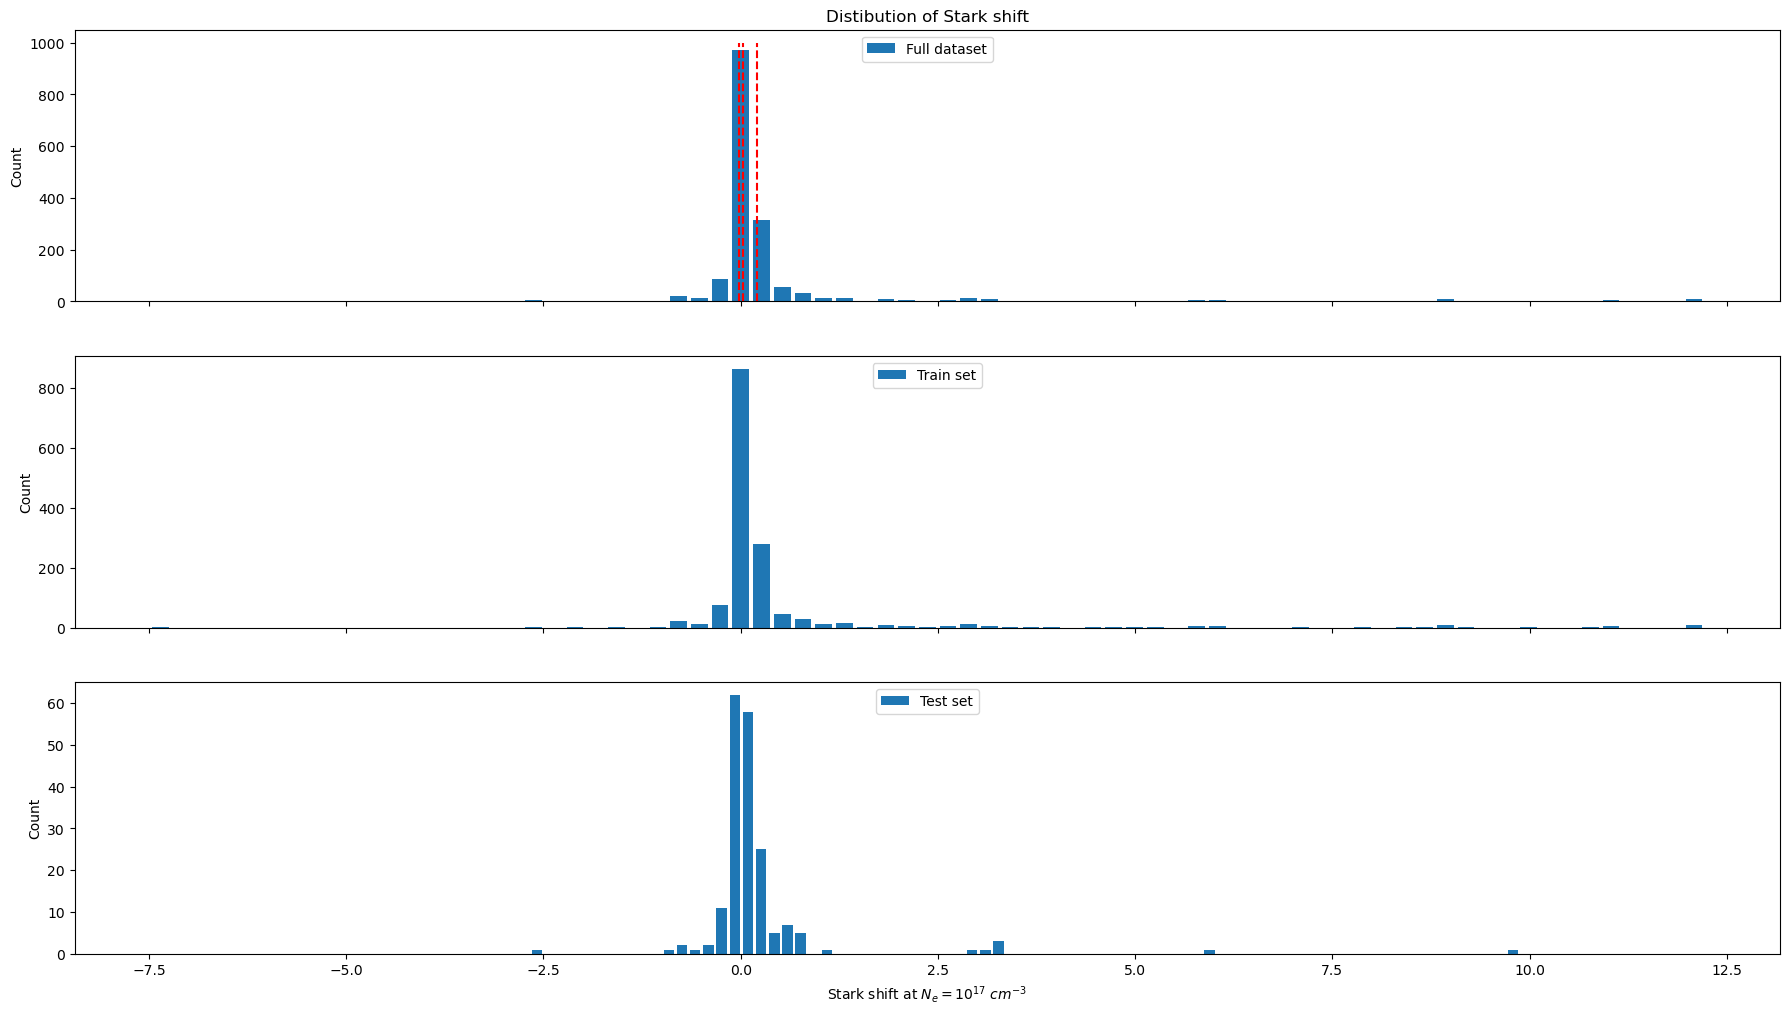

In [28]:
test_both_stats = target_both_test.describe()

fig, axs = plt.subplots(3, 1, figsize = (22, 12), sharex = True)
axs[0].hist(target_both, bins=75, log=False, rwidth = 0.8, label = 'Full dataset')
axs[1].hist(target_both_train, bins = 75, log = False, rwidth = 0.8, label = 'Train set')
axs[2].hist(target_both_test, bins = 75, log = False, rwidth = 0.8, label = 'Test set')


axs[0].vlines(x = data_both_stats['25%'], ymin = 0, ymax = 1000, ls='--', colors='r')
axs[0].vlines(x = data_both_stats['50%'], ymin = 0, ymax = 1000, ls='--', colors='r')
axs[0].vlines(x = data_both_stats['75%'], ymin = 0, ymax = 1000, ls='--', colors='r')

axs[0].legend(loc = 'upper center')
axs[1].legend(loc = 'upper center')
axs[2].legend(loc = 'upper center')
axs[2].set_xlabel('Stark shift at $N_e = 10^{17}$ $cm^{-3}$')
axs[0].set_ylabel('Count')
axs[1].set_ylabel('Count')
axs[2].set_ylabel('Count')
axs[0].set_title('Distibution of Stark shift')

plt.show()

#plt.savefig('shift distribution.png', dpi = 300)

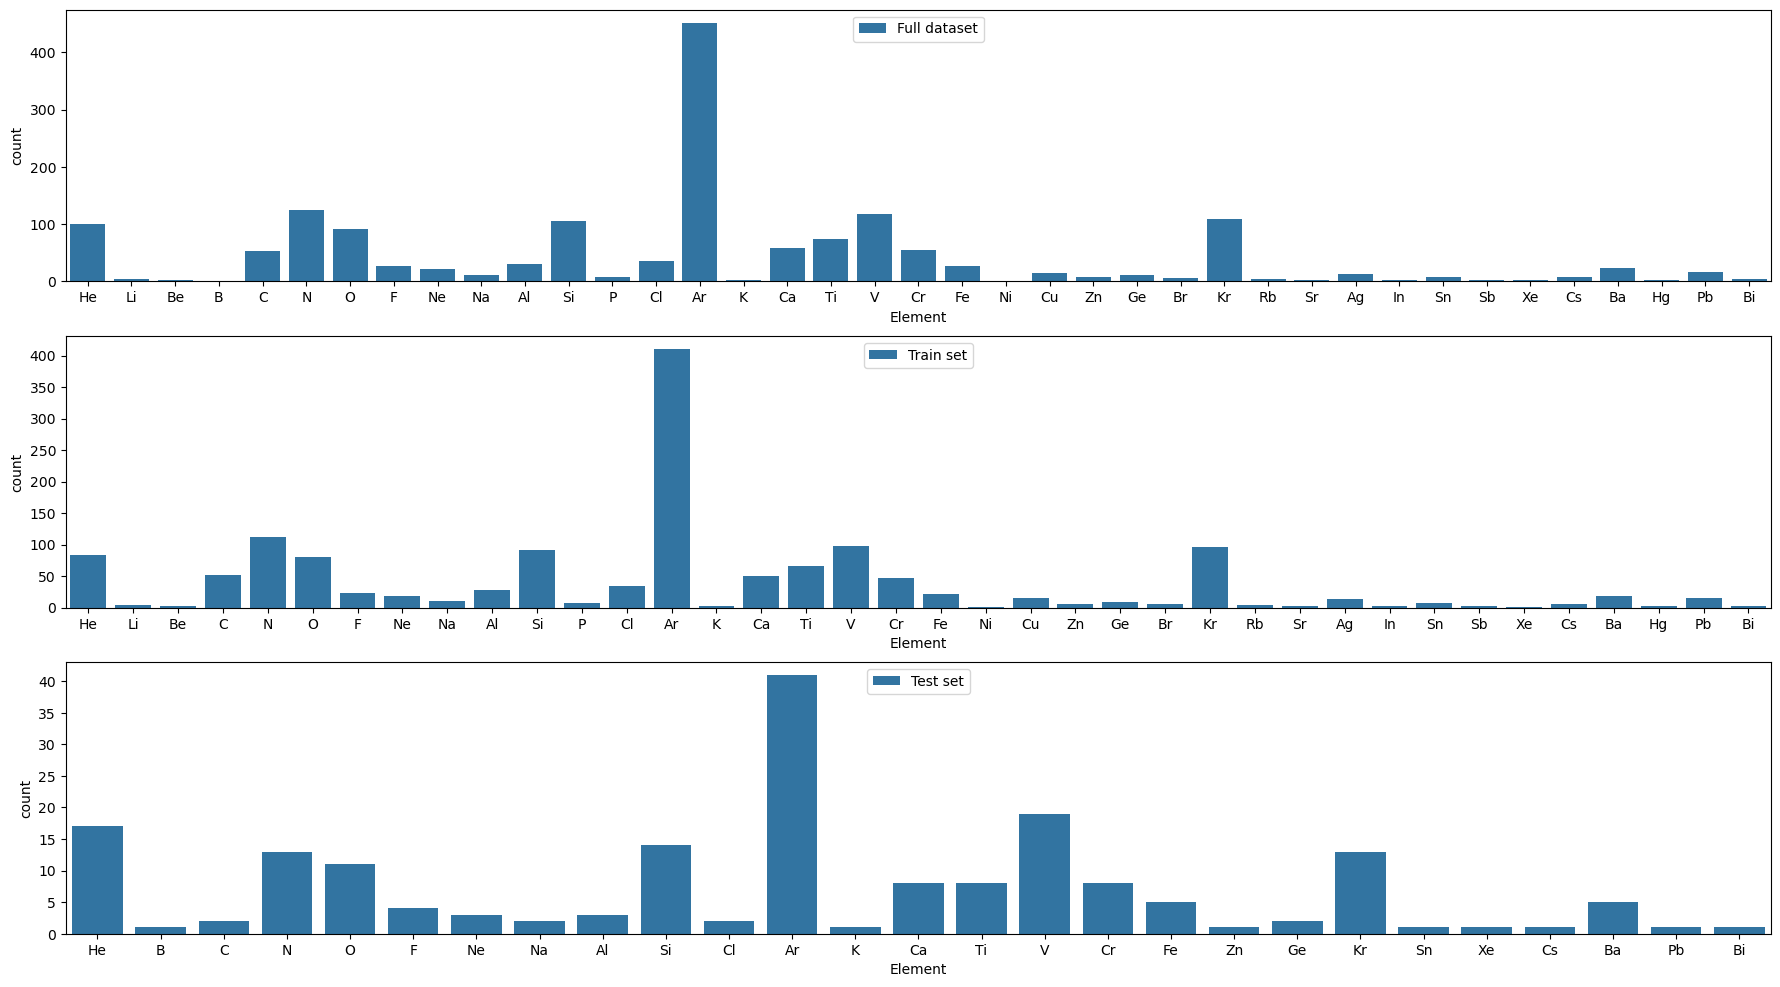

In [29]:
fig, axs = plt.subplots(3, 1, figsize = (22, 12), sharex = False)
sns.countplot(data = data_both, x = 'Element',  ax = axs[0], label = 'Full dataset')
sns.countplot(data = data_both_train.sort_values(by = ['Z number']), x = 'Element',  ax = axs[1], label = 'Train set')
sns.countplot(data = data_both_test.sort_values(by = ['Z number']), x = 'Element', ax = axs[2], label = 'Test set')

axs[0].legend(loc = 'upper center')
axs[1].legend(loc = 'upper center')
axs[2].legend(loc = 'upper center')

plt.show()

# Dataset modifications  (scaling, augmentation)

In [14]:
def unscale(y):
    return (np.exp(y) - 1) * epsilon

In [15]:
augmented_train_set = False#@param {type:"boolean"}
#@markdown Note: augmentation will be applied to width only 

#@markdown ---

#@markdown Select whether you'd like to work with 'width' or 'shift' predictions
parameter  = 'both' #@param ["width", "shift", "both"]

#@markdown ---

#@markdown You can enter any reasonable value less than 180 Angstrom to limit the upper boundary of width walues. (not recommended to change)
width_threshold =  200#@param {type:"number"}

#@markdown ---

#@markdown Scale target values by the formula: $y_{scaled} = ln(1 + \frac{y_{raw}}{\epsilon})$
scaled_target = False#@param {type:"boolean"}
epsilon = 1e-3#@param {type: "number"}

#@markdown ---

#@markdown Normalize energies by the ionization energy for each particle
normalized_energy = False#@param {type:"boolean"}

#@markdown ---

apply_scaler = False#@param {type:"boolean"}

In [16]:
def constr_train_test(parameter, augmented_train_set, scaled_target, normalized_energy, print_stats = True):
    #Applying 'width' or 'shift' or 'both' selection
    if parameter == 'width':
        X_train, Y_train = data_width_train.copy(), target_width_train.copy()
        X_test, Y_test = data_width_test.copy(), target_width_test.copy()
        X_elem, Y_elem, L_elem = data_width_elements.copy(), target_width_elements.copy(), label_width_elements.copy()
    elif parameter == 'shift':
        X_train, Y_train = data_shift_train.copy(), target_shift_train.copy()
        X_test, Y_test = data_shift_test.copy(), target_shift_test.copy()
        X_elem, Y_elem, L_elem = data_shift_elements.copy(), target_shift_elements.copy(), label_shift_elements.copy()
    elif parameter == 'both':
        X_train, Y_train = data_both_train.copy(), target_both_train.copy()
        X_test, Y_test = data_both_test.copy(), target_both_test.copy()
        X_elem, Y_elem, L_elem = data_both_elements.copy(), target_both_elements.copy(), label_both_elements.copy()
    else:
        raise NameError('Incorrect parameter name selected')

    #Handling augmentation
    if augmented_train_set:
        factor = 1.05
        X_train_aug, Y_train_aug = X_train.copy(), Y_train.copy()
        for index, row in X_train.iterrows():
            row['T'] = row['T']*factor
            X_train_aug = pd.concat([X_train_aug, row.to_frame().T], ignore_index=True)
            Y_train_aug = pd.concat([Y_train_aug, pd.Series(Y_train.loc[index])], ignore_index=True)

            row['T'] = row['T']/factor**2
            X_train_aug = pd.concat([X_train_aug, row.to_frame().T], ignore_index=True)
            Y_train_aug = pd.concat([Y_train_aug, pd.Series(Y_train.loc[index])], ignore_index=True)
        X_train_aug = X_train_aug.astype(X_train.dtypes.to_dict())    

        X_train, Y_train = X_train_aug, Y_train_aug
        X_test,  Y_test  = X_test, Y_test

    #Shuffling
    X_train = X_train.sample(frac = 1, random_state = 777)
    Y_train = Y_train.sample(frac = 1, random_state = 777)

    #Applying upper boundary to width values
#     if parameter == 'width':
#         X_train, Y_train = X_train.loc[Y_train.loc[Y_train < width_threshold].index], Y_train.loc[Y_train < width_threshold]
#         X_test,  Y_test  = X_test.loc[Y_test.loc[Y_test < width_threshold].index], Y_test.loc[Y_test < width_threshold]
#         X_elem,  Y_elem  = X_elem.loc[Y_elem.loc[Y_elem < width_threshold].index], Y_elem.loc[Y_elem < width_threshold]
#         L_elem = L_elem.loc[Y_elem.loc[Y_elem < width_threshold].index]
    
    #Applying scaling of targets
    if scaled_target:
        Y_train = np.log(1 + Y_train / epsilon)
        Y_test  = np.log(1 + Y_test / epsilon)
        Y_elem  = np.log(1 + Y_elem / epsilon)

    #Normalizing energies
    if normalized_energy:
        X_train['E lower'], X_train['E upper'] = energy_to_fraction(X_train, 'E lower'), energy_to_fraction(X_train, 'E upper')
        X_test['E lower'],  X_test['E upper']  = energy_to_fraction(X_test, 'E lower'), energy_to_fraction(X_test, 'E upper')
        X_elem['E lower'],  X_elem['E upper']  = energy_to_fraction(X_elem, 'E lower'), energy_to_fraction(X_elem, 'E upper')
        X_train['Gap to ion'] = energy_to_fraction(X_train, 'Gap to ion')
        X_test['Gap to ion'] = energy_to_fraction(X_test, 'Gap to ion')
        X_elem['Gap to ion'] = energy_to_fraction(X_elem, 'Gap to ion')

    #Removing unneccesary columns:
    X_train = X_train.drop(columns=['Element', 'Wavelength', 'Z number'])
    X_test  = X_test.drop(columns=['Element', 'Wavelength', 'Z number'])
    X_elem  = X_elem.drop(columns=['Element', 'Wavelength', 'Z number'])

    scaler = StandardScaler()
    scaler.fit(X_train)

    if print_stats:
        print(f'Selected parameter: {parameter} \n')
        if augmented_train_set:
            print(f'Total number of items with known {parameter}: {X_train.shape[0]/3 + X_test.shape[0] + X_elem.shape[0]}')
        else:
            print(f'Total number of items with known {parameter}: {X_train.shape[0] + X_test.shape[0] + X_elem.shape[0]}')

        print(f'Size of training set: {X_train.shape[0]}')
        print(f'Size of ttest set: {X_test.shape[0]}')
        print(f'Size of elements-exclusive test set: {X_elem.shape[0]}')
    
    return(X_train, Y_train, X_test, Y_test, X_elem, Y_elem, L_elem, scaler)

X_train, Y_train, X_test, Y_test, X_elem, Y_elem, L_elem, scaler = constr_train_test(parameter,
                                                                                     augmented_train_set,
                                                                                     scaled_target,
                                                                                     normalized_energy)

Selected parameter: both 

Total number of items with known both: 1782
Size of training set: 1453
Size of ttest set: 188
Size of elements-exclusive test set: 141


In [17]:
def train_ensemble(ensemble):
    glob_path = 'C:\\Users\\Alex\\Documents\\GitHub'
    models_d     = {}
    preds_d      = {}
    preds_elem_d = {}

    for item in tqdm(ensemble):
        if '_A+I_' in item:
            parameter = 'width'
            scaled_target = True
        elif '_Shift_' in item:
            parameter = 'shift'
            scaled_target = False
        elif '_Both_' in item:
            parameter = 'both'
            scaled_target = False
        else:
            raise NameError(f"Parameter for prediction must be specified in model's name: {item}")

        if 'KNN' in item:
            path = glob_path + '\\KNN'
        elif 'RF' in item:
            path = glob_path + '\\RF'
        elif 'XGB' in item:
            path = glob_path + '\\XGB'
        elif 'LightGBM' in item:
            path = glob_path + '\\LightGBM'
        elif 'CatBoost' in item:
            path = glob_path + '\\CatBoost'

        models_d_item = create_models_dict([item], path = path)

        if '_Eraw_' in item:
            normalized_energy = False
        elif '_Enorm' in item:
            normalized_energy = True

        if '_Raw_' in item:
            augmented_train_set = False
        elif '_Aug_' in item:
            augmented_train_set = True

        if '_No' in item:
            apply_scaler = False
        elif '_Scaler' in item:
            apply_scaler = True
        
        X_train, Y_train, X_test, Y_test, X_elem, Y_elem, L_elem, scaler = constr_train_test(parameter,
                                                                                             augmented_train_set,
                                                                                             scaled_target = scaled_target,
                                                                                             normalized_energy = normalized_energy,
                                                                                             print_stats = False)
        if apply_scaler:
            preds, preds_elem = plot_model_prediction(models_d_item,
                                                      scaler.transform(X_train), Y_train,
                                                      scaler.transform(X_test), Y_test,
                                                      scaler.transform(X_elem), Y_elem, L_elem, 
                                                      plot = False)
        else:
            preds, preds_elem = plot_model_prediction(models_d_item,
                                                      X_train, Y_train,
                                                      X_test, Y_test,
                                                      X_elem, Y_elem, L_elem, 
                                                      plot = False)
        preds_d = preds_d | preds
        preds_elem_d = preds_elem_d | preds_elem
    
    return preds_d, preds_elem_d  

# Testing individual models and ensembles

## Test set (Width)

In [ ]:
#Statistics for Test set
models = [
    'XGB_A+I_Eraw_Raw_No',
    'CatBoost_A+I_Enorm_Raw_No',
    'LightGBM_A+I_Enorm_Raw_Scaler',
    'LightGBM_A+I_Eraw_Raw_No',
    'XGB_A+I_Enorm_Aug_No',
]

preds_d, preds_elem_d = train_ensemble(models)

pred = np.zeros(preds_d[models[0]].shape)
pred_elem = np.zeros(preds_elem_d[models[0]].shape)
for key in preds_d.keys():
    pred += preds_d[key]
    pred_elem += preds_elem_d[key]
pred /= len(preds_d)
pred_elem /= len(preds_d)
    

print(root_mean_squared_error(Y_test, pred))
MREs = (np.abs(unscale(Y_test) - unscale(pred.reshape(pred.shape[0]))) / unscale(Y_test))*100
print(MREs.mean())

X3, Y3 = X_test, Y_test
fig, ax = plt.subplots(1, 2, figsize = (10, 4))
ax[0].plot(unscale(Y_test), MREs, 'r.')
ax[0].hlines(MREs.mean(), np.amin(unscale(Y_test)), np.amax(unscale(Y_test)), label = 'Mean prediction error')
ax[0].hlines(34.438211, np.amin(unscale(Y_test)), np.amax(unscale(Y_test)), ls = '-', color = 'k', label = 'Mean data error')
ax[0].hlines(23., np.amin(unscale(Y_test)), np.amax(unscale(Y_test)), ls = '--', color = 'k', label = '25% and 75% percentiles')
ax[0].hlines(40., np.amin(unscale(Y_test)), np.amax(unscale(Y_test)), ls = '--', color = 'k')
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].legend()
ax[0].set_xlabel('True Stark width (A)')
ax[0].set_ylabel('Prediction relative error (%)')

ax[1].plot(unscale(Y_test), unscale(preds_d[models[0]].reshape(preds_d[models[0]].shape[0])), 'r.')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].plot([np.amin(unscale(Y_test)), np.amax(unscale(Y_test))],
           [np.amin(unscale(Y_test)), np.amax(unscale(Y_test))], color = 'b', ls = '--')
ax[1].set_xlabel('True Stark width (A)')
ax[1].set_ylabel('Predicted Stark width (A)')
# plt.savefig(f'Ensemble_1 Test predictions.svg', transparent = True, format = 'svg')
plt.show()

## Elements set (Width)

In [ ]:
#Statistics for Elements set
models = [
    'XGB_A+I_Eraw_Raw_No',
    'CatBoost_A+I_Enorm_Raw_No',
    'LightGBM_A+I_Enorm_Raw_Scaler',
    'LightGBM_A+I_Eraw_Raw_No',
    'XGB_A+I_Enorm_Aug_No',
    ]


preds_d, preds_elem_d = train_ensemble(models)

pred = np.zeros(preds_d[models[0]].shape)
pred_elem = np.zeros(preds_elem_d[models[0]].shape)
for key in preds_d.keys():
    pred += preds_d[key]
    pred_elem += preds_elem_d[key]
pred /= len(preds_d)
pred_elem /= len(preds_d)
    
print(root_mean_squared_error(Y_elem, pred_elem))
MREs = (np.abs(unscale(Y_elem) - unscale(pred_elem.reshape(pred_elem.shape[0]))) / unscale(Y_elem))*100
print(MREs.mean())

fig, ax = plt.subplots(1, 2, figsize = (10, 4))
ax[0].plot(unscale(Y_elem), MREs, 'r.')
ax[0].hlines(MREs.mean(), np.amin(unscale(Y_elem)), np.amax(unscale(Y_elem)), label = 'Mean prediction error')
ax[0].hlines(34.438211, np.amin(unscale(Y_elem)), np.amax(unscale(Y_elem)), ls = '-', color = 'k', label = 'Mean data error')
ax[0].hlines(23., np.amin(unscale(Y_elem)), np.amax(unscale(Y_elem)), ls = '--', color = 'k', label = '25% and 75% percentiles')
ax[0].hlines(40., np.amin(unscale(Y_elem)), np.amax(unscale(Y_elem)), ls = '--', color = 'k')
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].legend()
ax[0].set_xlabel('True Stark width (A)')
ax[0].set_ylabel('Prediction relative error (%)')

ax[1].plot(unscale(Y_elem), unscale(preds_elem_d[models[0]].reshape(preds_elem_d[models[0]].shape[0])), 'r.')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].plot([np.amin(unscale(Y_elem)), np.amax(unscale(Y_elem))],
           [np.amin(unscale(Y_elem)), np.amax(unscale(Y_elem))], color = 'b', ls = '--')
ax[1].set_xlabel('True Stark width (A)')
ax[1].set_ylabel('Predicted Stark width (A)')
# plt.savefig(f'Ensemble_1 Elements predictions.svg', transparent = True, format = 'svg')
plt.show()

## Shift prediction (both test and elements)

In [ ]:
#Statistics for Shift Test set
models = [
    'XGB_Shift_Eraw_Raw_Scaler',
    ]

preds_d, preds_elem_d = train_ensemble(models)

pred = np.zeros(preds_d[models[0]].shape)
pred_elem = np.zeros(preds_elem_d[models[0]].shape)
for key in preds_d.keys():
    pred += preds_d[key]
    pred_elem += preds_elem_d[key]
pred /= len(preds_d)
pred_elem /= len(preds_d)

print(f'{root_mean_squared_error(Y_test, pred):.4f}')
MREs = ((np.abs(Y_test - pred.reshape(pred.shape[0])) / np.abs(Y_test))*100)
MREs.replace(np.inf, np.nan, inplace=True)
print(f'{MREs.mean():.2f}')

fig, ax = plt.subplots(1, 2, figsize = (10, 4))
ax[0].plot(Y_test, MREs, 'r.')
ax[0].hlines(MREs.mean(), np.amin(Y_test), np.amax(Y_test), label = 'Mean prediction error')
ax[0].hlines(37.619792, np.amin(Y_test), np.amax(Y_test), ls = '-', color = 'k', label = 'Mean data error')
ax[0].hlines(23., np.amin(Y_test), np.amax(Y_test), ls = '--', color = 'k', label = '25% and 75% percentiles')
ax[0].hlines(40., np.amin(Y_test), np.amax(Y_test), ls = '--', color = 'k')
ax[0].set_yscale('log')
ax[0].legend()
ax[0].set_xlabel('True Stark shift (A)')
ax[0].set_ylabel('Prediction relative error (%)')

ax[1].plot(Y_test, pred.reshape(pred.shape[0]), 'r.')
ax[1].plot([np.amin(Y_test), np.amax(Y_test)],
           [np.amin(Y_test), np.amax(Y_test)], color = 'b', ls = '--')
ax[1].set_xlabel('True Stark shift (A)')
ax[1].set_ylabel('Predicted Stark shift (A)')
# plt.savefig(f'RF E_raw Aug No Test predictions Shift.svg', transparent = True, format = 'svg')
plt.show()

print(f'{root_mean_squared_error(Y_elem, pred_elem):.4f}')
MREs = (np.abs(Y_elem - pred_elem.reshape(pred_elem.shape[0])) / np.abs(Y_elem))*100
MREs.replace(np.inf, np.nan, inplace=True)
print(f'{MREs.mean():.2f}')

fig, ax = plt.subplots(1, 2, figsize = (10, 4))
ax[0].plot(Y_elem, MREs, 'r.')
ax[0].hlines(MREs.mean(), np.amin(Y_elem), np.amax(Y_elem), label = 'Mean prediction error')
ax[0].hlines(37.619792, np.amin(Y_elem), np.amax(Y_elem), ls = '-', color = 'k', label = 'Mean data error')
ax[0].hlines(23., np.amin(Y_elem), np.amax(Y_elem), ls = '--', color = 'k', label = '25% and 75% percentiles')
ax[0].hlines(40., np.amin(Y_elem), np.amax(Y_elem), ls = '--', color = 'k')
ax[0].set_yscale('log')
ax[0].legend()
ax[0].set_xlabel('True Stark shift (A)')
ax[0].set_ylabel('Prediction relative error (%)')

ax[1].plot(Y_elem, pred_elem.reshape(pred_elem.shape[0]), 'r.')
ax[1].plot([np.amin(Y_elem), np.amax(Y_elem)],
           [np.amin(Y_elem), np.amax(Y_elem)], color = 'b', ls = '--')
ax[1].set_xlabel('True Stark shift (A)')
ax[1].set_ylabel('Predicted Stark shift (A)')
# plt.savefig(f'XGB E_raw Raw No Test predictions.svg', transparent = True, format = 'svg')
plt.show()

In [ ]:
#Statistics for Shift Test set
models = [
    'XGB_Both_Eraw_Raw_Scaler',
    ]

preds_d, preds_elem_d = train_ensemble(models)

pred = np.zeros(preds_d[models[0]].shape)
pred_elem = np.zeros(preds_elem_d[models[0]].shape)
for key in preds_d.keys():
    pred += preds_d[key]
    pred_elem += preds_elem_d[key]
pred /= len(preds_d)
pred_elem /= len(preds_d)

print(f'{root_mean_squared_error(Y_test, pred):.4f}')
MREs = ((np.abs(Y_test - pred.reshape(pred.shape[0])) / np.abs(Y_test))*100)
MREs.replace(np.inf, np.nan, inplace=True)
print(f'{MREs.mean():.2f}')

fig, ax = plt.subplots(1, 2, figsize = (10, 4))
ax[0].plot(Y_test, MREs, 'r.')
ax[0].hlines(MREs.mean(), np.amin(Y_test), np.amax(Y_test), label = 'Mean prediction error')
ax[0].hlines(37.619792, np.amin(Y_test), np.amax(Y_test), ls = '-', color = 'k', label = 'Mean data error')
ax[0].hlines(23., np.amin(Y_test), np.amax(Y_test), ls = '--', color = 'k', label = '25% and 75% percentiles')
ax[0].hlines(40., np.amin(Y_test), np.amax(Y_test), ls = '--', color = 'k')
ax[0].set_yscale('log')
ax[0].legend()
ax[0].set_xlabel('True Stark shift (A)')
ax[0].set_ylabel('Prediction relative error (%)')

ax[1].plot(Y_test, pred.reshape(pred.shape[0]), 'r.')
ax[1].plot([np.amin(Y_test), np.amax(Y_test)],
           [np.amin(Y_test), np.amax(Y_test)], color = 'b', ls = '--')
ax[1].set_xlabel('True Stark shift (A)')
ax[1].set_ylabel('Predicted Stark shift (A)')
# plt.savefig(f'RF E_raw Aug No Test predictions Shift.svg', transparent = True, format = 'svg')
plt.show()

print(f'{root_mean_squared_error(Y_elem, pred_elem):.4f}')
MREs = (np.abs(Y_elem - pred_elem.reshape(pred_elem.shape[0])) / np.abs(Y_elem))*100
MREs.replace(np.inf, np.nan, inplace=True)
print(f'{MREs.mean():.2f}')

fig, ax = plt.subplots(1, 2, figsize = (10, 4))
ax[0].plot(Y_elem, MREs, 'r.')
ax[0].hlines(MREs.mean(), np.amin(Y_elem), np.amax(Y_elem), label = 'Mean prediction error')
ax[0].hlines(37.619792, np.amin(Y_elem), np.amax(Y_elem), ls = '-', color = 'k', label = 'Mean data error')
ax[0].hlines(23., np.amin(Y_elem), np.amax(Y_elem), ls = '--', color = 'k', label = '25% and 75% percentiles')
ax[0].hlines(40., np.amin(Y_elem), np.amax(Y_elem), ls = '--', color = 'k')
ax[0].set_yscale('log')
ax[0].legend()
ax[0].set_xlabel('True Stark shift (A)')
ax[0].set_ylabel('Prediction relative error (%)')

ax[1].plot(Y_elem, pred_elem.reshape(pred_elem.shape[0]), 'r.')
ax[1].plot([np.amin(Y_elem), np.amax(Y_elem)],
           [np.amin(Y_elem), np.amax(Y_elem)], color = 'b', ls = '--')
ax[1].set_xlabel('True Stark shift (A)')
ax[1].set_ylabel('Predicted Stark shift (A)')
# plt.savefig(f'XGB E_raw Raw No Test predictions.svg', transparent = True, format = 'svg')
plt.show()

# Ensemble of models

  0%|          | 0/20 [00:00<?, ?it/s]

RF_Both_Eraw_Raw_Scaler
0.15579946775783743
44.94377820441473


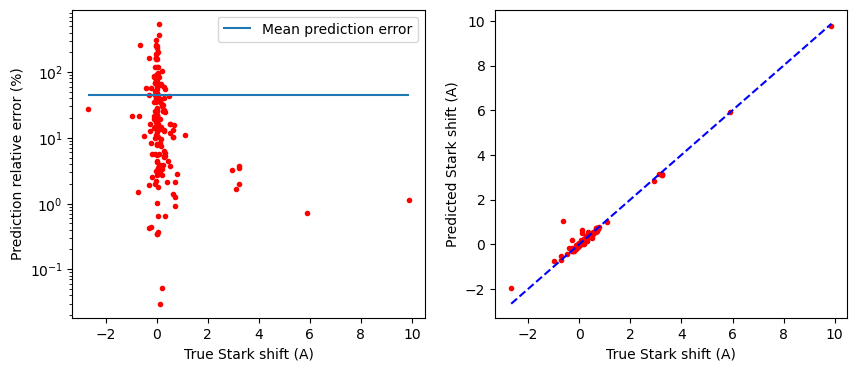

0.8168920591944716
197.68327236235785


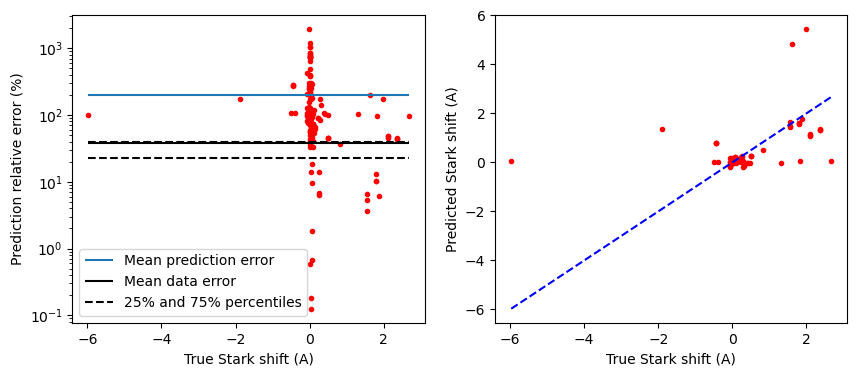

  5%|▌         | 1/20 [00:30<09:37, 30.41s/it]

RF_Both_Eraw_Raw_No
0.16480653821690594
44.587115009549805


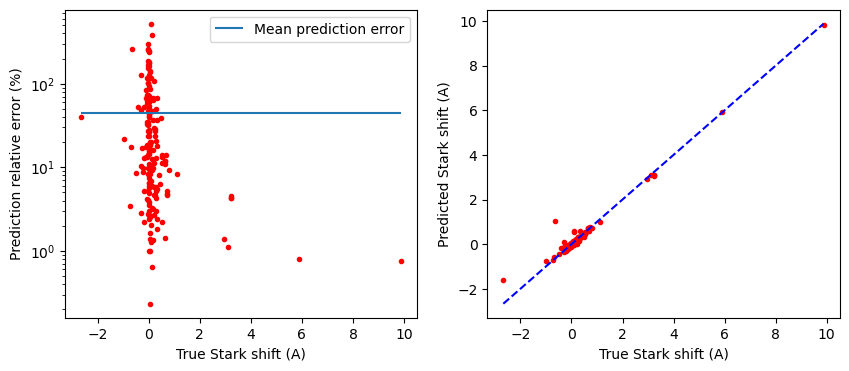

0.8610432657487816
129.03325380438622


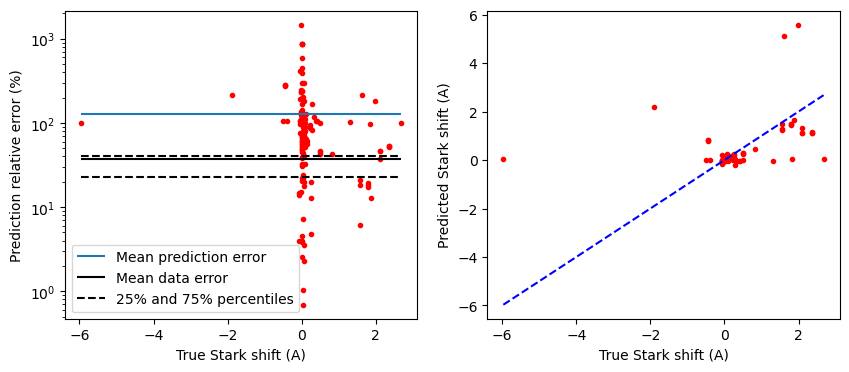

 10%|█         | 2/20 [00:43<06:04, 20.27s/it]

RF_Both_Eraw_Aug_Scaler
0.15972514586796271
43.48546156403214


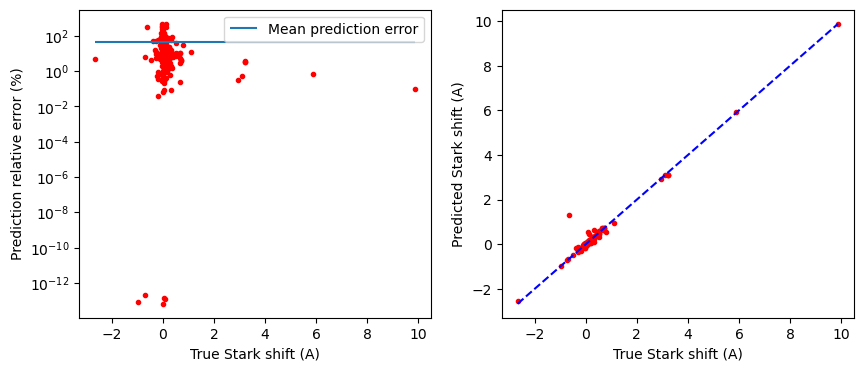

0.8380749122458261
257.99289872593397


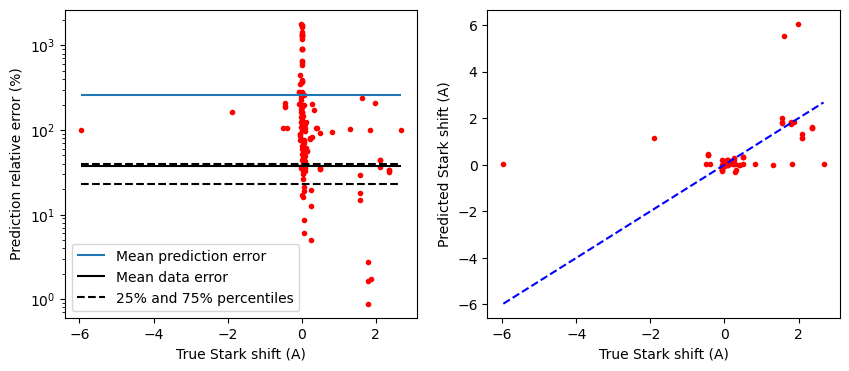

 15%|█▌        | 3/20 [03:19<23:17, 82.20s/it]

RF_Both_Eraw_Aug_No
0.1471798662069568
44.134596390391735


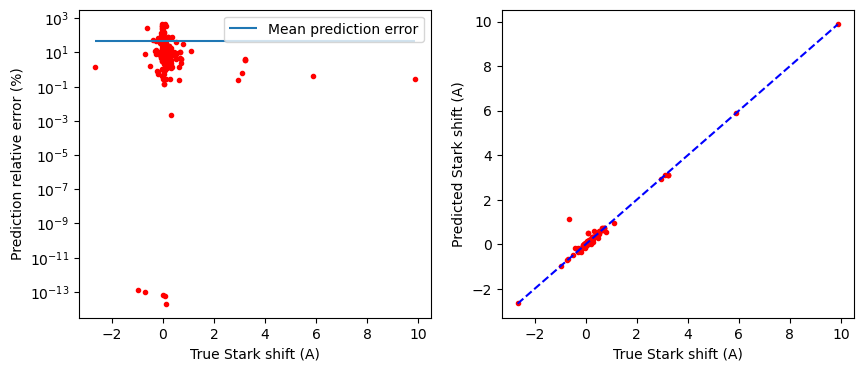

0.829710969841069
130.19539957272423


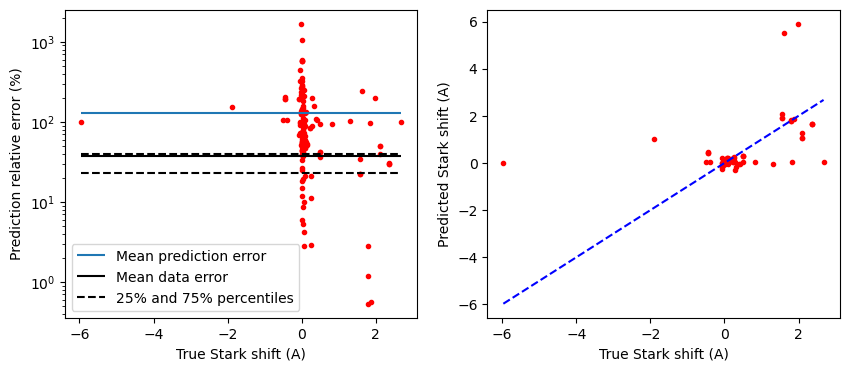

 20%|██        | 4/20 [04:56<23:25, 87.86s/it]

RF_Both_Enorm_Raw_Scaler
0.18100827384643442
56.5678868967623


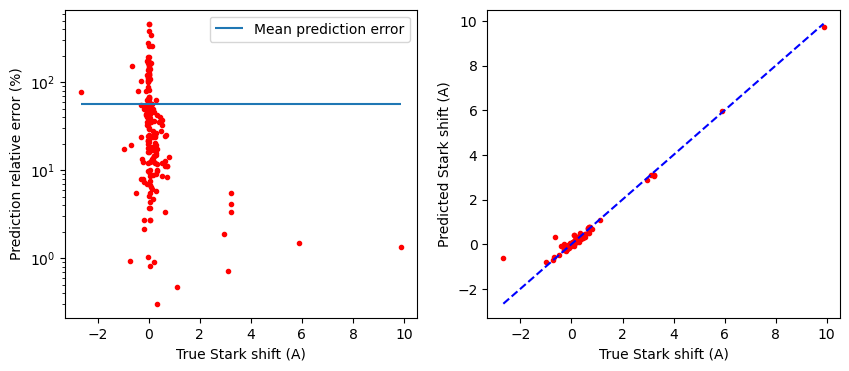

1.1727022448454882
178.39303773581594


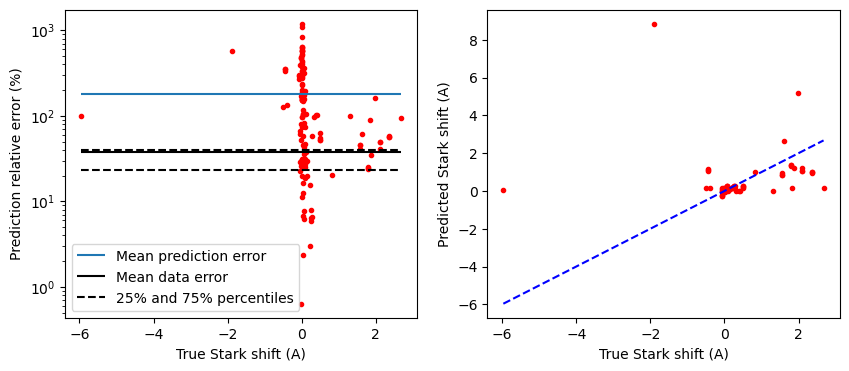

 25%|██▌       | 5/20 [04:59<14:20, 57.35s/it]

RF_Both_Enorm_Raw_No
0.1664967037645007
43.67331036403143


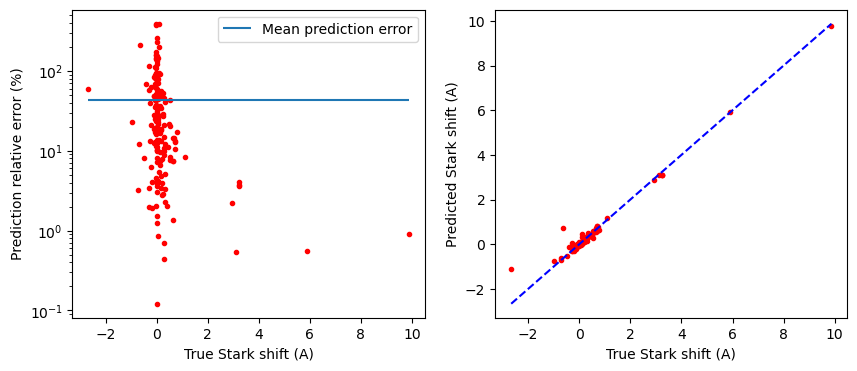

1.1892302481031007
184.60393217654945


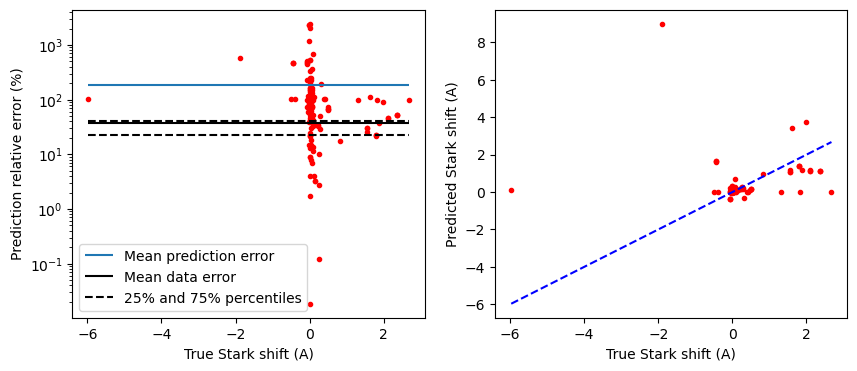

 30%|███       | 6/20 [05:14<10:03, 43.09s/it]

RF_Both_Enorm_Aug_Scaler
0.07108891991325579
35.13113781166195


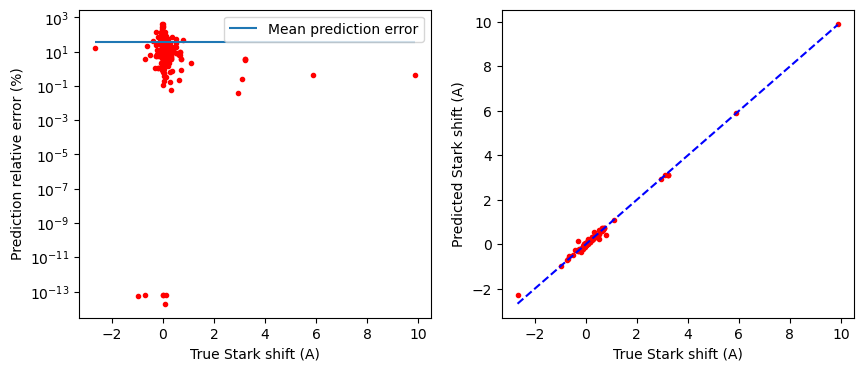

1.2653328268069162
179.47807190850992


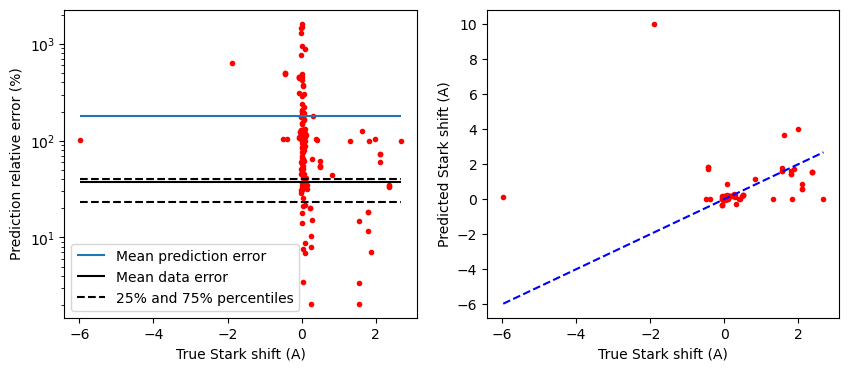

 35%|███▌      | 7/20 [06:23<11:09, 51.51s/it]

RF_Both_Enorm_Aug_No
0.06943214372404738
33.6572581600871


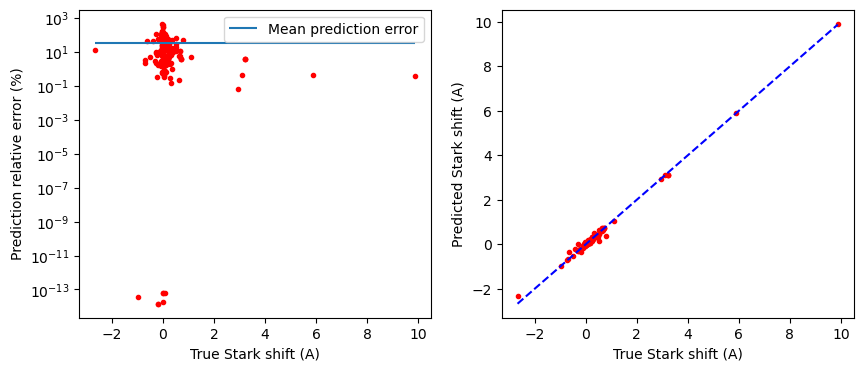

1.2952669216858004
181.81940964059476


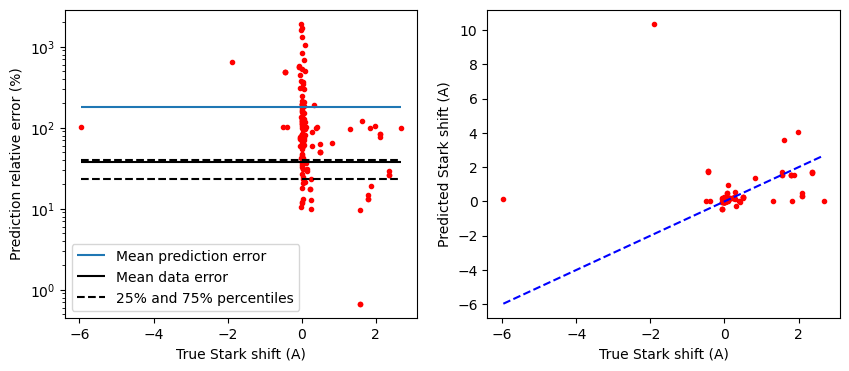

 40%|████      | 8/20 [07:08<09:52, 49.37s/it]

KNN_Both_Enorm_Raw_Scaler
0.10089086686399282
52.30056857309082


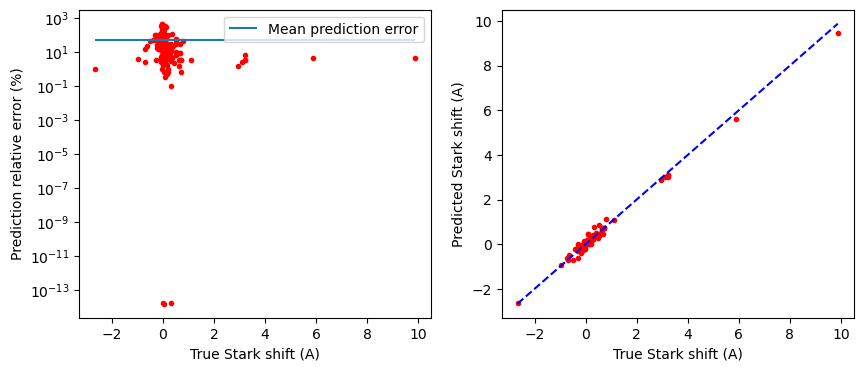

0.8806624851603672
479.017993590538


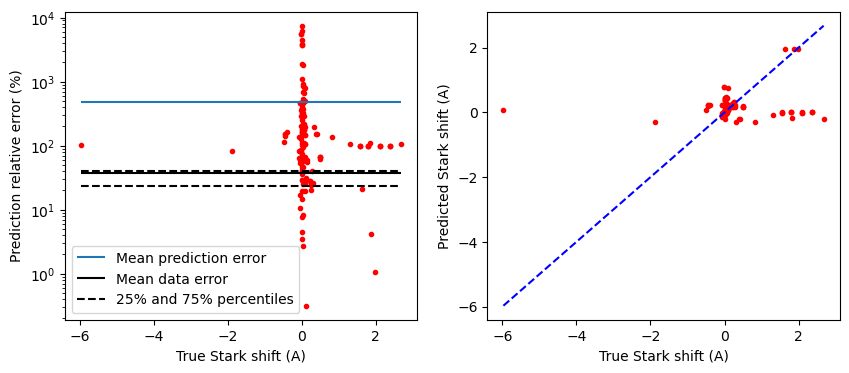

 45%|████▌     | 9/20 [07:11<06:24, 34.98s/it]

KNN_Both_Enorm_Aug_Scaler
0.10071174195667855
45.7231868980639


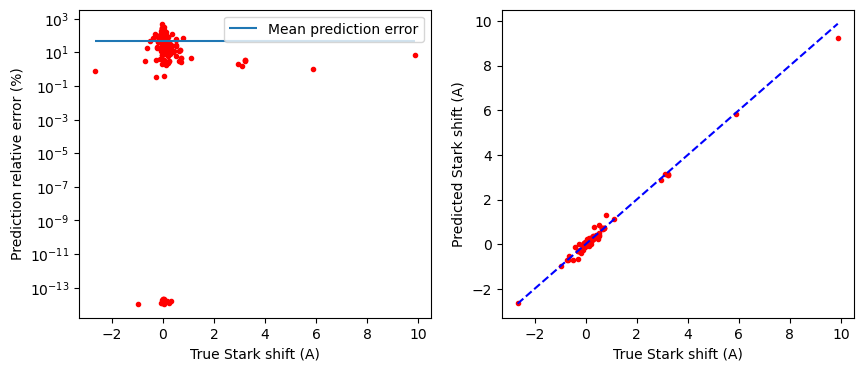

0.8776204180958329
357.2898131910078


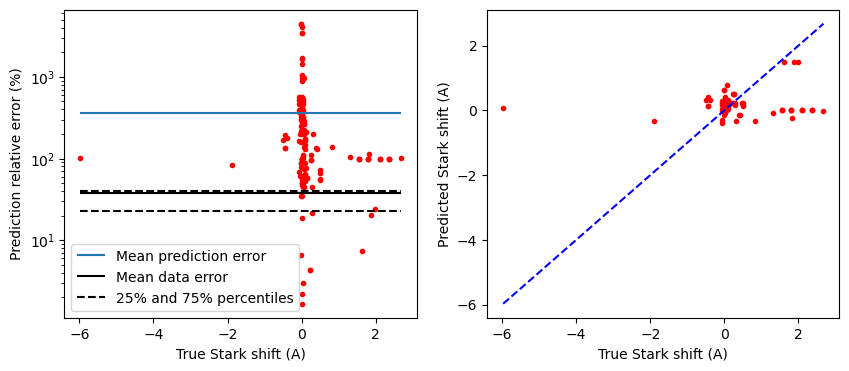

 50%|█████     | 10/20 [07:22<04:34, 27.46s/it]

XGB_Both_Eraw_Raw_Scaler
0.11614638192231108
46.905661288996875


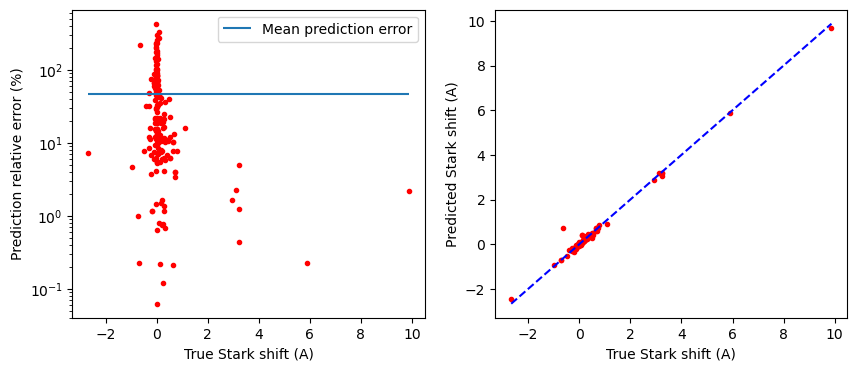

0.815561038946664
135.8574133924463


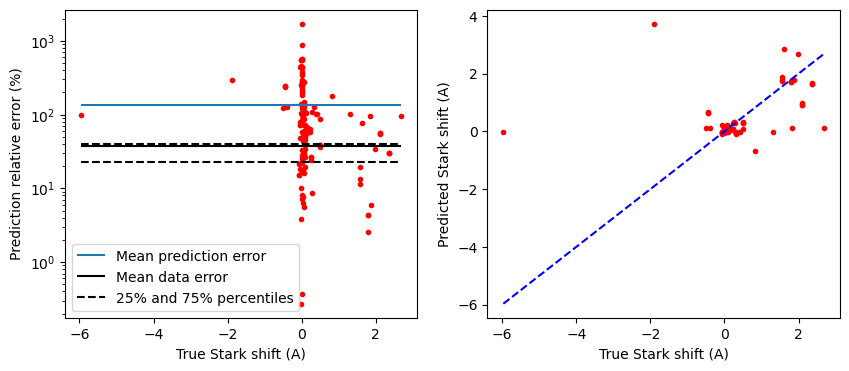

 55%|█████▌    | 11/20 [07:22<02:53, 19.24s/it]

XGB_Both_Eraw_Aug_Scaler
0.15595984813614427
43.60172601979198


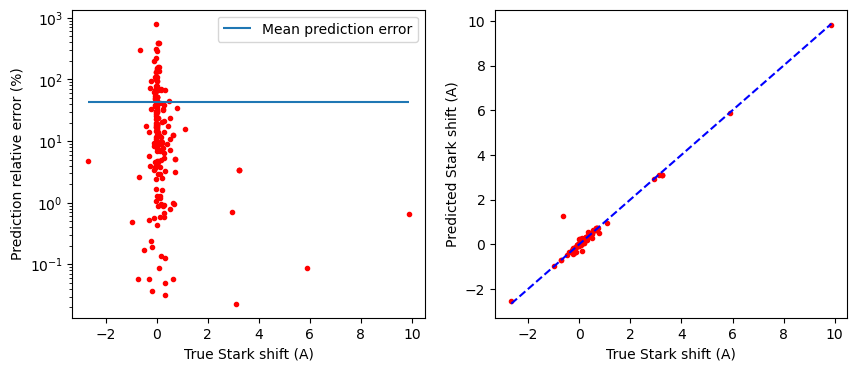

1.23447603212004
183.86813926033028


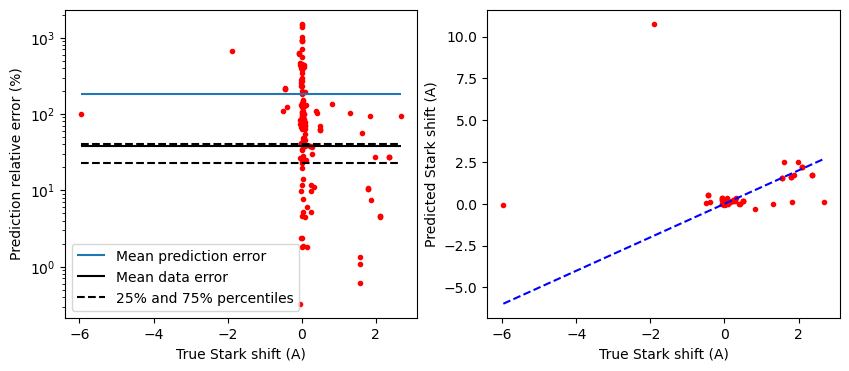

 60%|██████    | 12/20 [07:26<01:56, 14.57s/it]

XGB_Both_Eraw_Aug_No
0.14750239769433646
41.88936479346358


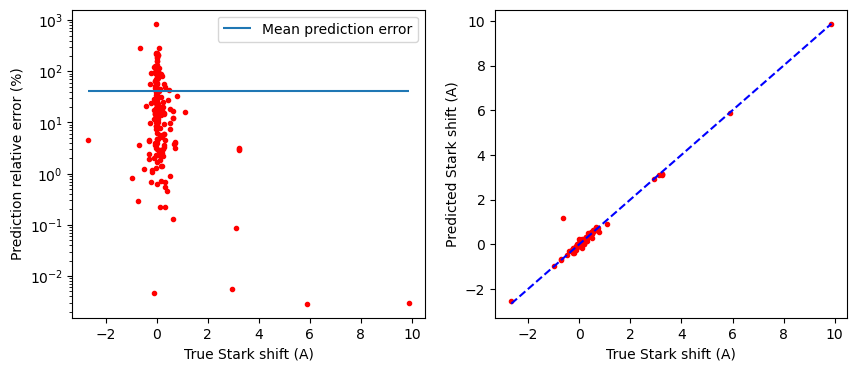

1.237284331171885
357.4767735393091


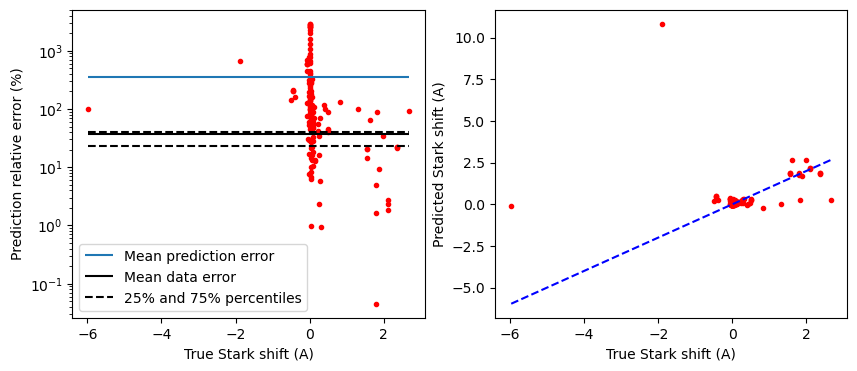

 65%|██████▌   | 13/20 [07:30<01:19, 11.32s/it]

XGB_Both_Enorm_Raw_Scaler
0.12916619705647642
41.21054963250275


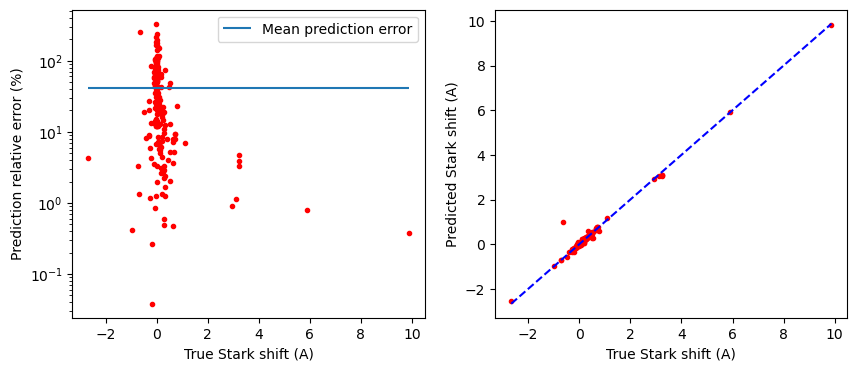

1.2889313507072775
224.52437178957842


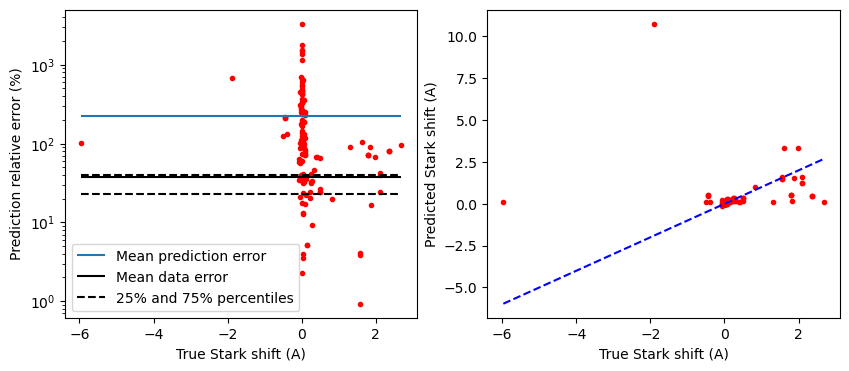

 70%|███████   | 14/20 [07:33<00:52,  8.78s/it]

XGB_Both_Enorm_Raw_No
0.09156377797831058
34.609530945555846


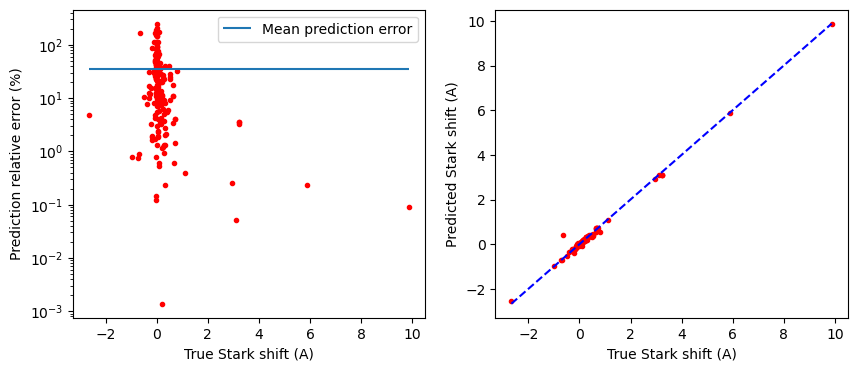

1.2669782980948308
201.6257094234543


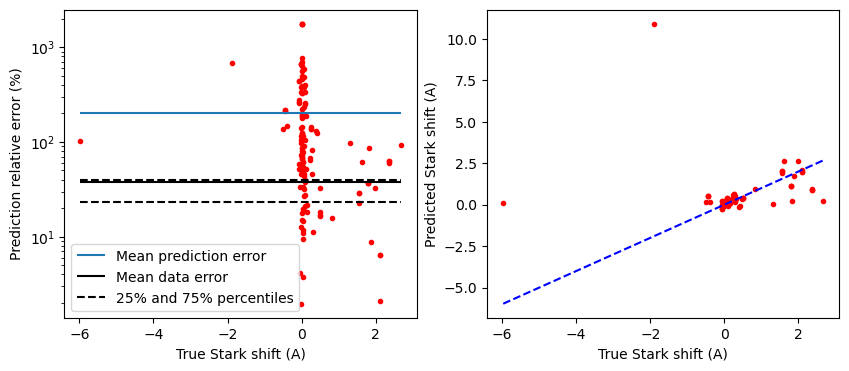

 75%|███████▌  | 15/20 [07:37<00:36,  7.23s/it]

CatBoost_Both_Eraw_Aug_Scaler
0.11498115771819638
49.69330113163149


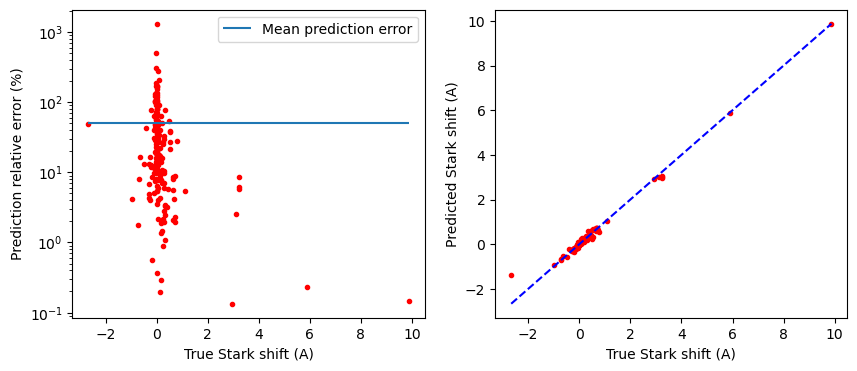

1.095642447458787
515.436182506328


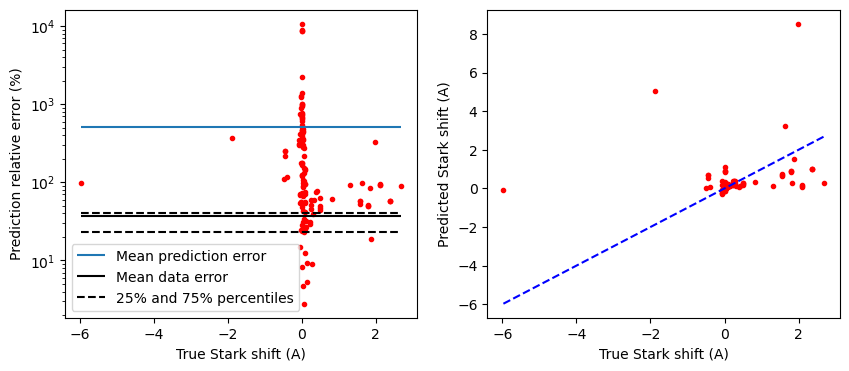

 80%|████████  | 16/20 [07:42<00:26,  6.72s/it]

CatBoost_Both_Enorm_Raw_Scaler
0.06733407169949047
50.21655953792773


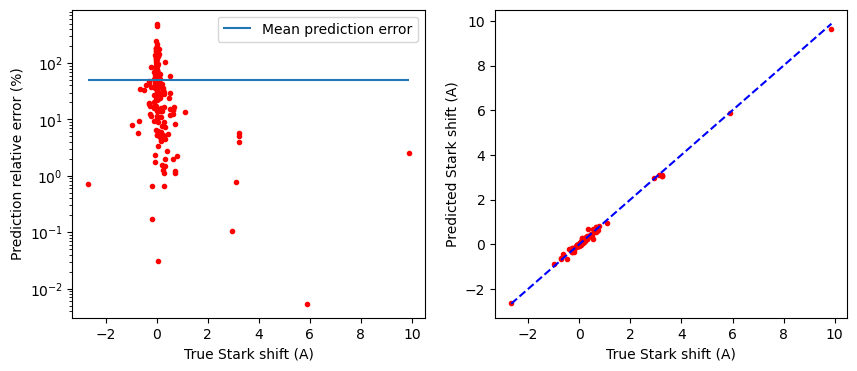

0.9608699274621203
609.574131292411


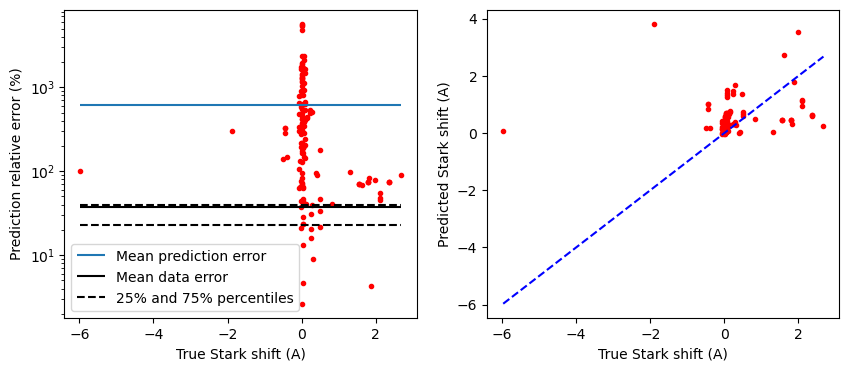

 85%|████████▌ | 17/20 [08:18<00:46, 15.61s/it]

CatBoost_Both_Enorm_Raw_No
0.06786299291806651
50.52973766810296


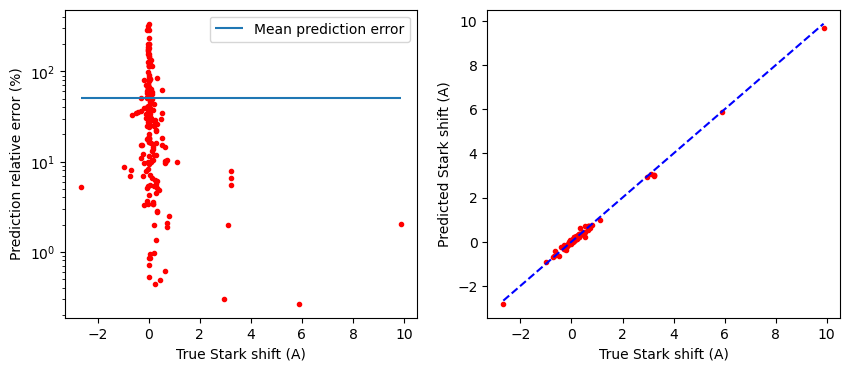

0.9545135259710893
533.8741301907088


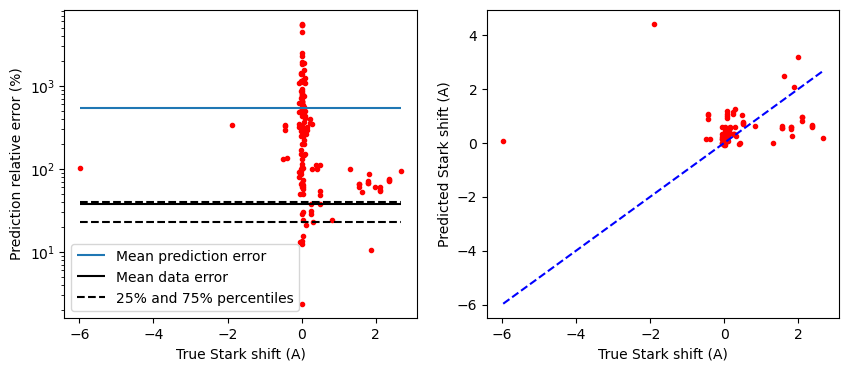

 90%|█████████ | 18/20 [08:55<00:43, 21.94s/it]

CatBoost_Both_Enorm_Aug_Scaler
0.08011171442422498
49.86322764325082


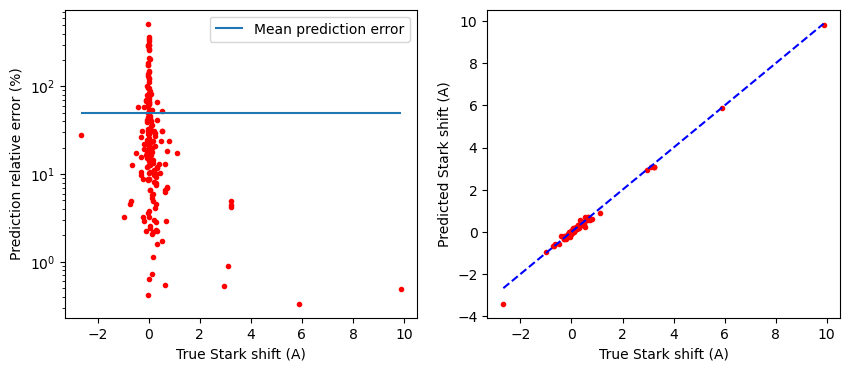

1.0096572177620777
294.5136507135353


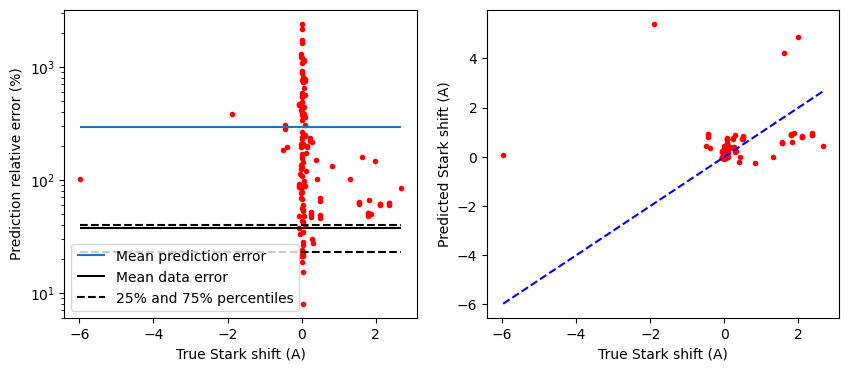

 95%|█████████▌| 19/20 [09:09<00:19, 19.39s/it]

CatBoost_Both_Enorm_Aug_No
0.15859111614068505
48.42412578919924


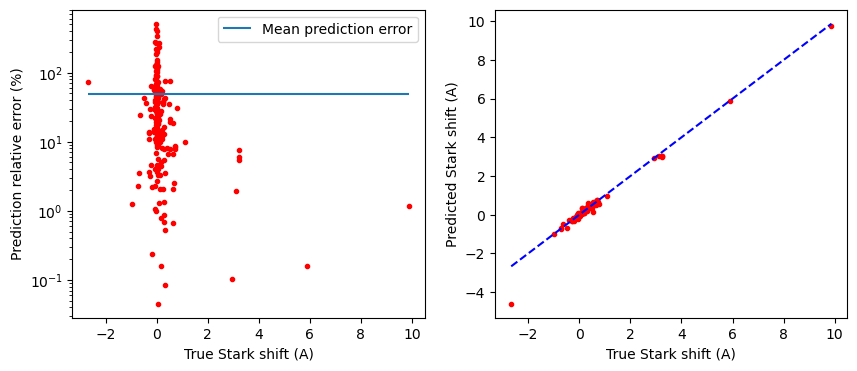

1.1059619073175944
379.6562570267066


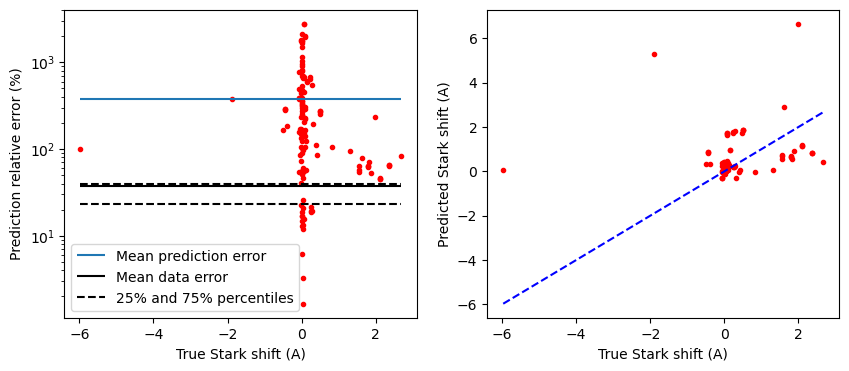

100%|██████████| 20/20 [09:22<00:00, 28.12s/it]


In [125]:
models = [
       'RF_Both_Eraw_Raw_Scaler',
       'RF_Both_Eraw_Raw_No',
       'RF_Both_Eraw_Aug_Scaler',
       'RF_Both_Eraw_Aug_No',
       'RF_Both_Enorm_Raw_Scaler',
       'RF_Both_Enorm_Raw_No',
       'RF_Both_Enorm_Aug_Scaler',
       'RF_Both_Enorm_Aug_No',
#        'KNN_Both_Eraw_Raw_Scaler',
#        'KNN_Both_Eraw_Raw_No',
#        'KNN_Both_Eraw_Aug_Scaler',
#        'KNN_Both_Eraw_Aug_No',
       'KNN_Both_Enorm_Raw_Scaler',
#        'KNN_Both_Enorm_Raw_No',
       'KNN_Both_Enorm_Aug_Scaler',
#        'KNN_Both_Enorm_Aug_No',
       'XGB_Both_Eraw_Raw_Scaler',
#        'XGB_Both_Eraw_Raw_No',
       'XGB_Both_Eraw_Aug_Scaler',
       'XGB_Both_Eraw_Aug_No',
       'XGB_Both_Enorm_Raw_Scaler',
       'XGB_Both_Enorm_Raw_No',
#        'XGB_Both_Enorm_Aug_Scaler',
#        'XGB_Both_Enorm_Aug_No',
#        'LightGBM_Both_Eraw_Raw_Scaler',
#        'LightGBM_Both_Eraw_Raw_No',
#        'LightGBM_Both_Eraw_Aug_Scaler',
#        'LightGBM_Both_Eraw_Aug_No',
#        'LightGBM_Both_Enorm_Raw_Scaler',
#        'LightGBM_Both_Enorm_Raw_No',
#        'LightGBM_Both_Enorm_Aug_Scaler',
#        'LightGBM_Both_Enorm_Aug_No',
#        'CatBoost_Both_Eraw_Raw_Scaler',
#        'CatBoost_Both_Eraw_Raw_No',
       'CatBoost_Both_Eraw_Aug_Scaler',
#        'CatBoost_Both_Eraw_Aug_No',
       'CatBoost_Both_Enorm_Raw_Scaler',
       'CatBoost_Both_Enorm_Raw_No',
       'CatBoost_Both_Enorm_Aug_Scaler',
       'CatBoost_Both_Enorm_Aug_No',
]

# parameter = 'width'
# augmented_train_set = False
# normalized_energy = False
# X_train, Y_train, X_test, Y_test, X_elem, Y_elem, L_elem, scaler = constr_train_test(parameter,
#                                                                                          augmented_train_set,
#                                                                                          scaled_target=True,
#                                                                                          normalized_energy = normalized_energy,
#                                                                                          print_stats = False)

glob_path = 'C:\\Users\\Alex\\Documents\\GitHub'
models_d     = {}
preds_d      = {}
preds_elem_d = {}

for item in tqdm(models):
    if '_A+I_' in item:
        parameter = 'width'
    elif '_Shift_' in item:
        parameter = 'shift'
    elif '_Both_' in item:
        parameter = 'both'
    else:
        raise NameError(f"Parameter for prediction must be specified in model's name: {item}")
    
    if 'KNN' in item:
        path = glob_path + '\\KNN'
    elif 'RF' in item:
        path = glob_path + '\\RF'
    elif 'XGB' in item:
        path = glob_path + '\\XGB'
    elif 'LightGBM' in item:
        path = glob_path + '\\LightGBM'
    elif 'CatBoost' in item:
        path = glob_path + '\\CatBoost'
    
    models_d_item = create_models_dict([item], path = path)
    models_d = models_d | models_d_item
    
    if '_Eraw_' in item:
        normalized_energy = False
    elif '_Enorm' in item:
        normalized_energy = True
    
    if '_Raw_' in item:
        augmented_train_set = False
    elif '_Aug_' in item:
        augmented_train_set = True
    
    if '_No' in item:
        apply_scaler = False
    elif '_Scaler' in item:
        apply_scaler = True
        
    X_train, Y_train, X_test, Y_test, X_elem, Y_elem, L_elem, scaler = constr_train_test(parameter,
                                                                                         augmented_train_set,
                                                                                         scaled_target=False,
                                                                                         normalized_energy = normalized_energy,
                                                                                         print_stats = False)
    
    if apply_scaler:
        preds, preds_elem = plot_model_prediction(models_d_item,
                                                  scaler.transform(X_train), Y_train,
                                                  scaler.transform(X_test), Y_test,
                                                  scaler.transform(X_elem), Y_elem, L_elem, 
                                                  plot = False)
    else:
        preds, preds_elem = plot_model_prediction(models_d_item,
                                                  X_train, Y_train,
                                                  X_test, Y_test,
                                                  X_elem, Y_elem, L_elem, 
                                                  plot = False)

        
    print(item)
    print(root_mean_squared_error(Y_test, preds[item]))
    #For width
#     MREs = (np.abs(Y_test - unscale(preds[item])) / unscale(Y_test))*100
    #For shift
    MREs = (np.abs(Y_test - preds[item]) / np.abs(Y_test))*100
    MREs.replace(np.inf, np.nan, inplace=True)
    print(MREs.mean())

    
    #For width
#     fig, ax = plt.subplots(1, 2, figsize = (10, 4))
#     ax[0].plot(unscale(Y_test), MREs, 'r.')
#     ax[0].hlines(MREs.mean(), np.amin(unscale(Y_test)), np.amax(unscale(Y_test)), label = 'Mean prediction error')
#     ax[0].hlines(34.438211, np.amin(unscale(Y_test)), np.amax(unscale(Y_test)), ls = '-', color = 'k', label = 'Mean data error')
#     ax[0].hlines(23., np.amin(unscale(Y_test)), np.amax(unscale(Y_test)), ls = '--', color = 'k', label = '25% and 75% percentiles')
#     ax[0].hlines(40., np.amin(unscale(Y_test)), np.amax(unscale(Y_test)), ls = '--', color = 'k')
#     ax[0].set_yscale('log')
#     ax[0].set_xscale('log')
#     ax[0].legend()
#     ax[0].set_xlabel('True Stark width (A)')
#     ax[0].set_ylabel('Prediction relative error (%)')
#     ax[1].plot(unscale(Y_test), unscale(preds[item]), 'r.')
#     ax[1].set_yscale('log')
#     ax[1].set_xscale('log')
#     ax[1].plot([np.amin(unscale(Y_test)), np.amax(unscale(Y_test))],
#                [np.amin(unscale(Y_test)), np.amax(unscale(Y_test))], color = 'b', ls = '--')
#     ax[1].set_xlabel('True Stark width (A)')
#     ax[1].set_ylabel('Predicted Stark width (A)')
#     plt.show()

    
#     print(mean_squared_error(Y_elem, preds_elem[item], squared = False))
#     MREs = (np.abs(unscale(Y_elem) - unscale(preds_elem[item])) / unscale(Y_elem))*100
#     print(MREs.mean())

#     fig, ax = plt.subplots(1, 2, figsize = (10, 4))
#     ax[0].plot(unscale(Y_elem), MREs, 'r.')
#     ax[0].hlines(MREs.mean(), np.amin(unscale(Y_elem)), np.amax(unscale(Y_elem)), label = 'Mean prediction error')
#     ax[0].hlines(34.438211, np.amin(unscale(Y_elem)), np.amax(unscale(Y_elem)), ls = '-', color = 'k', label = 'Mean data error')
#     ax[0].hlines(23., np.amin(unscale(Y_elem)), np.amax(unscale(Y_elem)), ls = '--', color = 'k', label = '25% and 75% percentiles')
#     ax[0].hlines(40., np.amin(unscale(Y_elem)), np.amax(unscale(Y_elem)), ls = '--', color = 'k')
#     ax[0].set_yscale('log')
#     ax[0].set_xscale('log')
#     ax[0].legend()
#     ax[0].set_xlabel('True Stark width (A)')
#     ax[0].set_ylabel('Prediction relative error (%)')
#     ax[1].plot(unscale(Y_elem), unscale(preds_elem[item]), 'r.')
#     ax[1].set_yscale('log')
#     ax[1].set_xscale('log')
#     ax[1].plot([np.amin(unscale(Y_elem)), np.amax(unscale(Y_elem))],
#                [np.amin(unscale(Y_elem)), np.amax(unscale(Y_elem))], color = 'b', ls = '--')
#     ax[1].set_xlabel('True Stark width (A)')
#     ax[1].set_ylabel('Predicted Stark width (A)')
#     plt.show()
    
    
    #For shift
    fig, ax = plt.subplots(1, 2, figsize = (10, 4))
    ax[0].plot(Y_test, MREs, 'r.')
    ax[0].hlines(MREs.mean(), np.amin(Y_test), np.amax(Y_test), label = 'Mean prediction error')
#     ax[0].hlines(37.619792, np.amin(Y_test), np.amax(Y_test), ls = '-', color = 'k', label = 'Mean data error')
#     ax[0].hlines(23., np.amin(Y_test), np.amax(Y_test), ls = '--', color = 'k', label = '25% and 75% percentiles')
#     ax[0].hlines(40., np.amin(Y_test), np.amax(Y_test), ls = '--', color = 'k')
    ax[0].set_yscale('log')
    ax[0].legend()
    ax[0].set_xlabel('True Stark shift (A)')
    ax[0].set_ylabel('Prediction relative error (%)')

    ax[1].plot(Y_test, preds[item], 'r.')
    ax[1].plot([np.amin(Y_test), np.amax(Y_test)],
               [np.amin(Y_test), np.amax(Y_test)], color = 'b', ls = '--')
    ax[1].set_xlabel('True Stark shift (A)')
    ax[1].set_ylabel('Predicted Stark shift (A)')
    plt.show()
    
    print(root_mean_squared_error(Y_elem, preds_elem[item]))
    MREs = (np.abs(Y_elem - preds_elem[item]) / np.abs(Y_elem))*100
    MREs.replace(np.inf, np.nan, inplace=True)
    print(MREs.mean())


    fig, ax = plt.subplots(1, 2, figsize = (10, 4))
    ax[0].plot(Y_elem, MREs, 'r.')
    ax[0].hlines(MREs.mean(), np.amin(Y_elem), np.amax(Y_elem), label = 'Mean prediction error')
    ax[0].hlines(37.619792, np.amin(Y_elem), np.amax(Y_elem), ls = '-', color = 'k', label = 'Mean data error')
    ax[0].hlines(23., np.amin(Y_elem), np.amax(Y_elem), ls = '--', color = 'k', label = '25% and 75% percentiles')
    ax[0].hlines(40., np.amin(Y_elem), np.amax(Y_elem), ls = '--', color = 'k')
    ax[0].set_yscale('log')
    ax[0].legend()
    ax[0].set_xlabel('True Stark shift (A)')
    ax[0].set_ylabel('Prediction relative error (%)')
    # ax[0].set_ylim(4e-2, 1.9e4)

    ax[1].plot(Y_elem, preds_elem[item], 'r.')
    ax[1].plot([np.amin(Y_elem), np.amax(Y_elem)],
               [np.amin(Y_elem), np.amax(Y_elem)], color = 'b', ls = '--')
    ax[1].set_xlabel('True Stark shift (A)')
    ax[1].set_ylabel('Predicted Stark shift (A)')
    # plt.savefig(f'XGB E_raw Raw No Test predictions.svg', transparent = True, format = 'svg')
    plt.show()
    
    
    preds_d = preds_d | preds
    preds_elem_d = preds_elem_d | preds_elem

In [72]:
RMSEs = {}
MREs  = {}
RMSEs_elem = {}
MREs_elem  = {}

RMSE_thresh      = 0.5441
MRE_thresh       = 64.29
RMSE_elem_thresh = 0.6828
MRE_elem_thresh  = 232.43

for idx1 in range(len(models)):
    md1 = models[idx1]
    pred = preds_d[md1].copy()
    pred_elem = preds_elem_d[md1].copy()
    
    for idx2 in range(idx1+1, len(models)):
        md2 = models[idx2]
        pred += preds_d[md2].copy()
        pred_elem += preds_elem_d[md2].copy()
        
        for idx3 in range(idx2+1, len(models)):
            md3 = models[idx3]
            pred += preds_d[md3].copy()
            pred_elem += preds_elem_d[md3].copy()
            
            for idx4 in range(idx3+1, len(models)):
                md4 = models[idx4]
                pred += preds_d[md4].copy()
                pred_elem += preds_elem_d[md4].copy()
                
                pred /= 4
                pred_elem /= 4

                RMSE = root_mean_squared_error(Y_test, pred)
                MRE = ((np.abs(Y_test - pred) / np.abs(Y_test))*100).replace(np.inf, np.nan).mean()
                RMSE_elem = root_mean_squared_error(Y_elem, pred_elem)
                MRE_elem = ((np.abs(Y_elem - pred_elem) / np.abs(Y_elem))*100).replace(np.inf, np.nan).mean()

                res = [RMSE <= RMSE_thresh, MRE <= MRE_thresh, RMSE_elem <= RMSE_elem_thresh, MRE_elem <= MRE_elem_thresh]

                if res.count(True) >= 3:
                    print(res, [RMSE, MRE, RMSE_elem, MRE_elem], md1, md2, md3, md4)

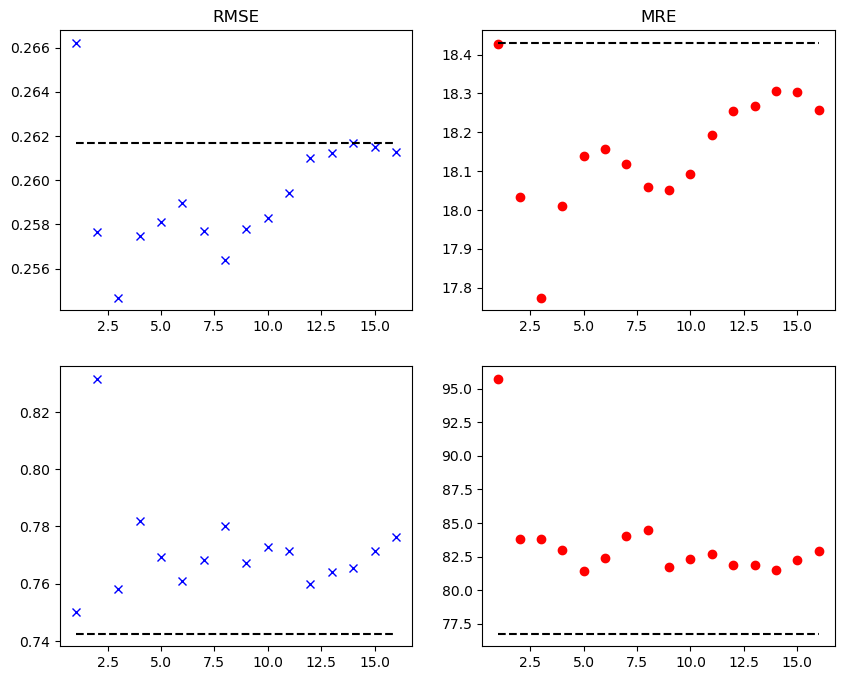

In [33]:
RMSEs = {}
MREs  = {}
RMSEs_elem = {}
MREs_elem  = {}
pred = preds_d[models[0]]
pred_elem = preds_elem_d[models[0]]

for i in range(1, len(models)+1):
    pred = np.zeros(preds_d[models[0]].shape)
    pred_elem = np.zeros(preds_elem_d[models[0]].shape)
    for j in range(i):
        model = models[j]
        pred += preds_d[model]
        pred_elem += preds_elem_d[model]
    pred /= i
    pred_elem /= i
    RMSEs[i] = root_mean_squared_error(Y_test, pred)
    MREs[i]  = ((np.abs(unscale(Y_test) - unscale(pred)) / unscale(Y_test))*100).mean()
    RMSEs_elem[i] = root_mean_squared_error(Y_elem, pred_elem)
    MREs_elem[i]  = ((np.abs(unscale(Y_elem) - unscale(pred_elem)) / unscale(Y_elem))*100).mean()

fig, ax = plt.subplots(2, 2, figsize = (10, 8))
# twinax = 
ax[0,1].plot(MREs.keys(), MREs.values(), 'ro')
ax[0,0].plot(RMSEs.keys(), RMSEs.values(), 'bx')
ax[0,1].set_title('MRE')
ax[0,0].set_title('RMSE')

ax[1,1].plot(MREs_elem.keys(), MREs_elem.values(), 'ro')
ax[1,0].plot(RMSEs_elem.keys(), RMSEs_elem.values(), 'bx')

ax[0, 0].hlines(0.2617, 1, 16, color = 'k', ls = '--')
ax[0, 1].hlines(18.43, 1, 16, color = 'k', ls = '--')
ax[1, 0].hlines(0.7426, 1, 16, color = 'k', ls = '--')
ax[1, 1].hlines(76.78, 1, 16, color = 'k', ls = '--')
plt.show()

In [ ]:
from tqdm.notebook import tqdm
models = [
       'XGB_Both_Eraw_Raw_Scaler',
        'RF_Both_Eraw_Aug_Scaler',
       'RF_Both_Eraw_Raw_Scaler',
            'XGB_A+I_Eraw_Raw_Scaler',
             'LightGBM_A+I_Enorm_Raw_Scaler',
             'CatBoost_A+I_Enorm_Raw_Scaler',
             'CatBoost_A+I_Eraw_Raw_No',
             'LightGBM_A+I_Eraw_Raw_No',
             'XGB_A+I_Enorm_Aug_No',
             'XGB_A+I_Enorm_Raw_Scaler',
             'LightGBM_A+I_Enorm_Raw_No',
             'CatBoost_A+I_Enorm_Aug_Scaler',
             'RF_A+I_Eraw_Raw_Scaler',
             'RF_A+I_Eraw_Raw_No',
             'XGB_A+I_Enorm_Raw_No',
             'CatBoost_A+I_Eraw_Aug_No',
            ]

quints = [
    ['XGB_A+I_Eraw_Raw_No', 'CatBoost_A+I_Enorm_Raw_No', 'LightGBM_A+I_Enorm_Raw_Scaler', 'LightGBM_A+I_Eraw_Raw_No', 'XGB_A+I_Enorm_Aug_No'],
    ['XGB_A+I_Eraw_Raw_No', 'CatBoost_A+I_Enorm_Raw_No', 'LightGBM_A+I_Enorm_Raw_Scaler', 'LightGBM_A+I_Eraw_Raw_No', 'CatBoost_A+I_Enorm_Raw_Scaler'],
    ['XGB_A+I_Eraw_Raw_No', 'CatBoost_A+I_Enorm_Raw_No', 'CatBoost_A+I_Eraw_Raw_No', 'XGB_A+I_Enorm_Aug_No', 'LightGBM_A+I_Enorm_Raw_Scaler'],
    ['XGB_A+I_Eraw_Raw_No', 'CatBoost_A+I_Enorm_Raw_No', 'LightGBM_A+I_Enorm_Raw_Scaler', 'CatBoost_A+I_Eraw_Raw_No', 'CatBoost_A+I_Enorm_Raw_Scaler'],
    ['XGB_A+I_Eraw_Raw_No', 'CatBoost_A+I_Enorm_Raw_No', 'LightGBM_A+I_Enorm_Raw_Scaler', 'LightGBM_A+I_Eraw_Raw_No', 'CatBoost_A+I_Enorm_Aug_Scaler'],
]

RMSE_thresh      = 0.2617
MRE_thresh       = 18.43
RMSE_elem_thresh = 0.7426
MRE_elem_thresh  = 76.78

for quint in tqdm(quints):
    for md6 in tqdm(models):
        if md6 in quint:
            continue
        ensemble = quint.copy()
        ensemble.append(md6)
#         print(ensemble)
        preds_d, preds_elem_d = train_ensemble(ensemble)
        pred = np.zeros(preds_d[ensemble[0]].shape)
        pred_elem = np.zeros(preds_elem_d[ensemble[0]].shape)
        for i in ensemble:
            pred += preds_d[i]
            pred_elem += preds_elem_d[i]
#           print(pred)
        pred /= len(ensemble)
        pred_elem /= len(ensemble)

        RMSE = root_mean_squared_error(Y_test, pred)
        MRE = ((np.abs(unscale(Y_test) - unscale(pred)) / unscale(Y_test))*100).mean()
        RMSE_elem = root_mean_squared_error(Y_elem, pred_elem)
        MRE_elem = ((np.abs(unscale(Y_elem) - unscale(pred_elem)) / unscale(Y_elem))*100).mean()

        res = [RMSE <= RMSE_thresh, MRE <= MRE_thresh, RMSE_elem <= RMSE_elem_thresh, MRE_elem <= MRE_elem_thresh]

        if res.count(True) >= 3:
            print(ensemble)

send_email("All sixtets of models tested. Come check results!")

In [ ]:
models = [
        'XGB_A+I_Eraw_Raw_No', 'CatBoost_A+I_Enorm_Raw_No', 'LightGBM_A+I_Enorm_Raw_Scaler', 'LightGBM_A+I_Eraw_Raw_No', 'CatBoost_A+I_Enorm_Aug_Scaler', 'CatBoost_A+I_Eraw_Aug_No'
            ]

# parameter = 'width'
# augmented_train_set = False
# normalized_energy = False
# X_train, Y_train, X_test, Y_test, X_elem, Y_elem, L_elem, scaler = constr_train_test(parameter,
#                                                                                          augmented_train_set,
#                                                                                          scaled_target=True,
#                                                                                          normalized_energy = normalized_energy,
#                                                                                          print_stats = False)

glob_path = 'C:\\Users\\Alex\\Documents\\GitHub'
models_d     = {}
preds_d      = {}
preds_elem_d = {}

for item in models:
    if '_A+I_' in item:
        parameter = 'width'
    elif '_Shift_' in item:
        parameter = 'shift'
    else:
        raise NameError(f"Parameter for prediction must be specified in model's name: {item}")
    
    if 'KNN' in item:
        path = glob_path + '\\KNN'
    elif 'RF' in item:
        path = glob_path + '\\RF'
    elif 'XGB' in item:
        path = glob_path + '\\XGB'
    elif 'LightGBM' in item:
        path = glob_path + '\\LightGBM'
    elif 'CatBoost' in item:
        path = glob_path + '\\CatBoost'
    
    models_d_item = create_models_dict([item], path = path)
    models_d = models_d | models_d_item
    
    if '_Eraw_' in item:
        normalized_energy = False
    elif '_Enorm' in item:
        normalized_energy = True
    
    if '_Raw_' in item:
        augmented_train_set = False
    elif '_Aug_' in item:
        augmented_train_set = True
    
    if '_No' in item:
        apply_scaler = False
    elif '_Scaler' in item:
        apply_scaler = True
        
    X_train, Y_train, X_test, Y_test, X_elem, Y_elem, L_elem, scaler = constr_train_test(parameter,
                                                                                         augmented_train_set,
                                                                                         scaled_target=True,
                                                                                         normalized_energy = normalized_energy,
                                                                                         print_stats = False)
    
    if apply_scaler:
        preds, preds_elem = plot_model_prediction(models_d_item,
                                                  scaler.transform(X_train), Y_train,
                                                  scaler.transform(X_test), Y_test,
                                                  scaler.transform(X_elem), Y_elem, L_elem, 
                                                  plot = False)
    else:
        preds, preds_elem = plot_model_prediction(models_d_item,
                                                  X_train, Y_train,
                                                  X_test, Y_test,
                                                  X_elem, Y_elem, L_elem, 
                                                  plot = False)

    print(item)
    
    preds_d = preds_d | preds
    preds_elem_d = preds_elem_d | preds_elem

In [ ]:
RMSEs = {}
MREs  = {}
RMSEs_elem = {}
MREs_elem  = {}
pred = preds_d[models[0]]
pred_elem = preds_elem_d[models[0]]

for i in range(1, len(models)+1):
    pred = np.zeros(preds_d[models[0]].shape)
    pred_elem = np.zeros(preds_elem_d[models[0]].shape)
    for j in range(i):
        model = models[j]
        pred += preds_d[model]
        pred_elem += preds_elem_d[model]
    pred /= i
    pred_elem /= i
    RMSEs[i] = root_mean_squared_error(Y_test, pred)
    MREs[i]  = ((np.abs(unscale(Y_test) - unscale(pred)) / unscale(Y_test))*100).mean()
    RMSEs_elem[i] = root_mean_squared_error(Y_elem, pred_elem)
    MREs_elem[i]  = ((np.abs(unscale(Y_elem) - unscale(pred_elem)) / unscale(Y_elem))*100).mean()

fig, ax = plt.subplots(2, 2, figsize = (10, 8))
# twinax = 
ax[0,1].plot(MREs.keys(), MREs.values(), 'ro')
ax[0,0].plot(RMSEs.keys(), RMSEs.values(), 'bx')
ax[0,1].set_title('MRE')
ax[0,0].set_title('RMSE')

ax[1,1].plot(MREs_elem.keys(), MREs_elem.values(), 'ro')
ax[1,0].plot(RMSEs_elem.keys(), RMSEs_elem.values(), 'bx')

ax[0, 0].hlines(0.2617, 1, len(preds_d), color = 'k', ls = '--')
ax[0, 1].hlines(18.43, 1, len(preds_d), color = 'k', ls = '--')
ax[1, 0].hlines(0.7426, 1, len(preds_d), color = 'k', ls = '--')
ax[1, 1].hlines(76.78, 1, len(preds_d), color = 'k', ls = '--')
plt.show()

print(RMSEs[6])
print(MREs[6])
print(RMSEs_elem[6])
print(MREs_elem[6])

# Models optimization

## CatBoost

In [ ]:
CatBoost_params = {
    'learning_rate' : [0.01, 1],
    'max_depth' : [2, 12],
    'l2_leaf_reg' : [0.5, 30],
    'min_data_in_leaf' : [6, 14],
    'random_strength' : [1, 4],
    'nfold' : 5,
    'squared_metrics' : False,
    'n_jobs' : 2
    }

model_name = CatBoost

if apply_scaler:
    print('Scaling')
    CatBoost_res = main(X = pd.DataFrame(scaler.transform(X_train)), y = Y_train, model_name = model_name, params = CatBoost_params, n_trials = 100)
else:
    CatBoost_res = main(X = X_train, y = Y_train, model_name = model_name, params = CatBoost_params, n_trials = 2)

with open(f'CatBoost_Both_Enorm_Raw_No_optimal_parameters', 'w') as fp:
    json.dump(CatBoost_res.best_params, fp)

In [ ]:
optuna.visualization.plot_param_importances(CatBoost_res)

In [ ]:
optuna.visualization.plot_optimization_history(CatBoost_res)

## KNN

In [ ]:
KNN_params = {
    'n_neighbors' : [1, 150],
    'weights' : ['distance', 'uniform'],
    'leaf_size' : [1, 100],
    'p' : [1., 2.],
    'nfold' : 5,
    'squared_metrics' : False,
    'n_jobs' : 2
    }

model_name = KNN

if apply_scaler:
    print('Scaling')
    KNN_res = main(X = pd.DataFrame(scaler.transform(X_train)), y = Y_train, model_name = model_name, params = KNN_params, n_trials = 100)
else:
    KNN_res = main(X = X_train, y = Y_train, model_name = model_name, params = KNN_params, n_trials = 2)

with open(f'KNN_Both_Enorm_Raw_No_optimal_parameters', 'w') as fp:
    json.dump(KNN_res.best_params, fp)

In [ ]:
#Compare default KNN vs optimised KNN
KNN_params = KNN_res.best_params

models = {}

models['new'] = KNeighborsRegressor(**KNN_params)
models['default'] = KNeighborsRegressor()

results = train_and_test_regressor(models, X_train, Y_train, X_test, Y_test)

plot_model_comparison(results)

In [ ]:
#Visualise importance of KNN model parameters
optuna.visualization.plot_param_importances(KNN_res)

In [ ]:
optuna.visualization.plot_slice(KNN_res, params = ['weights', 'n_neighbors'])

In [ ]:
optuna.visualization.plot_optimization_history(KNN_res)

## Random Forest

In [ ]:
RF_params = {
    'n_estimators' : [10, 250],
    'max_depth' : [1, 80],
    'min_samples_split' : [2, 10],
    'min_samples_leaf' : [1, 10],
    'criterion' : ['squared_error', 'absolute_error'],      #add 'poisson' for width tuning
    'nfold' : 5,
    'squared_metrics' : False,
    'n_jobs' : 4
    }

model_name = RandomForest

if apply_scaler:
    print('Scaling')
    RF_res = main(X = pd.DataFrame(scaler.transform(X_train)), y = Y_train, model_name = model_name, params = RF_params, n_trials = 100)
else:
    RF_res = main(X = X_train, y = Y_train, model_name = model_name, params = RF_params, n_trials = 100)

with open(f'RF_Both_Enorm_Raw_No_optimal_parameters', 'w') as fp:
    json.dump(RF_res.best_params, fp)

In [ ]:
optuna.visualization.plot_param_importances(RF_res)

In [ ]:
#Visualising feature importances for the optimal RF model
feature_importance = models_RF['new'].feature_importances_
sorted = np.argsort(feature_importance)
pos = np.arange(sorted.shape[0]) + 0.5

plt.figure(figsize = (15, 15))
plt.barh(pos, feature_importance[sorted])
plt.yticks(pos, np.array(X_train.columns)[sorted])
plt.semilogx()
plt.show()

In [ ]:
optuna.visualization.plot_slice(RF_res, params = ['n_estimators', 'max_depth'])

In [ ]:
optuna.visualization.plot_optimization_history(RF_res)

## XGBoost

In [ ]:
XGB_params = {
    'n_estimators' : [10, 1000],
    'learning_rate' : [0.01, 0.5],
    'max_depth' : [1, 20],
    'min_child_weight' : [1, 15],
    'reg_alpha' : [1e-8, 10],
    'reg_lambda' : [1e-8, 10],
    'nfold' : 5,
    'squared_metrics' : False,
    'n_jobs' : 2
    }

model_name = XGBoost

if apply_scaler:
    print('Scaling')
    XGB_res = main(X = pd.DataFrame(scaler.transform(X_train)), y = Y_train, model_name = model_name, params = XGB_params, n_trials = 100)
else:
    print('here')
    XGB_res = main(X = X_train, y = Y_train, model_name = model_name, params = XGB_params, n_trials = 100)

with open(f'XGB_Both_Enorm_Raw_No_optimal_parameters', 'w') as fp:
    json.dump(XGB_res.best_params, fp)

In [ ]:
XGB_params

In [ ]:
#Compare default XGB vs optimised XGB
XGB_params = XGB_res.best_params

models_XGB = {}

models_XGB['new'] = xgboost.XGBRegressor(**XGB_params)
models_XGB['default'] = xgboost.XGBRegressor()

if apply_scaler:
    results_XGB = train_and_test_regressor(models_XGB, scaler.transform(X_train), Y_train, scaler.transform(X_test), Y_test, scaler = scaler)
else:
    results_XGB = train_and_test_regressor(models_XGB, X_train, Y_train, X_test, Y_test)
plot_model_comparison(results_XGB)

In [ ]:
optuna.visualization.plot_slice(XGB_res, params = ['n_estimators', 'max_depth'])

In [ ]:
#Visualising importance of GB model parameters
optuna.visualization.plot_param_importances(XGB_res)

In [ ]:
#Visualising selection of n_estimators
XGB_params_loc = XGB_params.copy()
del XGB_params_loc['n_estimators']

model = {}
for i in range(400, 1000, 50):
    model[f'{i}'] = xgboost.XGBRegressor(**XGB_params_loc, n_estimators = i)

if apply_scaler:
    path = train_and_test_regressor(model, scaler.transform(X_train), Y_train, scaler.transform(X_test), Y_test)
else:
    path = train_and_test_regressor(model, X_train, Y_train, X_test, Y_test)
plot_model_comparison(path)

In [ ]:
#Visualising feature importances for the optimal XGB model
feature_importance = models_XGB['new'].feature_importances_
sorted = np.argsort(feature_importance)
pos = np.arange(sorted.shape[0]) + 0.5

plt.figure(figsize = (15, 15))
plt.barh(pos, feature_importance[sorted])
plt.yticks(pos, np.array(X_train.columns)[sorted])
plt.semilogx()
plt.show()

In [ ]:
optuna.visualization.plot_optimization_history(XGB_res)

## LightGBM

In [ ]:
LightGBM_params = {
    'n_estimators' : [10, 1000],
    'learning_rate' : [0.01, 0.5],
    'num_leaves' : [2, 512],
    'reg_alpha' : [1e-8, 10],
    'reg_lambda' : [1e-8, 10],
    'nfold' : 5,
    'squared_metrics' : False,
    'n_jobs' : 6
    }

model_name = LightGBM

if apply_scaler:
    print('Scaling')
    LightGBM_res = main(X = pd.DataFrame(scaler.transform(X_train)), y = Y_train, model_name = model_name, params = LightGBM_params, n_trials = 100)
else:
    LightGBM_res = main(X = X_train, y = Y_train, model_name = model_name, params = LightGBM_params, n_trials = 100)

with open(f'LightGBM_Both_Enorm_Raw_No_optimal_parameters', 'w') as fp:
    json.dump(LightGBM_res.best_params, fp)

In [ ]:
LightGBM_params

In [ ]:
#Compare default LightGBM vs optimised LightGBM
LightGBM_params = LightGBM_res.best_params

models_LightGBM = {}

models_LightGBM['new'] = lightgbm.LGBMRegressor(**LightGBM_params)
models_LightGBM['default'] = lightgbm.LGBMRegressor()

if apply_scaler:
    results_LightGBM = train_and_test_regressor(models_LightGBM, scaler.transform(X_train), Y_train, scaler.transform(X_test), Y_test)
plot_model_comparison(results_LightGBM)

In [ ]:
#Visualising importance of GB model parameters
optuna.visualization.plot_param_importances(LightGBM_res)

In [ ]:
optuna.visualization.plot_optimization_history(LightGBM_res)

In [ ]:
#Visualising selection of n_estimators
model = {}
for i in range(10, 501, 20):
    model[f'{i}'] = lightgbm.LGBMRegressor(**XGB_params, n_estimators = i)

path = train_and_test_regressor(model, X_train, Y_train, X_test, Y_test)
plot_model_comparison(path)

In [ ]:
feature_importance = models_LightGBM['new'].feature_importances_
sorted = np.argsort(feature_importance)
pos = np.arange(sorted.shape[0]) + 0.5

plt.figure(figsize = (15, 15))
plt.barh(pos, feature_importance[sorted])
plt.yticks(pos, np.array(XW_train.columns)[sorted])
plt.semilogx()
plt.show()

## TabNet

In [21]:
torch.cuda.is_available()

True

In [ ]:
TabNet_params = {
    'n_d' : [1, 64],
    'n_steps' : [1, 25],
    'gamma' : [1., 2.],
    'n_independent' : [1, 20],
    'n_shared' : [1, 20],
    'momentum' : [1e-3, 0.4],
    'mask_type' : ['sparsemax', 'entmax'],
    'nfold' : 5,
    'squared_metrics' : False,
    'device_name' : 'cuda',
    'n_jobs' : 1
    }

model_name = TabNet

if apply_scaler:
    print('Scaling')
    TabNet_res = main(X = pd.DataFrame(scaler.transform(X_train)), y = Y_train, model_name = model_name, params = TabNet_params, n_trials = 1)
else:
    TabNet_res = main(X = X_train, y = Y_train, model_name = model_name, params = TabNet_params, n_trials = 1)
    
'''with open(f'TabNet_Both_Eraw_Raw_Scaler_optimal_parameters', 'w') as fp:
    json.dump(TabNet_res.best_params, fp)'''

In [ ]:
TabNet_params = TabNet_res.best_params
TabNet_params['device_name'] = 'cuda'

models_TabNet = {}

models_TabNet['TabNet_new'] = TabNet(TabNet_params)
models_TabNet['TabNet_default'] = TabNet({'device_name' : 'cuda',
                                   'n_d' : 8})

results_TabNet = train_and_test_regressor(models_TabNet, X_train, Y_train, X_test, Y_test, max_epochs = 100)
plot_model_comparison(results_TabNet)

In [ ]:
optuna.visualization.plot_param_importances(TabNet_res)

In [ ]:
optuna.visualization.plot_contour(TabNet_res)

# Comparison #Old#

## Width

In [ ]:
models = ['RF_A+I_StandardScaler_Scaled', 'XGB_A+I_StandardScaler_Scaled', 'TabNet_A+I_StandardScaler_Scaled']

models_d = create_models_dict(models)

preds, preds_elem, fix, ax = plot_model_prediction(models_d,
                                                    pd.DataFrame(scaler.transform(X_train)), Y_train,
                                                    pd.DataFrame(scaler.transform(X_test)), Y_test,
                                                    pd.DataFrame(scaler.transform(X_elem)), Y_elem, label_width_elements)

'''preds, preds_elem, fix, ax = plot_model_prediction(models_d,
                                                    X_train, Y_train,
                                                    a_data_width_test, a_target_width_test,
                                                    a_data_width_elements, a_target_width_elements, a_label_width_elements)'''

In [ ]:
YW_test = a_target_width_test
YW_elem = a_target_width_elements
LW_elem = a_label_width_elements

predictions_elem = {}
R2 = {}
R2_elem = {}
RMSE = {}
RMSE_elem = {}
for name, model in models_d.items():
    y_pred = preds[name]
    R2[name] = r2_score(YW_test, y_pred)
    RMSE[name] = mean_squared_error(YW_test, y_pred, squared = False)

    y_pred = preds_elem[name]
    R2_elem[name] = r2_score(YW_elem, y_pred)
    RMSE_elem[name] = mean_squared_error(YW_elem, y_pred, squared = False)

    
i = 0
fig, ax = plt.subplots(2, len(models_d), figsize = (3.75*len(models_d), 3*2), dpi = 150)
for name, model in models_d.items():
    print(f'Plotting {name} predictions')
    ax[0, i].plot(YW_test, preds[name], ls = 'None', marker = 'x', c = '#d55e00', ms = 8)
    ax[0, i].plot([0, np.amax(YW_test)], [0, np.amax(YW_test)], color = '#56b4e9', ls = '--')
    ax[0, i].set_title(f'{name}', fontsize = 12, pad = 26, fontweight = 'book', loc = 'right')
    #ax[0, i].text(x = 0, y = 1, s = f'$R^2$ = {R2[name]:.4f}', transform = ax[0, i].transAxes)
    ax[0, i].text(x = 0, y = 1.02, s = f'$R^2$ = {R2[name]:.3f}  \nRMSE = {RMSE[name]:.3f}',  transform = ax[0, i].transAxes)
    ax[0, i].tick_params(axis = 'both', direction = 'in')
    
    #ax[1, i].plot(y_elem, predictions_elem[name], 'r.')
    sns.scatterplot(x = YW_elem, y = preds_elem[name], ax = ax[1, i], style = LW_elem['Element'], hue = LW_elem['Element'], palette = 'colorblind', s = 80)
    ax[1, i].plot([0, np.amax(YW_elem)], [0, np.amax(YW_elem)], color = '#56b4e9', ls = '--')
    ax[1, i].text(x = 0, y = 1.01, s = f'$R^2$ = {R2_elem[name]:.3f}    RMSE = {RMSE_elem[name]:.3f}',  transform = ax[1, i].transAxes)
    ax[1, i].tick_params(axis = 'both', direction = 'in')

    i += 1

ax[1, 1].get_legend().remove()
ax[1, 1].set(xlabel = None)
ax[1, 0].set_xlabel(r'Stark width $w$ at $N_e = 10^{17}$ $cm^{-3}$ $(\AA)$ ', horizontalalignment='center', x=1.1, fontsize = 12)
ax[0, 0].set_ylabel(r'Predicted Stark width $w$ at $N_e = 10^{17}$ $cm^{-3}$ $(\AA)$ ', horizontalalignment='center', y=-0.2, fontsize = 12)
plt.show()

#fig.savefig('Predictions_StandardScaler.svg', transparent = True, format = 'svg')

In [ ]:
'''results_original = train_and_test_regressor(models_d,
                                            pd.DataFrame(scaler.transform(X_train)), Y_train,
                                            pd.DataFrame(scaler.transform(X_test)), Y_test,
                                            train = False)'''
results_original = train_and_test_regressor(models_d,
                                            X_train, Y_train,
                                            X_test, Y_test,
                                            train = False)
plot_model_comparison(results_original)

## Width. Scaled *targets*

In [ ]:
models = ['RF_A+I_StandardScaler_Scaled', 'XGB_A+I_StandardScaler_Scaled', 'TabNet_A+I_StandardScaler_Scaled']
#models = ['KNN_A+I_Scaled', 'LightGBM_A+I_Scaled']

models_d = create_models_dict(models)

preds, preds_elem, fix, ax = plot_model_prediction(models_d,
                                                    pd.DataFrame(scaler.transform(X_train)), Y_train,
                                                    pd.DataFrame(scaler.transform(a_data_width_test)), np.log(1 + a_target_width_test / epsilon),
                                                    pd.DataFrame(scaler.transform(a_data_width_elements)), np.log(1 + a_target_width_elements / epsilon), a_label_width_elements)

'''preds, preds_elem, fix, ax = plot_model_prediction(models_d,
                                                    X_train, Y_train,
                                                    a_data_width_test, np.log(1 + a_target_width_test / epsilon),
                                                    a_data_width_elements, np.log(1 + a_target_width_elements / epsilon), a_label_width_elements)'''

In [ ]:
for name, values in preds.items():
    preds[name] = (np.exp(preds[name]) - 1) * epsilon
    preds_elem[name] = (np.exp(preds_elem[name]) -1) * epsilon

In [ ]:
'''YW_test = (np.exp(Y_test) - 1) * epsilon
YW_elem = (np.exp(Y_elem) - 1) * epsilon
LW_elem = label_width_elements'''

YW_test = a_target_width_test
YW_elem = a_target_width_elements
LW_elem = a_label_width_elements

predictions_elem = {}
R2 = {}
R2_elem = {}
RMSE = {}
RMSE_elem = {}
for name, model in models_d.items():
    y_pred = preds[name]
    R2[name] = r2_score(YW_test, y_pred)
    RMSE[name] = mean_squared_error(YW_test, y_pred, squared = False)

    y_pred = preds_elem[name]
    R2_elem[name] = r2_score(YW_elem, y_pred)
    RMSE_elem[name] = mean_squared_error(YW_elem, y_pred, squared = False)

    
i = 0
fig, ax = plt.subplots(2, len(models_d), figsize = (3.75*len(models_d), 3*2), dpi = 150)
for name, model in models_d.items():
    print(f'Plotting {name} predictions')
    ax[0, i].plot(YW_test, preds[name], ls = 'None', marker = 'x', c = '#d55e00', ms = 8)
    ax[0, i].plot([0, np.amax(YW_test)], [0, np.amax(YW_test)], color = '#56b4e9', ls = '--')
    ax[0, i].set_title(f'{name}', fontsize = 12, pad = 26, fontweight = 'book', loc = 'right')
    #ax[0, i].text(x = 0, y = 1, s = f'$R^2$ = {R2[name]:.4f}', transform = ax[0, i].transAxes)
    ax[0, i].text(x = 0, y = 1.02, s = f'$R^2$ = {R2[name]:.3f}  \nRMSE = {RMSE[name]:.3f}',  transform = ax[0, i].transAxes)
    ax[0, i].tick_params(axis = 'both', direction = 'in')
    
    #ax[1, i].plot(y_elem, predictions_elem[name], 'r.')
    sns.scatterplot(x = YW_elem, y = preds_elem[name], ax = ax[1, i], style = LW_elem['Element'], hue = LW_elem['Element'], palette = 'colorblind', s = 80)
    ax[1, i].plot([0, np.amax(YW_elem)], [0, np.amax(YW_elem)], color = '#56b4e9', ls = '--')
    ax[1, i].text(x = 0, y = 1.01, s = f'$R^2$ = {R2_elem[name]:.3f}    RMSE = {RMSE_elem[name]:.3f}',  transform = ax[1, i].transAxes)
    ax[1, i].tick_params(axis = 'both', direction = 'in')

    i += 1

ax[1, 1].get_legend().remove()
ax[1, 1].set(xlabel = None)
ax[1, 0].set_xlabel(r'Stark width $w$ at $N_e = 10^{17}$ $cm^{-3}$ $(\AA)$ ', horizontalalignment='center', x=1.1, fontsize = 12)
ax[0, 0].set_ylabel(r'Predicted Stark width $w$ at $N_e = 10^{17}$ $cm^{-3}$ $(\AA)$ ', horizontalalignment='center', y=-0.2, fontsize = 12)
plt.show()

#fig.savefig('Predictions_StandardScaler.svg', transparent = True, format = 'svg')

In [ ]:
def train_and_test_regressor_local(models, X_train, y_train, X_test, y_test, max_epochs = 200, patience = 20, train = True):
    predictions = {}
    for name, model in models.items():
        if train == True:
            print(f"Fitting {name}")
            if 'TabNet' in name:
                model.fit(X_train, y_train, X_test, y_test)
            else:
                model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        predictions[name] = y_pred
      
    boot_scores = {}

    for name, y_pred in predictions.items():
        print(f"Calculating bootstrap score for {name}")
        boot_score = bootstrap_metric((np.exp(y_test - 1)) * epsilon, 
                                      (np.exp(y_pred - 1)) * epsilon, 
                                      metric_fn=lambda x, y: mean_squared_error(y_true=x,
                                                                                y_pred=y,
                                                                                squared = False))
        boot_scores[name] = boot_score

  
    results = pd.DataFrame(boot_scores)
    # cast to long format
    results = results.melt(value_vars=results.columns,
                      value_name="mse", 
                      var_name="model") 
    return results

In [ ]:
results_scaled = train_and_test_regressor_local(models_d,
                                            data_width_train.drop(columns=['Element', 'Wavelength', 'Z number']).sample(frac = 1, random_state = 777), np.log(1 + target_width_train.sample(frac = 1, random_state = 777) / epsilon),
                                            data_width_test.drop(columns=['Element', 'Wavelength', 'Z number']), np.log(1 + target_width_test / epsilon),
                                            train = False)
plot_model_comparison(results_scaled)

## Width. Scaled and augmented

In [ ]:
models = ['KNN_A+I_Extended', 'RF_A+I_StandardScaler_Extended', 'XGB_A+I_v2_StandardScaler_Extended', 'LightGBM_A+I_Extended']
#models = ['KNN_A+I_Scaled', 'LightGBM_A+I_Scaled']

models_d = create_models_dict(models)

preds, preds_elem, fix, ax = plot_model_prediction(models_d,
                                                    X_train, Y_train,
                                                    X_test, Y_test,
                                                    X_elem, Y_elem, L_elem,
                                                  scaler = scaler)

'''preds, preds_elem, fix, ax = plot_model_prediction(models_d,
                                                    X_train, Y_train,
                                                    a_data_width_test, np.log(1 + a_target_width_test / epsilon),
                                                    a_data_width_elements, np.log(1 + a_target_width_elements / epsilon), a_label_width_elements)'''

In [ ]:
for name, values in preds.items():
    preds[name] = (np.exp(preds[name]) - 1) * epsilon
    preds_elem[name] = (np.exp(preds_elem[name]) -1) * epsilon

In [ ]:
YW_test = (np.exp(Y_test) - 1) * epsilon
YW_elem = (np.exp(Y_elem) - 1) * epsilon
LW_elem = label_width_elements

'''YW_test = a_target_width_test
YW_elem = a_target_width_elements
LW_elem = a_label_width_elements'''

predictions_elem = {}
R2 = {}
R2_elem = {}
RMSE = {}
RMSE_elem = {}
for name, model in models_d.items():
    y_pred = preds[name]
    R2[name] = r2_score(YW_test, y_pred)
    RMSE[name] = mean_squared_error(YW_test, y_pred, squared = False)

    y_pred = preds_elem[name]
    R2_elem[name] = r2_score(YW_elem, y_pred)
    RMSE_elem[name] = mean_squared_error(YW_elem, y_pred, squared = False)

    
i = 0
fig, ax = plt.subplots(2, len(models_d), figsize = (3.75*len(models_d), 3*2), dpi = 150)
for name, model in models_d.items():
    print(f'Plotting {name} predictions')
    ax[0, i].plot(YW_test, preds[name], ls = 'None', marker = 'x', c = '#d55e00', ms = 8)
    ax[0, i].plot([0, np.amax(YW_test)], [0, np.amax(YW_test)], color = '#56b4e9', ls = '--')
    ax[0, i].set_title(f'{name}', fontsize = 12, pad = 26, fontweight = 'book', loc = 'right')
    #ax[0, i].text(x = 0, y = 1, s = f'$R^2$ = {R2[name]:.4f}', transform = ax[0, i].transAxes)
    ax[0, i].text(x = 0, y = 1.02, s = f'$R^2$ = {R2[name]:.3f}  \nRMSE = {RMSE[name]:.3f}',  transform = ax[0, i].transAxes)
    ax[0, i].tick_params(axis = 'both', direction = 'in')
    
    #ax[1, i].plot(y_elem, predictions_elem[name], 'r.')
    sns.scatterplot(x = YW_elem, y = preds_elem[name], ax = ax[1, i], style = LW_elem['Element'], hue = LW_elem['Element'], palette = 'colorblind', s = 80)
    ax[1, i].plot([0, np.amax(YW_elem)], [0, np.amax(YW_elem)], color = '#56b4e9', ls = '--')
    ax[1, i].text(x = 0, y = 1.01, s = f'$R^2$ = {R2_elem[name]:.3f}    RMSE = {RMSE_elem[name]:.3f}',  transform = ax[1, i].transAxes)
    ax[1, i].tick_params(axis = 'both', direction = 'in')

    i += 1

ax[1, 1].get_legend().remove()
ax[1, 1].set(xlabel = None)
ax[1, 0].set_xlabel(r'Stark width $w$ at $N_e = 10^{17}$ $cm^{-3}$ $(\AA)$ ', horizontalalignment='center', x=1.1, fontsize = 12)
ax[0, 0].set_ylabel(r'Predicted Stark width $w$ at $N_e = 10^{17}$ $cm^{-3}$ $(\AA)$ ', horizontalalignment='center', y=-0.2, fontsize = 12)
plt.show()

#fig.savefig('Predictions_StandardScaler.svg', transparent = True, format = 'svg')

In [ ]:
results_augmented = train_and_test_regressor_local(models_d,
                                                data_width_train_extended.drop(columns=['Element', 'Wavelength', 'Z number']).sample(frac = 1, random_state = 777), np.log(1 + target_width_train_extended.sample(frac = 1, random_state = 777) / epsilon),
                                                data_width_test.drop(columns=['Element', 'Wavelength', 'Z number']), np.log(1 + target_width_test / epsilon),
                                                train = False)
plot_model_comparison(results_augmented)

## Shift

In [ ]:
models = ['KNN_SHIFT', 'RF_SHIFT', 'GB_SHIFT', 'XGB_SHIFT', 'LightGBM_SHIFT', 'TabNet_SHIFT']

models_d = create_models_dict(models)

preds, preds_elem, fix, ax = plot_model_prediction(models_d,
                                                    XS_train, YS_train,
                                                    XS_test, YS_test,
                                                    XS_elem, YS_elem, LS_elem)

In [ ]:
results_shift = train_and_test_regressor(models_d,
                                        XS_train, YS_train,
                                        XS_test, YS_test,
                                         train = False)
plot_model_comparison(results_shift)

# Temperature dependence

In [ ]:
data_width['Wavelength'].value_counts()

In [ ]:
#Select one of the lines with the highest number of entries in full dataset
#Set index "idx"from 0 to ..., where 0 represents the line with the highest number of entries
idx = 2
wavelength = list(data_width['Wavelength'].value_counts().index)[idx]
data_width_train_full, target_width_train_full = data_width_train.copy(), target_width_train.copy()
data_width_elements_full, target_width_elements_full = data_width_elements.copy(), target_width_elements.copy()
data_width_train, target_width_train = data_width.copy(), target_width.copy()

line_data = data.loc[(data_width['Wavelength'] == wavelength) & (data['w (A)'].isna() == False)]
line_data_train = data_width_train[data_width_train['Wavelength'] == wavelength]

# data_width_train, target_width_train = data_width_train.drop(line_data_train.index), target_width_train.drop(line_data_train.index)
data_width_elements   = line_data.drop(columns = ['w (A)', 'd (A)','w error (%)', 'd error (%)'])
target_width_elements = line_data['w (A)']
label_width_elements = line_data['Element']

print(line_data['Element'].iloc[0], line_data['Wavelength'].iloc[0], 'nm;', line_data.shape[0], 'data points;', ' ',
     data_width_train[data_width_train['Wavelength'] == wavelength].shape[0], 'points in train')

T_low, T_high = line_data['T'].describe()['min'], line_data['T'].describe()['max']
print(f'Data from {T_low}K to {T_high} available for this line')

fig, ax = plt.subplots()
ax.plot(line_data['T'], line_data['w (A)'], color = 'orange', ls = 'None', marker = 'x')
ax.errorbar(line_data.loc[line_data['w error (%)'].isna() == False]['T'],
           line_data.loc[line_data['w error (%)'].isna() == False]['w (A)'],
           yerr = line_data.loc[line_data['w error (%)'].isna() == False]['w error (%)']/100*line_data.loc[line_data['w error (%)'].isna() == False]['w (A)'],
           color = 'orange', ls = 'None', capsize=5, lw = 1)

plt.show()

print(f'\tPoints plotted are only original data (without artificial points)')

In [ ]:
#Define temperature range in each case
T_low, T_high = line_data['T'].describe()['min'], line_data['T'].describe()['max']

npoints = int((T_high - T_low)//500)
temperatures = np.linspace(T_low, T_high, npoints)

unit = line_data[line_data['Wavelength'].duplicated() == False]

for i in range(npoints):
    unit['T'] = temperatures[i]
    if i == 0:
        temperature_test_data = unit.copy()
    else:
        temperature_test_data = pd.concat([temperature_test_data, unit])

temperature_test_data = temperature_test_data.drop(columns=['w (A)', 'd (A)',
                                                            'w error (%)', 'd error (%)'])

In [25]:
data_width_test_full, target_width_test_full = data_width_test.copy(), target_width_test.copy()
data_width_test, target_width_test = temperature_test_data.reset_index(drop = True), temperature_test_data['1s'].reset_index(drop = True)

In [ ]:
models = [
    ['XGB_A+I_Eraw_Raw_No', 'CatBoost_A+I_Enorm_Raw_No', 'LightGBM_A+I_Enorm_Raw_Scaler', 'LightGBM_A+I_Eraw_Raw_No', 'XGB_A+I_Enorm_Aug_No'],
#     ['XGB_A+I_Eraw_Raw_No', 'CatBoost_A+I_Enorm_Raw_No', 'LightGBM_A+I_Enorm_Raw_Scaler', 'LightGBM_A+I_Eraw_Raw_No', 'XGB_A+I_Enorm_Aug_No', 'CatBoost_A+I_Eraw_Raw_No'],
#     ['XGB_A+I_Eraw_Raw_No', 'CatBoost_A+I_Enorm_Raw_No'],
#     ['LightGBM_A+I_Eraw_Raw_Scaler'],
#     ['XGB_A+I_Eraw_Raw_No']
        ]
glob_path = 'C:\\Users\\Alex\\Documents\\GitHub'

models_d     = {}
preds_d      = []
preds_elem_d = []

for ensemble in tqdm(models):
    preds_ensemble      = {}
    preds_elem_ensemble = {}
    for item in ensemble:
        if '_A+I_' in item:
            parameter = 'width'
        elif '_Shift_' in item:
            parameter = 'shift'
        else:
            raise NameError(f"Parameter for prediction must be specified in model's name: {item}")

        if 'KNN' in item:
            path = glob_path + '\\KNN'
        elif 'RF' in item:
            path = glob_path + '\\RF'
        elif 'XGB' in item:
            path = glob_path + '\\XGB'
        elif 'LightGBM' in item:
            path = glob_path + '\\LightGBM'
        elif 'CatBoost' in item:
            path = glob_path + '\\CatBoost'

        models_d_item = create_models_dict([item], path = path)

        if '_Eraw_' in item:
            normalized_energy = False
        elif '_Enorm' in item:
            normalized_energy = True

        if '_Raw_' in item:
            augmented_train_set = False
        elif '_Aug_' in item:
            augmented_train_set = True

        if '_No' in item:
            apply_scaler = False
        elif '_Scaler' in item:
            apply_scaler = True

        X_train, Y_train, X_test, Y_test, X_elem, Y_elem, L_elem, scaler = constr_train_test(parameter,
                                                                                             augmented_train_set,
                                                                                             scaled_target=True,
                                                                                             normalized_energy = normalized_energy,
                                                                                             print_stats = False)
        if apply_scaler:
            preds, preds_elem = plot_model_prediction(models_d_item,
                                                      scaler.transform(X_train), Y_train,
                                                      scaler.transform(X_test), Y_test,
                                                      scaler.transform(X_elem), Y_elem, L_elem, 
                                                      plot = False)
        else:
            preds, preds_elem = plot_model_prediction(models_d_item,
                                                      X_train, Y_train,
                                                      X_test, Y_test,
                                                      X_elem, Y_elem, L_elem, 
                                                      plot = False)
        preds_ensemble = preds_ensemble | preds
        preds_elem_ensemble = preds_elem_ensemble | preds_elem
    
    pred = np.zeros(preds_ensemble[ensemble[0]].shape)
    pred_elem = np.zeros(preds_elem_ensemble[ensemble[0]].shape)
    for key in preds_ensemble.keys():
        pred += preds_ensemble[key]
        pred_elem += preds_elem_ensemble[key]
    pred /= len(preds_ensemble.keys())
    pred_elem /= len(preds_elem_ensemble.keys())
    
    preds_d.append(pred)
    preds_elem_d.append(pred_elem)

data_width_train, target_width_train = data_width_train_full.copy(), target_width_train_full.copy()
data_width_test, target_width_test   = data_width_test_full.copy(), target_width_test_full.copy()
data_width_elements, target_width_elements = data_width_elements_full.copy(), target_width_elements_full.copy()

In [28]:
RMSE_Temperature = []
for i in preds_elem_d:
    RMSE_Temperature.append(root_mean_squared_error(unscale(i), unscale(Y_elem)))

In [ ]:
fig, ax = plt.subplots(figsize = (10, 8))
ax.plot(line_data['T'], line_data['w (A)'], color = 'orange', ls = 'None', marker = 'x')
ax.errorbar(line_data.loc[line_data['w error (%)'].isna() == False]['T'],
           line_data.loc[line_data['w error (%)'].isna() == False]['w (A)'],
           yerr = line_data.loc[line_data['w error (%)'].isna() == False]['w error (%)']/100*line_data.loc[line_data['w error (%)'].isna() == False]['w (A)'],
           color = 'orange', ls = 'None', capsize=5, lw = 1)
for i in range(len(models)):
    ax.plot(temperatures, unscale(preds_d[i]), label = str(models[i]) + '; RMSE = ' + str(f'{RMSE_Temperature[i]:.3f}'))

ax.legend()
ax.set_title(f"{line_data['Element'].iloc[0]} {line_data['Wavelength'].iloc[0]} nm")
# ax.set_ylim(-0.02, 0.5)
# plt.savefig('Temperature dependence He.svg', transparent = True)
plt.show()

# Shift only vs. Both parameters

## Comparison on "Both" test sets

In [ ]:
data_shift_train_full, target_shift_train_full       = data_shift_train.copy(), target_shift_train.copy()
data_shift_test_full, target_shift_test_full         = data_shift_test.copy(), target_shift_test.copy()
data_shift_elements_full, target_shift_elements_full = data_shift_elements.copy(), target_shift_elements.copy()

data_shift_train, target_shift_train       = data_shift.copy(), target_shift.copy()
data_shift_train, target_shift_train       = data_shift_train.drop(data_both_test.index), target_shift_train.drop(data_both_test.index)
data_shift_test, target_shift_test         = data_shift.loc[data_both_test.index], target_shift.loc[data_both_test.index]
data_shift_elements, target_shift_elements = data_shift_elements.loc[data_both_elements.index], target_shift_elements.loc[data_both_elements.index]

models = [
    'RF_Shift_Enorm_Aug_No',
    'RF_Shift_Enorm_Raw_No',
    'RF_Shift_Enorm_Aug_Scaler',
    'RF_Shift_Enorm_Raw_Scaler',
    'KNN_Shift_Eraw_Raw_No',
    'XGB_Shift_Enorm_Aug_No',
    'CatBoost_Shift_Enorm_Aug_No',
    'CatBoost_Shift_Enorm_Raw_Scaler',
#     'KNN_Both_Enorm_Aug_Scaler',                        #1 by test weights and #1 by test rankings and #1 ny both tests rankings
#     'RF_Both_Eraw_Aug_No',                              #1 by both tests weights
]

pred, pred_elem = train_ensemble(models)

X_train, Y_train, X_test, Y_test, X_elem, Y_elem, L_elem, scaler = constr_train_test('both',
                                                                                     False,
                                                                                     scaled_target=False,
                                                                                     normalized_energy = False,
                                                                                     print_stats = True)
for key in pred.keys():
    RMSE = root_mean_squared_error(Y_test, pred[key])
    MRE = ((np.abs(Y_test - pred[key]) / np.abs(Y_test))*100).replace(np.inf, np.nan).mean()
    RMSE_elem = root_mean_squared_error(Y_elem, pred_elem[key])
    MRE_elem = ((np.abs(Y_elem - pred_elem[key]) / np.abs(Y_elem))*100).replace(np.inf, np.nan).mean()
        
    print(f'{key:40} {RMSE:10.4f} {MRE:10.2f} {RMSE_elem:10.4f} {MRE_elem:10.2f}')

data_shift_train, target_shift_train       = data_shift_train_full.copy(), target_shift_train_full.copy()
data_shift_test, target_shift_test         = data_shift_test_full.copy(), target_shift_test_full.copy()
data_shift_elements, target_shift_elements = data_shift_elements_full.copy(), target_shift_elements_full.copy()

In [18]:
data_width_train_full, target_width_train_full       = data_width_train.copy(), target_width_train.copy()
data_width_test_full, target_width_test_full         = data_width_test.copy(), target_width_test.copy()
data_width_elements_full, target_width_elements_full = data_width_elements.copy(), target_width_elements.copy()

data_shift_train_full, target_shift_train_full       = data_shift_train.copy(), target_shift_train.copy()
data_shift_test_full, target_shift_test_full         = data_shift_test.copy(), target_shift_test.copy()

data_both_test_full, target_both_test_full           = data_both_test.copy(), target_both_test.copy()
data_both_elements_full, target_both_elements_full   = data_both_elements.copy(), target_both_elements.copy()


data_shift_test, target_shift_test  = data_shift.loc[data_both_test.index], target_shift.loc[data_both_test.index]
data_shift_train, target_shift_train = data_shift.drop(data_both_test.index), target_shift.drop(data_both_test.index)

data_shift_train, data_shift_test_add, target_shift_train, target_shift_test_add = train_test_split(data_shift_train,
                                                                                                    target_shift_train,
                                                                                                    test_size = np.ceil(((data_shift.shape[0] + 
                                                                                                                          data_shift_elements.shape[0])*0.2 - 
                                                                                                                         data_shift_elements.shape[0] - 
                                                                                                                         data_both_test.shape[0])) / data_shift_train.shape[0],
                                                                                                    random_state = 6)
data_shift_test, target_shift_test = pd.concat([data_shift_test, data_shift_test_add]), pd.concat([target_shift_test, target_shift_test_add])

data_width_train   = data_width.drop(data_shift_test.drop(data_both_test.index).index, errors='ignore')
target_width_train = target_width.drop(data_shift_test.drop(data_both_test.index).index, errors='ignore')

data_width_test   = data.loc[data_shift_test.drop(data_both_test.index).index]
target_width_test = data_width_test['w (A)']
data_width_elements   = data.loc[data_shift_elements.drop(data_both_elements.index).index]
target_width_elements = data_width_elements['w (A)']
data_width_test     = data_width_test.drop(columns=['w (A)', 'd (A)', 'w error (%)', 'd error (%)'])
data_width_elements = data_width_elements.drop(columns=['w (A)', 'd (A)', 'w error (%)', 'd error (%)'])

ensemble_width = [
    'XGB_A+I_Eraw_Raw_No',
#     'CatBoost_A+I_Enorm_Raw_No',
#     'LightGBM_A+I_Enorm_Raw_Scaler',
#     'LightGBM_A+I_Eraw_Raw_No',
#     'XGB_A+I_Enorm_Aug_No',
]

preds, preds_elem = train_ensemble(ensemble_width)

pred, pred_elem = np.zeros(len(preds[list(preds.keys())[0]])), np.zeros(len(preds_elem[list(preds_elem.keys())[0]]))
for key in preds:
    pred      += preds[key]
    pred_elem += preds_elem[key]
pred /= len(preds) 
pred_elem /= len(preds_elem)

print(len(pred), data_shift_test_add.shape)
print(len(pred_elem), data_shift_elements.shape[0] - data_both_elements.shape[0])

data_both_test = pd.concat((pd.concat((data_shift.loc[data_both_test.index],
                                        data.loc[data_both_test.index]['w (A)']),
                                       axis = 1),
                             pd.concat((data_shift_test_add,
                                        pd.Series(unscale(pred),
                                                  index = data_shift_test_add.index,
                                                  name='w (A)')),
                                       axis = 1))).drop(columns=['8p']).sort_index()
target_both_test = pd.concat((target_both_test,
                              target_shift_test_add)).sort_index()

data_shift_test = pd.concat((data_shift.loc[data_both_test.index],
                             data_shift_test_add)).sort_index()
target_shift_test = target_both_test.copy()

data_both_elements = pd.concat((data_both_elements,
                                pd.concat((data_shift_elements.drop(data_both_elements.index).drop(columns = ['8p']),
                                           pd.Series(unscale(pred_elem),
                                                    index = data_shift_elements.drop(data_both_elements.index).index,
                                                    name = 'w (A)')),
                                          axis = 1))).sort_index()
target_both_elements = target_shift_elements.sort_index()


models_for_comparison = [
    'RF_Both_Eraw_Aug_No',
    'RF_Both_Eraw_Raw_No',
    'XGB_Both_Eraw_Raw_Scaler',
#     'RF_Shift_Enorm_Raw_No',
]

S_test = data_both_test
S_elem = data_both_elements

preds, preds_elem = train_ensemble(models_for_comparison)

try:
    for key in preds.keys():
        RMSE = root_mean_squared_error(target_shift_test, preds[key])
        MRE = ((np.abs(target_shift_test - preds[key]) / np.abs(target_shift_test))*100).replace(np.inf, np.nan).mean()
        RMSE_elem = root_mean_squared_error(target_shift_elements, preds_elem[key])
        MRE_elem = ((np.abs(target_shift_elements - preds_elem[key]) / np.abs(target_shift_elements))*100).replace(np.inf, np.nan).mean()

        print(f'{key:40} {RMSE:10.4f} {MRE:10.2f} {RMSE_elem:10.4f} {MRE_elem:10.2f}')
except:
    pass

    
data_width_train, target_width_train       = data_width_train_full.copy(), target_width_train_full.copy()
data_width_test, target_width_test         = data_width_test_full.copy(), target_width_test_full.copy()
data_width_elements, target_width_elements = data_width_elements_full.copy(), target_width_elements_full.copy()

data_shift_train, target_shift_train       = data_shift_train_full.copy(), target_shift_train_full.copy()
data_shift_test, target_shift_test         = data_shift_test_full.copy(), target_shift_test_full.copy()

data_both_test, target_both_test           = data_both_test_full.copy(), target_both_test_full.copy()
data_both_elements, target_both_elements   = data_both_elements_full.copy(), target_both_elements_full.copy()

  0%|          | 0/1 [00:00<?, ?it/s]

134 (134, 56)
12 12


  0%|          | 0/3 [00:00<?, ?it/s]

RF_Both_Eraw_Aug_No                          0.2709      48.79     0.7966     141.60
RF_Both_Eraw_Raw_No                          0.2893      51.72     0.8266     137.23
XGB_Both_Eraw_Raw_Scaler                     0.2433      53.87     0.7830     142.15


## Comparison on "Shift" Test

In [20]:
data_width_train_full, target_width_train_full       = data_width_train.copy(), target_width_train.copy()
data_width_test_full, target_width_test_full         = data_width_test.copy(), target_width_test.copy()
data_width_elements_full, target_width_elements_full = data_width_elements.copy(), target_width_elements.copy()

data_shift_train_full, target_shift_train_full       = data_shift_train.copy(), target_shift_train.copy()
data_shift_test_full, target_shift_test_full         = data_shift_test.copy(), target_shift_test.copy()

data_both_train_full, target_both_train_full         = data_both_train.copy(), target_both_train.copy()
data_both_test_full, target_both_test_full           = data_both_test.copy(), target_both_test.copy()
data_both_elements_full, target_both_elements_full   = data_both_elements.copy(), target_both_elements.copy()


#Sec I
data_both_test, target_both_test         = data_shift_test.copy(), target_shift_test.copy()
data_both_train, target_both_train       = data_both.drop(data_both_test.index, errors='ignore'), target_both.drop(data_both_test.index, errors='ignore')
data_both_elements, target_both_elements = data_shift_elements.copy(), target_shift_elements.copy()

#Sec II
data_both_test     = data_both_test.drop(columns = ['8p'])
data_both_elements = data_both_elements.drop(columns = ['8p'])
data_both_test['w (A)']     = np.nan
data_both_elements['w (A)'] = np.nan
data_both_test['w (A)']     = data['w (A)']
data_both_elements['w (A)'] = data['w (A)']
data_width_test     = data.loc[data_both_test.loc[data_both_test['w (A)'].isna() == True].index].drop(columns = ['w (A)',
                                                                                                                 'd (A)',
                                                                                                                 'w error (%)',
                                                                                                                 'd error (%)'])
data_width_elements = data.loc[data_both_elements.loc[data_both_elements['w (A)'].isna() == True].index].drop(columns = ['w (A)',
                                                                                                                         'd (A)',
                                                                                                                         'w error (%)',
                                                                                                                         'd error (%)'])

#Sec III
ensemble_width = [
    'XGB_A+I_Eraw_Raw_No',
    'CatBoost_A+I_Enorm_Raw_No',
    'LightGBM_A+I_Enorm_Raw_Scaler',
    'LightGBM_A+I_Eraw_Raw_No',
    'XGB_A+I_Enorm_Aug_No',
]
preds, preds_elem = train_ensemble(ensemble_width)
pred, pred_elem = np.zeros(len(preds[list(preds.keys())[0]])), np.zeros(len(preds_elem[list(preds_elem.keys())[0]]))
for key in preds:
    pred      += preds[key]
    pred_elem += preds_elem[key]
pred /= len(preds) 
pred_elem /= len(preds_elem)
pred      = pd.DataFrame(index=data_width_test.index, data = unscale(pred), columns=['w (A)'])
pred_elem = pd.DataFrame(index=data_width_elements.index, data = unscale(pred_elem), columns=['w (A)'])
data_both_test.loc[data_both_test['w (A)'].isna() == True, ['w (A)']] = pred['w (A)']
data_both_elements.loc[data_both_elements['w (A)'].isna() == True, ['w (A)']] = pred_elem['w (A)']
    
#Sec IV
models_for_comparison = [
    'RF_Both_Eraw_Aug_No',
    'RF_Both_Eraw_Raw_No',
    'RF_Both_Eraw_Raw_Scaler',
    'XGB_Both_Eraw_Raw_Scaler',
    'RF_Both_Enorm_Raw_No',
    'RF_Both_Enorm_Aug_No',
    'KNN_Both_Enorm_Raw_Scaler',
    'KNN_Both_Enorm_Aug_Scaler',
    'RF_Shift_Enorm_Raw_No',
    'RF_Shift_Enorm_Aug_No',
    'RF_Shift_Enorm_Raw_Scaler',
    'RF_Shift_Enorm_Aug_Scaler',
    'KNN_Shift_Eraw_Raw_No',
    'XGB_Shift_Enorm_Aug_No',
    'CatBoost_Shift_Enorm_Aug_No',
    'CatBoost_Shift_Enorm_Raw_Scaler'
    ]
preds, preds_elem = train_ensemble(models_for_comparison)
    
for key in preds.keys():
    RMSE = root_mean_squared_error(target_shift_test, preds[key])
    MRE = ((np.abs(target_shift_test - preds[key]) / np.abs(target_shift_test))*100).replace(np.inf, np.nan).mean()
    RMSE_elem = root_mean_squared_error(target_shift_elements, preds_elem[key])
    MRE_elem = ((np.abs(target_shift_elements - preds_elem[key]) / np.abs(target_shift_elements))*100).replace(np.inf, np.nan).mean()

    print(f'{key:40} {RMSE:10.4f} {MRE:10.2f} {RMSE_elem:10.4f} {MRE_elem:10.2f}')
    
try:
    print()
    print()
    print()
except:
    print('fail')
print()

    
data_width_train, target_width_train       = data_width_train_full.copy(), target_width_train_full.copy()
data_width_test, target_width_test         = data_width_test_full.copy(), target_width_test_full.copy()
data_width_elements, target_width_elements = data_width_elements_full.copy(), target_width_elements_full.copy()

data_shift_train, target_shift_train       = data_shift_train_full.copy(), target_shift_train_full.copy()
data_shift_test, target_shift_test         = data_shift_test_full.copy(), target_shift_test_full.copy()

data_both_train, target_both_train         = data_both_train_full.copy(), target_both_train_full.copy()
data_both_test, target_both_test           = data_both_test_full.copy(), target_both_test_full.copy()
data_both_elements, target_both_elements   = data_both_elements_full.copy(), target_both_elements_full.copy()

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

RF_Both_Eraw_Aug_No                          1.2221      57.60     0.8698     141.59
RF_Both_Eraw_Raw_No                          1.2314      61.72     0.8740     129.03
RF_Both_Eraw_Raw_Scaler                      1.2330      64.54     0.8789     140.97
XGB_Both_Eraw_Raw_Scaler                     1.1578     138.16     0.9173     653.11
RF_Both_Enorm_Raw_No                         1.3387      70.79     1.1153     373.45
RF_Both_Enorm_Aug_No                         1.3144      65.89     1.2223     335.10
KNN_Both_Enorm_Raw_Scaler                    1.5473     106.57     0.9118     724.41
KNN_Both_Enorm_Aug_Scaler                    1.6483     102.55     0.8535     469.48
RF_Shift_Enorm_Raw_No                        0.8421      98.39     0.7358     210.19
RF_Shift_Enorm_Aug_No                        0.7276      89.70     0.7783     258.06
RF_Shift_Enorm_Raw_Scaler                    0.8308     102.14     0.7273     234.69
RF_Shift_Enorm_Aug_Scaler                    0.7479      95.60   

# Models' stability

### Width best model

In [ ]:
ensemble_width = [
    'XGB_A+I_Eraw_Raw_No',
    'CatBoost_A+I_Enorm_Raw_No',
    'LightGBM_A+I_Enorm_Raw_Scaler',
    'LightGBM_A+I_Eraw_Raw_No',
    'XGB_A+I_Enorm_Aug_No',
]

stability_results = pd.DataFrame(columns=['Split ID', 'train %', 'RMSE_test', 'MRE_test', 'RMSE_elements', 'MRE_elements'])
stability_id = 0

#Step 1. Train/test Split.
for split_id in tqdm(range(100)):
    data_test_q1, target_test_q1 = test_selection(data_width,
                                                  target_width,
                                                  p = 0.137,
                                                  low_limit = 'min',
                                                  up_limit = 25,
                                                 )
    data_test_q2, target_test_q2 = test_selection(data_width,
                                                  target_width,
                                                  p = 0.137,
                                                  low_limit = 25,
                                                  up_limit = 50,
                                                 )
    data_test_q3, target_test_q3 = test_selection(data_width,
                                                  target_width,
                                                  p = 0.137,
                                                  low_limit = 50,
                                                  up_limit = 75,
                                                 )
    data_test_q4, target_test_q4 = test_selection(data_width,
                                                  target_width,
                                                  p = 0.137,
                                                  low_limit = 75,
                                                 )
    data_width_test, target_width_test = pd.concat([data_test_q1, data_test_q2]), pd.concat([target_test_q1, target_test_q2])
    data_width_test, target_width_test = pd.concat([data_width_test, data_test_q3]), pd.concat([target_width_test, target_test_q3])
    data_width_test, target_width_test = pd.concat([data_width_test, data_test_q4]), pd.concat([target_width_test, target_test_q4])

    data_width_train_full, target_width_train_full = data_width.drop(data_width_test.index).copy(),target_width.drop(target_width_test.index).copy()

    #Step 2.Percentage
    for train_percent in range(10, 101, 5):
        if train_percent == 100:
            data_width_train, target_width_train = data_width_train_full.copy(), target_width_train_full.copy()
        else:
            data_width_train, data_drop, target_width_train, target_drop = train_test_split(data_width_train_full,
                                                                                            target_width_train_full,
                                                                                            test_size = 1-train_percent/100)
    #Step 3. Train ensemble
        preds, preds_elem = train_ensemble(ensemble_width)

        pred, pred_elem = np.zeros(len(preds[list(preds.keys())[0]])), np.zeros(len(preds_elem[list(preds_elem.keys())[0]]))
        for key in preds:
            pred      += preds[key]
            pred_elem += preds_elem[key]
        pred /= len(preds) 
        pred_elem /= len(preds_elem)

    #Step 4. Calculate loss functions
        RMSE = root_mean_squared_error(np.log(1 + target_width_test/epsilon), pred)
        MRE = ((np.abs(target_width_test - unscale(pred)) / target_width_test)*100).mean()
        RMSE_elem = root_mean_squared_error(np.log(1 + target_width_elements/epsilon), pred_elem)
        MRE_elem = ((np.abs(target_width_elements - unscale(pred_elem)) / target_width_elements)*100).mean()

    #Step 5. Insert loss to dataframe
        stability_results.loc[stability_id] = [split_id, train_percent, RMSE, MRE, RMSE_elem, MRE_elem]
        stability_id +=1

# stability_results.to_csv('Width_stability.csv', index = False)

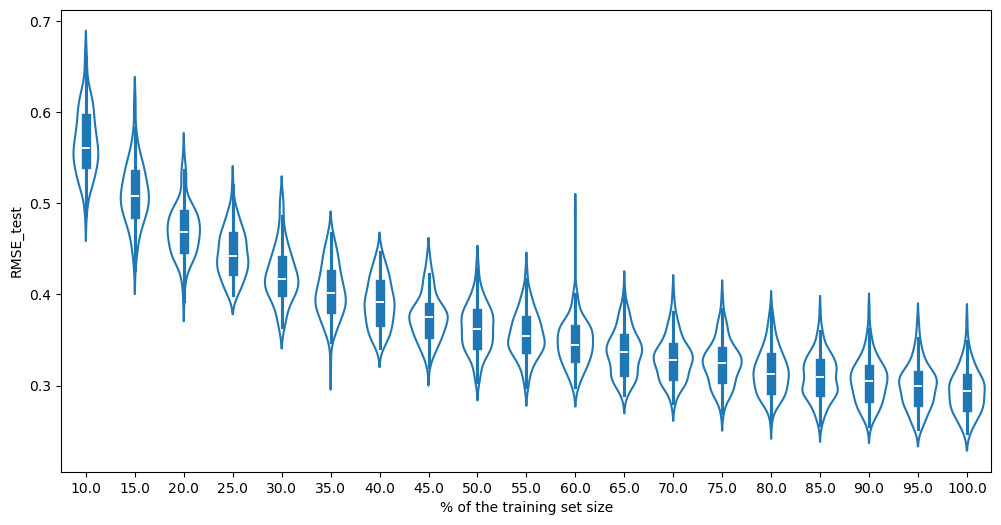

In [37]:
stability_results = pd.read_csv('Width_stability.csv')

fig, ax = plt.subplots(figsize = (12, 6))
sns.violinplot(data = stability_results, x = 'train %', y = 'RMSE_test', ax = ax, fill = False)
# ax.set_ylim(0.1, 2.1)
# ax.set_xlim(20, 100)
ax.set_xlabel('% of the training set size')
plt.show()

C:\Users\Alex\AppData\Local\Temp\1\ipykernel_688\539635997.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1, 1].set_xticklabels(np.arange(10, 105, 5))


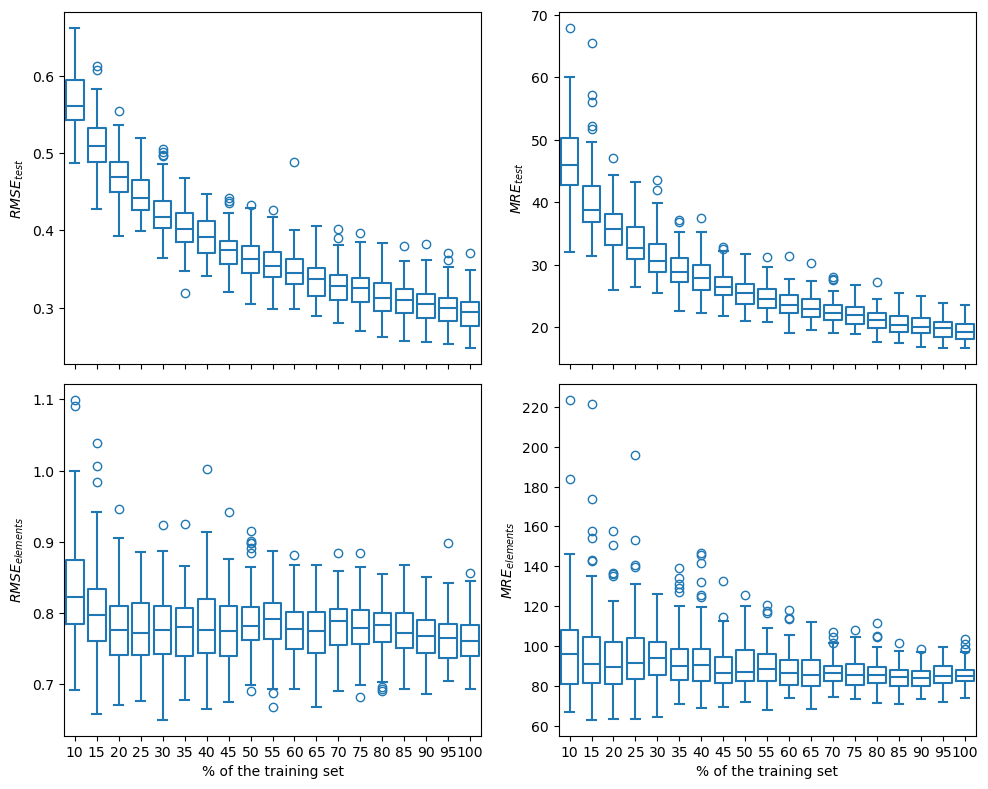

In [197]:
import matplotlib.ticker as ticker

new_rc_params = {'text.usetex': False,
                "svg.fonttype": 'none'
                }
plt.rcParams.update(new_rc_params)

width_stability = pd.read_csv('Width_stability.csv')

fig, ax = plt.subplots(2, 2, figsize = (10, 8), sharex=True)
sns.boxplot(data = width_stability, x = 'train %', y = 'RMSE_test', fill = False, ax = ax[0, 0])
sns.boxplot(data = width_stability, x = 'train %', y = 'MRE_test', fill = False, ax = ax[0, 1])
sns.boxplot(data = width_stability, x = 'train %', y = 'RMSE_elements', fill = False, ax = ax[1, 0])
sns.boxplot(data = width_stability, x = 'train %', y = 'MRE_elements', fill = False, ax = ax[1, 1])

ax[0, 0].set_ylabel('$RMSE_{test}$')
ax[0, 1].set_ylabel('$MRE_{test}$')
ax[1, 0].set_ylabel('$RMSE_{elements}$')
ax[1, 1].set_ylabel('$MRE_{elements}$')

ax[1, 0].set_xlabel('% of the training set')
ax[1, 1].set_xlabel('% of the training set')

ax[1, 1].set_xticklabels(np.arange(10, 105, 5))

plt.tight_layout()
# fig.savefig('Width stability.svg', transparent=True, format = 'svg')
plt.show()

### Shift best model

In [ ]:
ensemble_shift = [
    'RF_Shift_Enorm_Aug_Scaler',
    ]

stability_results = pd.DataFrame(columns=['Split ID', 'train %', 'RMSE_test', 'MRE_test', 'RMSE_elements', 'MRE_elements'])
stability_id = 0

#Step 1. Train/test Split.
for split_id in tqdm(range(100)):
    data_test_q1, target_test_q1 = test_selection(data_shift,
                                                  target_shift,
                                                  p = 0.135,
                                                  low_limit = 'min',
                                                  up_limit = 25,
                                                 )
    data_test_q2, target_test_q2 = test_selection(data_shift,
                                                  target_shift,
                                                  p = 0.135,
                                                  low_limit = 25,
                                                  up_limit = 50,
                                                 )
    data_test_q3, target_test_q3 = test_selection(data_shift,
                                                  target_shift,
                                                  p = 0.135,
                                                  low_limit = 50,
                                                  up_limit = 75,
                                                 )
    data_test_q4, target_test_q4 = test_selection(data_shift,
                                                  target_shift,
                                                  p = 0.135,
                                                  low_limit = 75,
                                                 )
    data_shift_test, target_shift_test = pd.concat([data_test_q1, data_test_q2]), pd.concat([target_test_q1, target_test_q2])
    data_shift_test, target_shift_test = pd.concat([data_shift_test, data_test_q3]), pd.concat([target_shift_test, target_test_q3])
    data_shift_test, target_shift_test = pd.concat([data_shift_test, data_test_q4]), pd.concat([target_shift_test, target_test_q4])

    data_shift_train_full, target_shift_train_full = data_shift.drop(data_shift_test.index).copy(),target_shift.drop(target_shift_test.index).copy()

    #Step 2.Percentage
    for train_percent in range(10, 101, 5):
        if train_percent == 100:
            data_shift_train, target_shift_train = data_shift_train_full.copy(), target_shift_train_full.copy()
        else:
            data_shift_train, data_drop, target_shift_train, target_drop = train_test_split(data_shift_train_full,
                                                                                            target_shift_train_full,
                                                                                            test_size = 1-train_percent/100)
    #Step 3. Train ensemble
        preds, preds_elem = train_ensemble(ensemble_shift)

        pred, pred_elem = np.zeros(len(preds[list(preds.keys())[0]])), np.zeros(len(preds_elem[list(preds_elem.keys())[0]]))
        for key in preds:
            pred      += preds[key]
            pred_elem += preds_elem[key]
        pred /= len(preds) 
        pred_elem /= len(preds_elem)

    #Step 4. Calculate loss functions
        RMSE = root_mean_squared_error(target_shift_test, pred)
        MRE = ((np.abs(target_shift_test - pred) / np.abs(target_shift_test))*100).replace(np.inf, np.nan).mean()
        RMSE_elem = root_mean_squared_error(target_shift_elements, pred_elem)
        MRE_elem = ((np.abs(target_shift_elements - pred_elem) / np.abs(target_shift_elements))*100).replace(np.inf, np.nan).mean()

    #Step 5. Insert loss to dataframe
        stability_results.loc[stability_id] = [split_id, train_percent, RMSE, MRE, RMSE_elem, MRE_elem]
        stability_id +=1

# stability_results.to_csv('Shift_stability.csv', index = False)        
stability_results

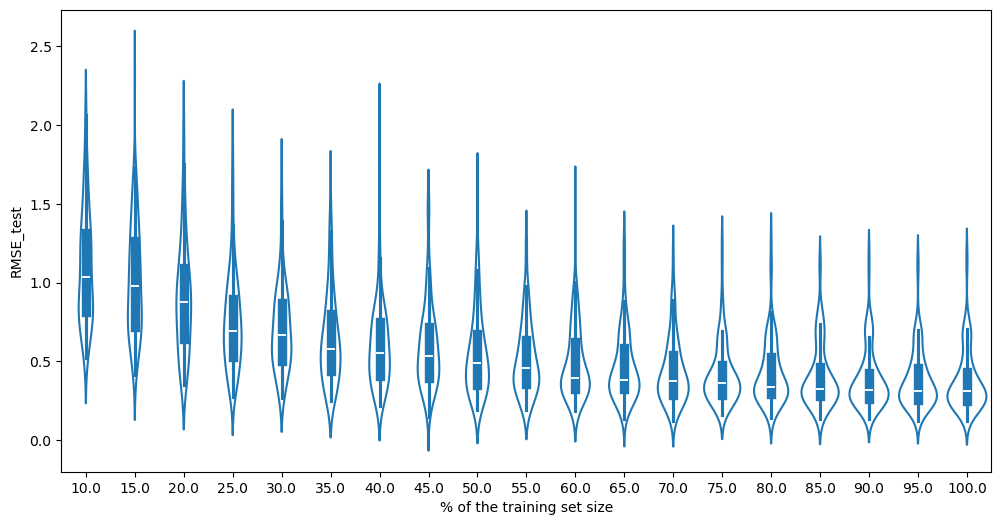

In [42]:
stability_results = pd.read_csv('Shift_stability.csv')

fig, ax = plt.subplots(figsize = (12, 6))
sns.violinplot(data = stability_results, x = 'train %', y = 'RMSE_test', ax = ax, fill = False)
# ax.set_ylim(0.1, 2.1)
# ax.set_xlim(20, 100)
ax.set_xlabel('% of the training set size')
plt.show()

### Both best model

In [ ]:
ensemble_both = [
    'RF_Both_Eraw_Raw_No',
    ]

stability_results = pd.DataFrame(columns=['Split ID', 'train %', 'RMSE_test', 'MRE_test', 'RMSE_elements', 'MRE_elements'])
stability_id = 0

#Step 1. Train/test Split.
for split_id in tqdm(range(100)):
    data_test_q1, target_test_q1 = test_selection(data_both,
                                                  target_both,
                                                  p = 0.114,
                                                  low_limit = 'min',
                                                  up_limit = 25,
                                                 )
    data_test_q2, target_test_q2 = test_selection(data_both,
                                                  target_both,
                                                  p = 0.114,
                                                  low_limit = 25,
                                                  up_limit = 50,
                                                 )
    data_test_q3, target_test_q3 = test_selection(data_both,
                                                  target_both,
                                                  p = 0.114,
                                                  low_limit = 50,
                                                  up_limit = 75,
                                                 )
    data_test_q4, target_test_q4 = test_selection(data_both,
                                                  target_both,
                                                  p = 0.114,
                                                  low_limit = 75,
                                                 )
    data_both_test, target_both_test = pd.concat([data_test_q1, data_test_q2]), pd.concat([target_test_q1, target_test_q2])
    data_both_test, target_both_test = pd.concat([data_both_test, data_test_q3]), pd.concat([target_both_test, target_test_q3])
    data_both_test, target_both_test = pd.concat([data_both_test, data_test_q4]), pd.concat([target_both_test, target_test_q4])

    data_both_train_full, target_both_train_full = data_both.drop(data_both_test.index).copy(),target_both.drop(target_both_test.index).copy()

    #Step 2.Percentage
    for train_percent in range(10, 101, 5):
        if train_percent == 100:
            data_both_train, target_both_train = data_both_train_full.copy(), target_both_train_full.copy()
        else:
            data_both_train, data_drop, target_both_train, target_drop = train_test_split(data_both_train_full,
                                                                                          target_both_train_full,
                                                                                          test_size = 1-train_percent/100)
    #Step 3. Train ensemble
        preds, preds_elem = train_ensemble(ensemble_both)

        pred, pred_elem = np.zeros(len(preds[list(preds.keys())[0]])), np.zeros(len(preds_elem[list(preds_elem.keys())[0]]))
        for key in preds:
            pred      += preds[key]
            pred_elem += preds_elem[key]
        pred /= len(preds) 
        pred_elem /= len(preds_elem)

    #Step 4. Calculate loss functions
        RMSE = root_mean_squared_error(target_both_test, pred)
        MRE = ((np.abs(target_both_test - pred) / np.abs(target_both_test))*100).replace(np.inf, np.nan).mean()
        RMSE_elem = root_mean_squared_error(target_both_elements, pred_elem)
        MRE_elem = ((np.abs(target_both_elements - pred_elem) / np.abs(target_both_elements))*100).replace(np.inf, np.nan).mean()

    #Step 5. Insert loss to dataframe
        stability_results.loc[stability_id] = [split_id, train_percent, RMSE, MRE, RMSE_elem, MRE_elem]
        stability_id +=1

# stability_results.to_csv('Both_stability.csv', index = False)        
stability_results

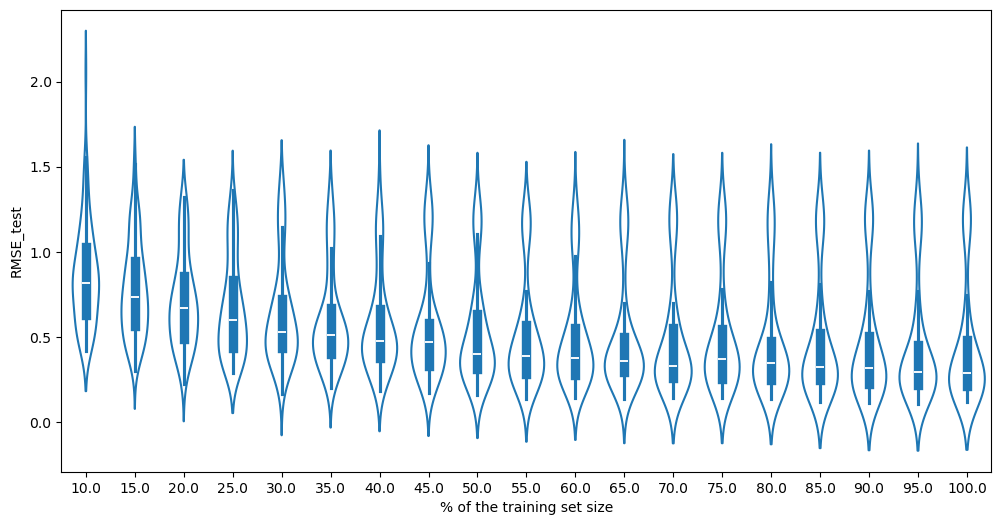

In [55]:
stability_results = pd.read_csv('Both_stability.csv')

fig, ax = plt.subplots(figsize = (12, 6))
sns.violinplot(data = stability_results, x = 'train %', y = 'RMSE_test', ax = ax, fill = False)
# ax.set_ylim(0.1, 2.1)
ax.set_xlabel('% of the training set size')
plt.show()

# Models' stability by one line

## Width

In [ ]:
ensemble_width = [
    'XGB_A+I_Eraw_Raw_No',
    'CatBoost_A+I_Enorm_Raw_No',
    'LightGBM_A+I_Enorm_Raw_Scaler',
    'LightGBM_A+I_Eraw_Raw_No',
    'XGB_A+I_Enorm_Aug_No',
]

element = 'Mn'
wavelength = 667.815

data_width_elements_full, target_width_elements_full = data_width_elements.copy(), target_width_elements.copy()
data_width_elements   = data_width_elements_full.loc[(data_width_elements_full['Element'] == element) &
                                                     (data_width_elements_full['Charge'] ==  0)]
target_width_elements = target_width_elements_full.loc[data_width_elements_full.index]

stability_id = 0

#Step 1. Drop He I 667.815
data_width_train_full   = data_width.drop(data_width.loc[data_width['Wavelength'] == wavelength].index)
target_width_train_full = target_width.drop(data_width.loc[data_width['Wavelength'] == wavelength].index)

data_width_test   = data_width.loc[data_width['Wavelength'] == wavelength]
target_width_test = target_width.loc[data_width.loc[data_width['Wavelength'] == wavelength].index]

line_preds    = pd.DataFrame(columns = ['Split ID', 'train %'] + list(data_width_test.index))
element_preds = pd.DataFrame(columns = ['Split ID', 'train %'] + list(data_width_elements.index))

#Step 2.Percentage
for split_id in tqdm(range(2)):
    for train_percent in range(96, 100, 1):
        data_width_train, data_drop, target_width_train, target_drop = train_test_split(data_width_train_full,
                                                                                        target_width_train_full,
                                                                                        test_size = 1-train_percent/100)
#Step 3. Train ensemble
        preds, preds_elem = train_ensemble(ensemble_width)

        pred, pred_elem = np.zeros(len(preds[list(preds.keys())[0]])), np.zeros(len(preds_elem[list(preds_elem.keys())[0]]))
        for key in preds:
            pred      += preds[key]
            pred_elem += preds_elem[key]
        pred /= len(preds) 
        pred_elem /= len(preds_elem)

#Step 4. Insert predicted values to dataframe
        line_preds.loc[stability_id]    = [split_id, train_percent, *unscale(pred)]
        element_preds.loc[stability_id] = [split_id, train_percent, *unscale(pred_elem)]

        stability_id +=1

data_width_elements, target_width_elements = data_width_elements_full.copy(), target_width_elements_full.copy()
        
        
line_preds

In [199]:
line_preds.to_csv('He_predictions_width_96_99.csv', index = False)
element_preds.to_csv('Mn_predictions_width_96_99.csv', index = False)

### One line from the test set 

Select any He line with ID from the following list: 57, 58, 59, 60, 61,   62,   63,   64,   65,   66,   67,   68, 69,   70,   71,   72,   73,   74,   75,   76,   77,   78,   79,  164, 165,  177, 1128.
These lines are guaranteed to have known accuracy of experimentally measured broadening parameter

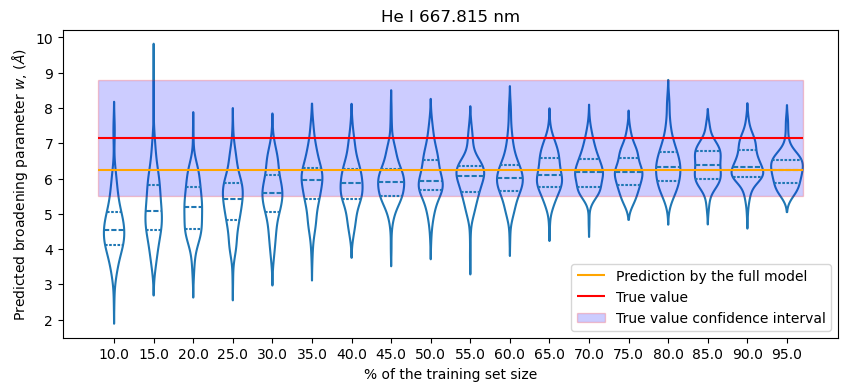

In [229]:
lineID = 71

line_preds = pd.read_csv('He_predictions_width.csv')

fig, ax = plt.subplots(figsize = (10, 4))
sns.violinplot(data = line_preds, x = 'train %', y = str(lineID), ax = ax, inner = 'quartile', fill = False)
xlim_l, xlim_r = ax.get_xlim()
ax.hlines(line_preds.loc[line_preds['train %'] == 95][str(lineID)].describe()['50%'],
          xlim_l+.1,
          xlim_r-.1,
          'orange',
         label = 'Prediction by the full model')
ax.hlines(data.loc[lineID]['w (A)'],
          xlim_l+.1,
          xlim_r-.1,
          'red', 
         label = 'True value')
line_accuracy = data.loc[lineID]['w error (%)']/100

rect = Rectangle((xlim_l+.1, data.loc[lineID]['w (A)']*(1-line_accuracy)),
                 xlim_r-.1 - xlim_l-.1, data.loc[lineID]['w (A)'] * line_accuracy * 2,
                 edgecolor='r',
                 facecolor='blue', alpha = 0.2,
                label = 'True value confidence interval')
ax.add_patch(rect)
ax.set_title(f'{data.loc[lineID]["Element"]} I {data.loc[lineID]["Wavelength"]} nm')
ax.set_ylabel(r'Predicted broadening parameter $w$, ($\AA$)')
ax.set_xlabel(f'% of the training set size')
plt.legend(loc = 'lower right')

plt.show()

### One line from the "elements" test set

Select any Mn I line from "elements" test set with ID from the following list: 1254, 1255, 1256, 1257, 1258, 1259, 1260, 1261, 1262, 1263, 1264, 1265, 1266, 1267, 1268, 1269, 1270, 1271, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279.
These lines are guaranteed to have known accuracy of experimentally measured broadening parameter

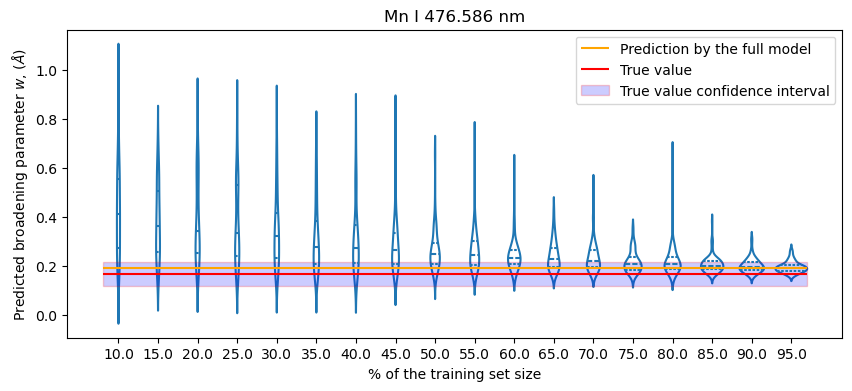

In [228]:
lineID = 1272

element_preds = pd.read_csv('Mn_predictions_width.csv')

fig, ax = plt.subplots(figsize = (10, 4))
sns.violinplot(data = element_preds, x = 'train %', y = str(lineID), ax = ax, inner = 'quartile', fill = False)
xlim_l, xlim_r = ax.get_xlim()
ax.hlines(element_preds.loc[element_preds['train %'] == 95][str(lineID)].describe()['50%'],
          xlim_l+.1,
          xlim_r-.1,
          'orange',
         label = 'Prediction by the full model')
ax.hlines(target_width_elements.loc[lineID],
          xlim_l+.1,
          xlim_r-.1,
          'red', 
         label = 'True value')
line_accuracy = data.loc[lineID]['w error (%)']/100

from matplotlib.patches import Rectangle
rect = Rectangle((xlim_l+.1, target_width_elements.loc[lineID]*(1-line_accuracy)),
                 xlim_r-.1 - xlim_l-.1, target_width_elements.loc[lineID] * line_accuracy * 2,
                 edgecolor='r',
                 facecolor='blue', alpha = 0.2,
                label = 'True value confidence interval')
ax.add_patch(rect)
ax.set_title(f'{data.loc[lineID]["Element"]} I {data.loc[lineID]["Wavelength"]} nm')
ax.set_ylabel(r'Predicted broadening parameter $w$, ($\AA$)')
ax.set_xlabel(f'% of the training set size')
plt.legend(loc = 'upper right')

plt.show()

## Shift

### One line from the test set 

In [ ]:
ensemble_shift = [
    'RF_Shift_Enorm_Aug_Scaler',
]

data_shift_elements_full, target_shift_elements_full = data_shift_elements.copy(), target_shift_elements.copy()
data_shift_elements   = data_shift_elements_full.loc[(data_shift_elements_full['Element'] == 'Mn') &
                                                     (data_shift_elements_full['Charge'] ==  0)]
target_shift_elements = target_shift_elements_full.loc[data_shift_elements_full.index]

stability_id = 0

#Step 1. Drop He I 667.815
data_shift_train_full   = data_shift.drop(data_shift.loc[data_shift['Wavelength'] == 667.815].index)
target_shift_train_full = target_shift.drop(data_shift.loc[data_shift['Wavelength'] == 667.815].index)

data_shift_test   = data_shift.loc[data_shift['Wavelength'] == 667.815]
target_shift_test = target_shift.loc[data_shift.loc[data_shift['Wavelength'] == 667.815].index]

line_preds    = pd.DataFrame(columns = ['Split ID', 'train %'] + list(data_shift_test.index))
element_preds = pd.DataFrame(columns = ['Split ID', 'train %'] + list(data_shift_elements.index))

#Step 2.Percentage
for split_id in tqdm(range(100)):
    for train_percent in range(10, 100, 5):
        data_shift_train, data_drop, target_shift_train, target_drop = train_test_split(data_shift_train_full,
                                                                                        target_shift_train_full,
                                                                                        test_size = 1-train_percent/100)
#Step 3. Train ensemble
        preds, preds_elem = train_ensemble(ensemble_shift)

        pred, pred_elem = np.zeros(len(preds[list(preds.keys())[0]])), np.zeros(len(preds_elem[list(preds_elem.keys())[0]]))
        for key in preds:
            pred      += preds[key]
            pred_elem += preds_elem[key]
        pred /= len(preds) 
        pred_elem /= len(preds_elem)

#Step 4. Insert predicted values to dataframe
        line_preds.loc[stability_id]    = [split_id, train_percent, *pred]
        element_preds.loc[stability_id] = [split_id, train_percent, *pred_elem]

        stability_id +=1

data_shift_elements, target_shift_elements = data_shift_elements_full.copy(), target_shift_elements_full.copy()
        
        
line_preds

In [220]:
line_preds.to_csv('He_predictions_shift.csv', index = False)
element_preds.to_csv('Mn_predictions_shift.csv', index = False)

Select any He I 667.815nm line entry from the test set with ID from the following list: 60,   61,   63,   64,  177, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137.
These entries are guaranteed to have known accuracy of experimentally measured shift parameter

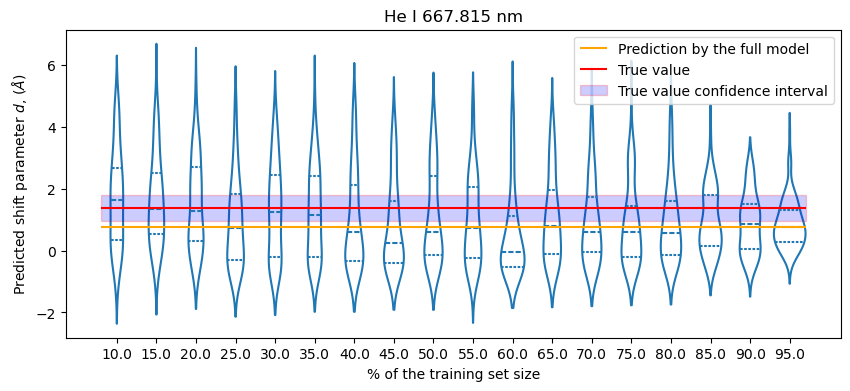

In [238]:
lineID = 1129

line_preds = pd.read_csv('He_predictions_shift.csv')

fig, ax = plt.subplots(figsize = (10, 4))
sns.violinplot(data = line_preds, x = 'train %', y = str(lineID), ax = ax, inner = 'quartile', fill = False)
xlim_l, xlim_r = ax.get_xlim()
ax.hlines(line_preds.loc[line_preds['train %'] == 95][str(lineID)].describe()['50%'],
          xlim_l+.1,
          xlim_r-.1,
          'orange',
         label = 'Prediction by the full model')
ax.hlines(data.loc[lineID]['d (A)'],
          xlim_l+.1,
          xlim_r-.1,
          'red', 
         label = 'True value')
line_accuracy = data.loc[lineID]['d error (%)']/100

rect = Rectangle((xlim_l+.1, data.loc[lineID]['d (A)']*(1-line_accuracy)),
                 xlim_r-.1 - xlim_l-.1, data.loc[lineID]['d (A)'] * line_accuracy * 2,
                 edgecolor='r',
                 facecolor='blue', alpha = 0.2,
                label = 'True value confidence interval')
ax.add_patch(rect)
ax.set_title(f'{data.loc[lineID]["Element"]} I {data.loc[lineID]["Wavelength"]} nm')
ax.set_ylabel(r'Predicted shift parameter $d$, ($\AA$)')
ax.set_xlabel(f'% of the training set size')
plt.legend(loc = 'upper right')

plt.show()

### One line from the "elements" test set 

Select any Mn I line from "elements" test set with ID from the following list: 1260, 1266, 1267, 1268, 1270, 1271, 1272, 1273, 1274, 5014, 5016, 5018, 5027, 5028, 5029, 5033, 5034, 5035, 5036, 5040, 5042, 5043, 5044, 5047, 5050, 5051, 5052, 5053, 5054, 5056, 5057, 5058, 6115, 6116, 6117.
These lines are guaranteed to have known accuracy of experimentally measured broadening parameter

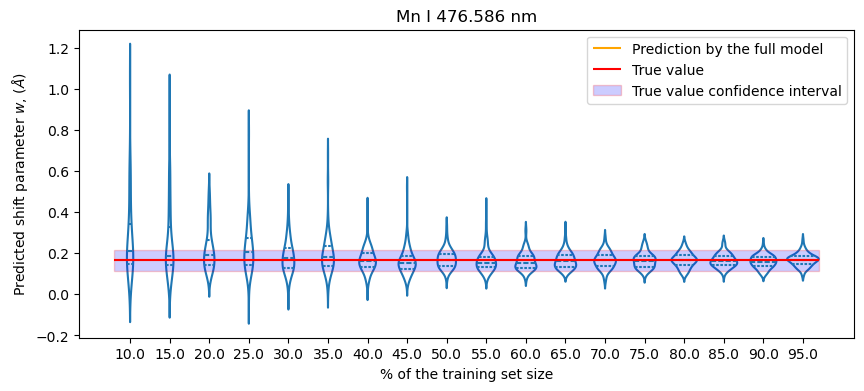

In [237]:
lineID = 1272

element_preds = pd.read_csv('Mn_predictions_shift.csv')

fig, ax = plt.subplots(figsize = (10, 4))
sns.violinplot(data = element_preds, x = 'train %', y = str(lineID), ax = ax, inner = 'quartile', fill = False)
xlim_l, xlim_r = ax.get_xlim()
ax.hlines(element_preds.loc[element_preds['train %'] == 95][str(lineID)].describe()['50%'],
          xlim_l+.1,
          xlim_r-.1,
          'orange',
         label = 'Prediction by the full model')
ax.hlines(target_width_elements.loc[lineID],
          xlim_l+.1,
          xlim_r-.1,
          'red', 
         label = 'True value')
line_accuracy = data.loc[lineID]['w error (%)']/100

from matplotlib.patches import Rectangle
rect = Rectangle((xlim_l+.1, target_width_elements.loc[lineID]*(1-line_accuracy)),
                 xlim_r-.1 - xlim_l-.1, target_width_elements.loc[lineID] * line_accuracy * 2,
                 edgecolor='r',
                 facecolor='blue', alpha = 0.2,
                label = 'True value confidence interval')
ax.add_patch(rect)
ax.set_title(f'{data.loc[lineID]["Element"]} I {data.loc[lineID]["Wavelength"]} nm')
ax.set_ylabel(r'Predicted shift parameter $w$, ($\AA$)')
ax.set_xlabel(f'% of the training set size')
plt.legend(loc = 'upper right')

plt.show()

## Both

### One line from the test set 

In [ ]:
ensemble_both = [
    'RF_Both_Eraw_Aug_No',
]

data_both_elements_full, target_both_elements_full = data_both_elements.copy(), target_both_elements.copy()
data_both_elements   = data_both_elements_full.loc[(data_both_elements_full['Element'] == 'Mn') &
                                                     (data_both_elements_full['Charge'] ==  0)]
target_both_elements = target_both_elements_full.loc[data_both_elements_full.index]

stability_id = 0

#Step 1. Drop He I 667.815
data_both_train_full   = data_both.drop(data_both.loc[data_both['Wavelength'] == 667.815].index)
target_both_train_full = target_both.drop(data_both.loc[data_both['Wavelength'] == 667.815].index)

data_both_test   = data_both.loc[data_shift['Wavelength'] == 667.815]
target_both_test = target_both.loc[data_both.loc[data_both['Wavelength'] == 667.815].index]

line_preds    = pd.DataFrame(columns = ['Split ID', 'train %'] + list(data_both_test.index))
element_preds = pd.DataFrame(columns = ['Split ID', 'train %'] + list(data_both_elements.index))

#Step 2.Percentage
for split_id in tqdm(range(100)):
    for train_percent in range(10, 100, 5):
        data_both_train, data_drop, target_both_train, target_drop = train_test_split(data_both_train_full,
                                                                                      target_both_train_full,
                                                                                      test_size = 1-train_percent/100)
#Step 3. Train ensemble
        preds, preds_elem = train_ensemble(ensemble_both)

        pred, pred_elem = np.zeros(len(preds[list(preds.keys())[0]])), np.zeros(len(preds_elem[list(preds_elem.keys())[0]]))
        for key in preds:
            pred      += preds[key]
            pred_elem += preds_elem[key]
        pred /= len(preds) 
        pred_elem /= len(preds_elem)

#Step 4. Insert predicted values to dataframe
        line_preds.loc[stability_id]    = [split_id, train_percent, *pred]
        element_preds.loc[stability_id] = [split_id, train_percent, *pred_elem]

        stability_id +=1

data_both_elements, target_both_elements = data_both_elements_full.copy(), target_both_elements_full.copy()
        
        
line_preds

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

# Pedicting Stark parameters

In [ ]:
factor = 1.05
data_width_extended = data_width
target_width_extended = target_width
for index, row in data_width.iterrows():
    row['T'] = row['T']*factor
    data_width_extended = data_width_extended.append(row, ignore_index=True, verify_integrity = True)
    target_width_extended = target_width_extended.append(pd.Series(target_width.loc[index]), ignore_index=True)

    row['T'] = row['T']/factor**2
    data_width_extended = data_width_extended.append(row, ignore_index=True, verify_integrity = True)
    target_width_extended = target_width_extended.append(pd.Series(target_width.loc[index]), ignore_index=True)

In [ ]:
models = ['KNN_Extended', 'XGB_Extended', 'TabNet_Extended']
models_d = create_models_dict(models)
epsilon = 1e-3

for name, model in models_d.items():
    print(f"Training {name} model")
    if 'TabNet' in name:
        model.fit(data_width_extended.drop(columns=['Element', 'Wavelength', 'Z number']), np.log(1 + target_width_extended / epsilon), XW_test, np.log(1 + YW_test / epsilon))
    else:
        model.fit(data_width_extended.drop(columns=['Element', 'Wavelength', 'Z number']), np.log(1 + target_width_extended / epsilon))

In [ ]:
data_predictions = pd.read_excel('/content/Stark_ML/Source_files/Stark_data.xlsx',
                     sheet_name='Fe_diagnostics',
                     usecols='A:BC'
                   )
data_predictions['Term'] = term_to_number(data_predictions['Term'])
data_predictions['Term.1'] = term_to_number(data_predictions['Term.1'])

In [ ]:
predictions = {}
for name, model in models_d.items():
    predictions[name] = model.predict(data_predictions.drop(columns=['Element', 'Wavelength', 'Z number', 'w (A)', 'd (A)']))

In [ ]:
fig, ax = plt.subplots()
for name, model in predictions.items():
    ax.plot((np.exp(model) - 1) * epsilon, label = f'{name}')

plt.legend()
plt.show()

In [ ]:
predictions['XGB_Extended']

np.savetxt('Fe predictions.csv', (np.exp(predictions['XGB_Extended']) - 1) * epsilon, delimiter = ',')

In [ ]:
data_width_extended.describe()

# Auxilary functions

In [ ]:
d = pd.read_excel('/content/Stark_ML/Source_files/Stark_data.xlsx',
                     sheet_name='Fe_diagnostics',
                     usecols='BD:BE'
                   )

In [ ]:
with open("insert.txt", "w") as output:
    output.write('insert into starknew (line_id, temp, e_dens, fwhm, alpha, beta, width_ref, shift_ref) \nvalues')
    for index, item in d.iterrows():
        if not np.isnan(item['fwhm']):
            line = f"({item['line_id']}, 7200, 1.0E17, {item['fwhm']}, 0, 0, 19, 19),\n"
            output.write(line)

In [ ]:
with open("delete.txt", "w") as output:
    output.write('delete from starknew where line_id in (')
    for index, item in d.iterrows():
        line = f"{int(item['line_id'])}, "
        output.write(line)
    output.write(')')

# Debugging

In [ ]:
import sklearn
import sklearn.datasets
from sklearn.model_selection import train_test_split

calif_housing = sklearn.datasets.fetch_california_housing()
x = calif_housing.data
y = calif_housing.target
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
x_learn, x_valid, y_learn, y_valid = train_test_split(x_train, y_train, random_state=42)

In [ ]:
from pytorch_tabnet.tab_model import  TabNetRegressor
from warnings import simplefilter
simplefilter("ignore", category=UserWarning)

tabnet = TabNetRegressor()
tabnet.fit(x_learn, y_learn.reshape(-1, 1),
           eval_set = [(x_valid,  y_valid.reshape(-1, 1))])

In [ ]:
!nvidia-smi

In [ ]:
import datetime
print(datetime.datetime.now())
predictions = {}
for i in range(100):
    models = [f'TabNet_Extended']
    models_d = create_models_dict(models)
    epsilon = 1e-3

    for name, model in models_d.items():
        print(f"Training {name}_{i} model")
        if 'TabNet' in name:
            model.fit(data_width_extended.drop(columns=['Element', 'Wavelength', 'Z number']), np.log(1 + target_width_extended / epsilon), XW_test, np.log(1 + YW_test / epsilon))
        predictions[f'{name}_{i}'] = model.predict(data_predictions.drop(columns=['Element', 'Wavelength', 'Z number', 'w (A)', 'd (A)']))
print(datetime.datetime.now())

In [ ]:
import pickle
with open('100 Predictions.pkl', 'wb') as f:
    pickle.dump(predictions, f)

In [ ]:
from IGTD.Scripts.IGTD_Functions import *

In [ ]:
norm_data = min_max_transform(XW_train.to_numpy())

ranking, corr = generate_feature_distance_ranking(norm_data)

pix = generate_matrix_distance_ranking(5, 10)

In [ ]:
%matplotlib inline
plt.figure(figsize= (12,12))
plt.imshow(ranking)
plt.colorbar()
plt.show()

In [ ]:
index_record, err_record, run_time = IGTD_square_error(ranking, pix[1], file_name = 'Resss', save_folder = 'content')

In [ ]:
table_to_image(norm_data, [5, 10], 'Pearson', 'Euclidean', save_image_size = )

In [ ]:
models = ['TabNet_Scaled']
models_d = create_models_dict(models)

for name, models in models_d.items():
    print(f'Fitting model {name}')
    model.fit(XW_train, YW_train)

type(models_d['TabNet_Scaled'])

In [ ]:
%debug

In [ ]:
LW_elem

In [ ]:
models = ['KNN', 'RF', 'GB', 'XGB', 'TabNet', 'LightGBM']

models_d = create_models_dict(models)

tuned_results = train_and_test_regressor(models_d, XW_train, YW_train, XW_test, YW_test)

plot_model_comparison(tuned_results)

In [ ]:
%debug

In [ ]:
nfolds = 5
#kf = KFold(nfolds, shuffle = True, random_state=7)
kf = KFold(nfolds, shuffle = False)
score_XGB = 0
score_GB = 0

with open(path + f'/GB' + '_optimal_parameters', 'r') as fp:
    GB_params = json.load(fp)
with open(path + f'/XGB' + '_optimal_parameters', 'r') as fp:
    XGB_params = json.load(fp)

for train, test in kf.split(XW_train):
    #print(XW_train.iloc[test, :])
    #print(YW_train.iloc[test])
    #break

    model_XGB = xgboost.XGBRegressor(**XGB_params, n_estimators = 500, n_jobs = -1)
    model_GB = GradientBoostingRegressor(**GB_params, n_estimators = 500)
    
    model_XGB.fit(XW_train.iloc[train, :], YW_train.iloc[train])
    model_GB.fit(XW_train.iloc[train, :], YW_train.iloc[train])
    
    score_XGB += mean_squared_error(YW_train.iloc[test], model_XGB.predict(XW_train.iloc[test, :]),
                                squared = True)
    score_GB += mean_squared_error(YW_train.iloc[test], model_GB.predict(XW_train.iloc[test, :]),
                                squared = True)
    print('\n', 'XGB model:', mean_squared_error(YW_train.iloc[test], model_XGB.predict(XW_train.iloc[test, :]),
                                squared = True))
    print('GB model', mean_squared_error(YW_train.iloc[test], model_GB.predict(XW_train.iloc[test, :]),
                                squared = True))
score_XGB /= nfolds
score_GB /= nfolds

print(f"\n XGB score {score_XGB}")
print(f"GB score {score_GB}")

models = {
    'GB' : model_GB,
    'XGB' : model_XGB
}
print(models)
rrr = train_and_test_regressor(models,
                               XW_train,
                               YW_train,
                               XW_test.sample(frac = 1, random_state = 777),
                               YW_test.sample(frac = 1, random_state = 777))
plot_model_comparison(rrr)

fig, ax = plt.subplots(1, 2, figsize = (20, 8))
ax[0].plot(YW_test, model_GB.predict(XW_test), 'r.')
ax[1].plot(YW_test, model_XGB.predict(XW_test), 'r.')
for i in ax:
    i.plot([0, 170], [0, 170], color = 'b', ls = '--')
    i.set_xlim(-1, 15)
    i.set_ylim(-1, 15)
plt.show()


print(f'GB MSE: {mean_squared_error(YW_test, model_GB.predict(XW_test))}')
print(f'XGB MSE: {mean_squared_error(YW_test, model_XGB.predict(XW_test))}')


In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (20, 8))
ax[0].plot(YW_test, model_GB.predict(XW_test), 'r.')
ax[1].plot(YW_test, model_XGB.predict(XW_test), 'r.')
for i in ax:
    i.plot([0, 170], [0, 170], color = 'b', ls = '--')
    i.set_xlim(-1, 5)
    i.set_ylim(-1, 5)
plt.show()

In [ ]:
models = ['KNN', 'RF', 'GB', 'XGB', 'TabNet']

models_d = create_models_dict(models)

In [ ]:
print(models_d.items())

In [ ]:
abc = np.array([2, 3, 4])
abc = abc.flatten()
abc.shape